In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()
os.chdir('C:\\')
path = 'F:\\Science\\MF Notebooks\\' # Шлях звідки зсчитувати та зберігати файли

In [3]:
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RPComputation, RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.image_generator import ImageGenerator
from pyrqa.analysis_type import Cross

In [4]:
plt.style.use('classic')
plt.rcParams.update({'legend.fontsize': 26})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['font.size'] = '26'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['savefig.dpi'] = 300

## Зчитування з Yahoo Finance

In [5]:
name_1 = "^GSPC"
data_1 = yf.download(name_1, start='2001-01-01')
time_ser_1 = data_1['Adj Close']
np.savetxt(path+f'{name_1}_initial_time_series.txt', time_ser_1.values)

[*********************100%***********************]  1 of 1 completed


In [6]:
name_2 = "^DJI"
data_2 = yf.download(name_2, start='2001-01-01')
time_ser_2 = data_2['Adj Close']
np.savetxt(path+f'{name_2}_initial_time_series.txt', time_ser_2.values)

[*********************100%***********************]  1 of 1 completed


## Зчитування з .txt файлів

In [ ]:
name_1 = "^GSPC_initial_time_series.txt" #назва файлу, що зчитуємо
with open(path+name_1, 'r') as f1: #зчитуємо файл
    time_ser_1 = [line.strip('\n') for line in f1.readlines()]
    time_ser_1 = [float(line) for line in time_ser_1 if line != '']
time_ser_1 = pd.Series(time_ser_1) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

In [ ]:
name_2 = "^DJI_initial_time_series.txt" #назва файлу, що зчитуємо
with open(path+name_2, 'r') as f2: #зчитуємо файл
    time_ser_2 = [line.strip('\n') for line in f2.readlines()]
    time_ser_2 = [float(line) for line in time_ser_2 if line != '']
time_ser_2 = pd.Series(time_ser_2)

## Виведення графіків досліджуваних рядів

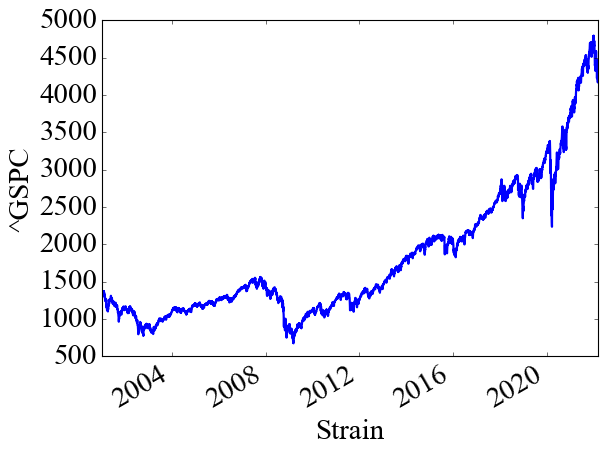

In [7]:
time_ser_1.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_1.split('.')[0]}")
plt.savefig(path+f'{name_1}.jpg', bbox_inches="tight")
plt.show()

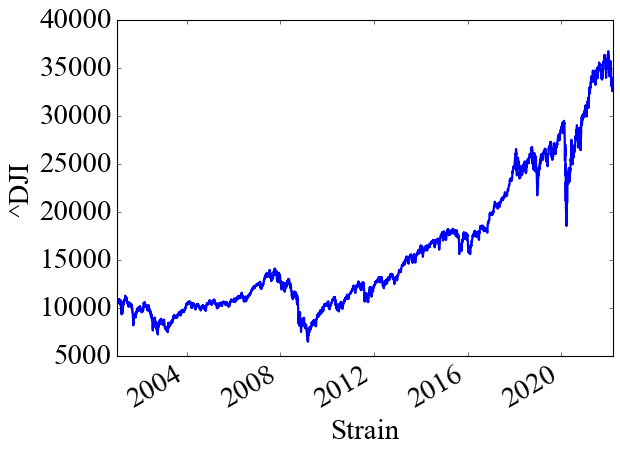

In [8]:
time_ser_2.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_2.split('.')[0]}")
plt.savefig(path+f'{name_2}.jpg', bbox_inches="tight")
plt.show()

## Побудова рекурентної карти всього часового ряду

In [18]:
for_rec_1 = time_ser_1.copy()
for_rec_2 = time_ser_2.copy()

ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 
                        # 4 - стандартизовані прибутковості, 
                        # 5 - абсолютні значення (волатильності)
                        # 6 - стандартизований ряд


if ret_type == 1:
    pass

elif ret_type == 2:
    for_rec_1 = for_rec_1.diff()
    for_rec_2 = for_rec_2.diff()
    
elif ret_type == 3:
    for_rec_1 = for_rec_1.pct_change()
    for_rec_2 = for_rec_2.pct_change()
    
elif ret_type == 4:
    for_rec_1 = for_rec_1.pct_change()
    for_rec_1 -= for_rec_1.mean()
    for_rec_1 /= for_rec_1.std()
    
    for_rec_2 = for_rec_2.pct_change()
    for_rec_2 -= for_rec_2.mean()
    for_rec_2 /= for_rec_2.std()
    
elif ret_type == 5: 
    for_rec_1 = for_rec_1.pct_change()
    for_rec_1 -= for_rec_1.mean()
    for_rec_1 /= for_rec_1.std()
    for_rec_1 = for_rec_1.abs()
    
    for_rec_2 = for_rec_2.pct_change()
    for_rec_2 -= for_rec_2.mean()
    for_rec_2 /= for_rec_2.std()
    for_rec_2 = for_rec_2.abs()
    
elif ret_type == 6:
    for_rec_1 -= for_rec_1.mean()
    for_rec_1 /= for_rec_1.std()
    
    for_rec_2 -= for_rec_2.mean()
    for_rec_2 /= for_rec_2.std()

for_rec_1 = for_rec_1.dropna().values
for_rec_2 = for_rec_2.dropna().values

In [19]:
d_e_1 = 1 # розмірність вкладень першого ряду
tau_1 = 1 # часова затримка першого ряду

d_e_2 = 1 # розмірність вкладень другого ряду
tau_2 = 1 # часова затримка другого ряду 

theiler_wind = 0 # вікно Тейлера
sim_measure = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps = 0.1 # радіус

In [20]:
whole_series_1 = TimeSeries(for_rec_1,
                         embedding_dimension=d_e_1,
                         time_delay=tau_1)

whole_series_2 = TimeSeries(for_rec_2,
                         embedding_dimension=d_e_2,
                         time_delay=tau_2)

whole_series = (whole_series_1, whole_series_2)

settings = Settings(whole_series,
                    analysis_type=Cross,
                    neighbourhood=FixedRadius(eps),
                    similarity_measure=sim_measure,
                    theiler_corrector=theiler_wind)

In [21]:
crp_computation = RPComputation.create(settings)
crp_result = crp_computation.run()

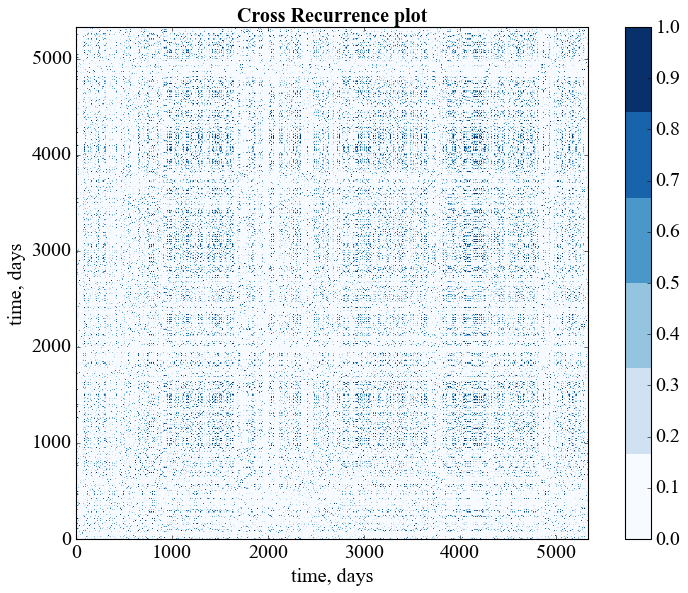

In [22]:
title = "Cross Recurrence plot" # підпис титульний
title_axes = "time, days" #підпис по осям

plt.rcParams['font.size'] = '18' 
fig, ax = plt.subplots(figsize=(12, 8))

rp = ax.imshow(crp_result.recurrence_matrix, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar(rp, ax=ax)
plt.gca().invert_yaxis()
ax.set_title(title, fontweight="bold", size=18)
ax.set_xlabel(title_axes, fontsize=18)
ax.set_ylabel(title_axes, fontsize=18)
plt.savefig(path+f'crp_{name_1}_{name_2}.jpg')
plt.show()

### Віконна процедура

In [44]:
ret_type = 4
window = 250
tstep = 1
length = len(time_ser_1)

d_e_1 = 1 # розмірність вкладень першого ряду
tau_1 = 1 # часова затримка першого ряду

d_e_2 = 1 # розмірність вкладень другого ряду
tau_2 = 1 # часова затримка другого ряду 

theiler_wind = 0 # вікно Тейлера
sim_measure = EuclideanMetric # TaxicabMetric (L1), EuclideanMetric (L2), MaximumMetric (L_inf)
eps = 0.3 # радіус

RR = []
DET = []
DIV = []
AVG_DIAG_LINE = []
ENT_DIAG = []
LAM = []
TT = []
ENT_VERT = []
ENT_WHITE_VERT = []
AVG_VERT_LINE = []
VERT_DIV = []
RATIO_DET_REC = []
RATIO_LAM_DET = []

In [45]:
for i in range(0,length-window,tstep):
    fragm_1 = time_ser_1.iloc[i:i+window].copy() #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    fragm_2 = time_ser_2.iloc[i:i+window].copy()
    
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm_1 = fragm_1.diff()
        fragm_2 = fragm_2.diff()
    elif ret_type == 3:
        fragm_1 = fragm_1.pct_change()
        fragm_2 = fragm_2.pct_change()
    elif ret_type == 4:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        
        fragm_2 = fragm_2.pct_change()
        fragm_2 -= fragm_2.mean()
        fragm_2 /= fragm_2.std()
    elif ret_type == 5: 
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        fragm_1 = fragm_1.abs()

        fragm_2 = fragm_2.pct_change()
        fragm_2 -= fragm_2.mean()
        fragm_2 /= fragm_2.std()
        fragm_2 = fragm_2.abs()
    elif ret_type == 6:
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()

        fragm_2 -= fragm_2.mean()
        fragm_2 /= fragm_2.std()

    fragm_1 = fragm_1.dropna().values
    fragm_2 = fragm_2.dropna().values
    
    whole_series_1 = TimeSeries(fragm_1,
                         embedding_dimension=d_e_1,
                         time_delay=tau_1)

    whole_series_2 = TimeSeries(fragm_2,
                             embedding_dimension=d_e_2,
                             time_delay=tau_2)

    whole_series = (whole_series_1, whole_series_2)

    settings = Settings(whole_series,
                        analysis_type=Cross,
                        neighbourhood=FixedRadius(eps),
                        similarity_measure=sim_measure,
                        theiler_corrector=theiler_wind)
    
    crp_computation = RQAComputation.create(settings, verbose=False)
    resultCRQA = crp_computation.run()
    print(resultCRQA)
    
    RR.append(resultCRQA.recurrence_rate)
    DET.append(resultCRQA.determinism)
    DIV.append(resultCRQA.divergence)
    AVG_DIAG_LINE.append(resultCRQA.average_diagonal_line)
    ENT_DIAG.append(resultCRQA.entropy_diagonal_lines)
    LAM.append(resultCRQA.laminarity)
    TT.append(resultCRQA.trapping_time)
    ENT_VERT.append(resultCRQA.entropy_vertical_lines)
    ENT_WHITE_VERT.append(resultCRQA.entropy_white_vertical_lines)
    AVG_VERT_LINE.append(resultCRQA.average_white_vertical_line)
    VERT_DIV.append(1./resultCRQA.longest_vertical_line)
    RATIO_DET_REC.append(resultCRQA.ratio_determinism_recurrence_rate)
    RATIO_LAM_DET.append(resultCRQA.ratio_laminarity_determinism)

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186707
Determinism (DET): 0.333509
Average diagonal line length (L): 2.218659
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.572855
Laminarity (LAM): 0.332326
Trapping time (TT): 2.249708
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.614100
Average white vertical line length (W): 6.739938
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.516168

Ratio determinism / recurrence rate (DET/RR): 1.786271
Ratio laminarity / determinism (LAM/DET): 0.996452

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184562
Determinism (DET): 0.327

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184707
Determinism (DET): 0.323318
Average diagonal line length (L): 2.212250
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.560517
Laminarity (LAM): 0.345878
Trapping time (TT): 2.328630
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.731161
Average white vertical line length (W): 6.894210
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.548989

Ratio determinism / recurrence rate (DET/RR): 1.750441
Ratio laminarity / determinism (LAM/DET): 1.069777

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184303
Determinism (DET): 0.326

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184142
Determinism (DET): 0.324291
Average diagonal line length (L): 2.207022
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.551529
Laminarity (LAM): 0.373391
Trapping time (TT): 2.351351
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.768966
Average white vertical line length (W): 6.972510
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.562134

Ratio determinism / recurrence rate (DET/RR): 1.761088
Ratio laminarity / determinism (LAM/DET): 1.151407

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183578
Determinism (DET): 0.324

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182836
Determinism (DET): 0.324789
Average diagonal line length (L): 2.228782
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.588563
Laminarity (LAM): 0.369001
Trapping time (TT): 2.363277
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.785266
Average white vertical line length (W): 7.043169
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.566033

Ratio determinism / recurrence rate (DET/RR): 1.776400
Ratio laminarity / determinism (LAM/DET): 1.136125

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183610
Determinism (DET): 0.321

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182255
Determinism (DET): 0.327426
Average diagonal line length (L): 2.229026
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.589555
Laminarity (LAM): 0.377522
Trapping time (TT): 2.384572
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.807701
Average white vertical line length (W): 7.050210
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.569078

Ratio determinism / recurrence rate (DET/RR): 1.796528
Ratio laminarity / determinism (LAM/DET): 1.152998

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181997
Determinism (DET): 0.325

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185836
Determinism (DET): 0.329099
Average diagonal line length (L): 2.234132
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.598616
Laminarity (LAM): 0.380837
Trapping time (TT): 2.374459
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.790752
Average white vertical line length (W): 6.875408
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.555190

Ratio determinism / recurrence rate (DET/RR): 1.770916
Ratio laminarity / determinism (LAM/DET): 1.157209

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185820
Determinism (DET): 0.329

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183594
Determinism (DET): 0.327026
Average diagonal line length (L): 2.230067
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.592295
Laminarity (LAM): 0.378723
Trapping time (TT): 2.353166
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.760577
Average white vertical line length (W): 6.921225
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.565828

Ratio determinism / recurrence rate (DET/RR): 1.781248
Ratio laminarity / determinism (LAM/DET): 1.158081

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184239
Determinism (DET): 0.329

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182545
Determinism (DET): 0.325765
Average diagonal line length (L): 2.226994
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.586977
Laminarity (LAM): 0.381781
Trapping time (TT): 2.331894
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.733716
Average white vertical line length (W): 6.940564
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.575290

Ratio determinism / recurrence rate (DET/RR): 1.784570
Ratio laminarity / determinism (LAM/DET): 1.171953

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182142
Determinism (DET): 0.328

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179433
Determinism (DET): 0.320877
Average diagonal line length (L): 2.227013
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.586707
Laminarity (LAM): 0.382831
Trapping time (TT): 2.292250
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.685219
Average white vertical line length (W): 6.928561
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.589121

Ratio determinism / recurrence rate (DET/RR): 1.788288
Ratio laminarity / determinism (LAM/DET): 1.193078

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179594
Determinism (DET): 0.318

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180045
Determinism (DET): 0.316182
Average diagonal line length (L): 2.224215
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.582232
Laminarity (LAM): 0.397295
Trapping time (TT): 2.254703
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.627361
Average white vertical line length (W): 6.914977
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.590090

Ratio determinism / recurrence rate (DET/RR): 1.756126
Ratio laminarity / determinism (LAM/DET): 1.256536

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179820
Determinism (DET): 0.316

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179013
Determinism (DET): 0.313961
Average diagonal line length (L): 2.216828
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.569004
Laminarity (LAM): 0.394180
Trapping time (TT): 2.283403
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.670816
Average white vertical line length (W): 6.926348
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.579190

Ratio determinism / recurrence rate (DET/RR): 1.753842
Ratio laminarity / determinism (LAM/DET): 1.255505

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179642
Determinism (DET): 0.310

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180142
Determinism (DET): 0.316902
Average diagonal line length (L): 2.223785
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.580954
Laminarity (LAM): 0.398335
Trapping time (TT): 2.317188
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.719148
Average white vertical line length (W): 6.818623
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.540960

Ratio determinism / recurrence rate (DET/RR): 1.759177
Ratio laminarity / determinism (LAM/DET): 1.256965

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180578
Determinism (DET): 0.315

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192384
Determinism (DET): 0.339502
Average diagonal line length (L): 2.255524
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.632852
Laminarity (LAM): 0.413984
Trapping time (TT): 2.369482
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.789427
Average white vertical line length (W): 6.510578
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.458179

Ratio determinism / recurrence rate (DET/RR): 1.764710
Ratio laminarity / determinism (LAM/DET): 1.219386

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191836
Determinism (DET): 0.342

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189142
Determinism (DET): 0.348581
Average diagonal line length (L): 2.252384
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.626100
Laminarity (LAM): 0.419033
Trapping time (TT): 2.391241
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.817210
Average white vertical line length (W): 6.561245
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.458595

Ratio determinism / recurrence rate (DET/RR): 1.842957
Ratio laminarity / determinism (LAM/DET): 1.202111

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189287
Determinism (DET): 0.346

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188384
Determinism (DET): 0.348035
Average diagonal line length (L): 2.249577
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.621797
Laminarity (LAM): 0.437072
Trapping time (TT): 2.342818
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.756069
Average white vertical line length (W): 6.497411
Longest white vertical line length (W_max): 247
Longest white vertical line length inverse (W_div): 0.004049
Entropy white vertical lines (W_entr): 2.437096

Ratio determinism / recurrence rate (DET/RR): 1.847473
Ratio laminarity / determinism (LAM/DET): 1.255829

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187868
Determinism (DET): 0.345

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182449
Determinism (DET): 0.330992
Average diagonal line length (L): 2.232685
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.595745
Laminarity (LAM): 0.413897
Trapping time (TT): 2.330513
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.739919
Average white vertical line length (W): 6.565882
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.472125

Ratio determinism / recurrence rate (DET/RR): 1.814163
Ratio laminarity / determinism (LAM/DET): 1.250475

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182755
Determinism (DET): 0.328

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181658
Determinism (DET): 0.336047
Average diagonal line length (L): 2.252881
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.629041
Laminarity (LAM): 0.425641
Trapping time (TT): 2.343109
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.756260
Average white vertical line length (W): 6.647130
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.481942

Ratio determinism / recurrence rate (DET/RR): 1.849885
Ratio laminarity / determinism (LAM/DET): 1.266613

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181949
Determinism (DET): 0.333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182658
Determinism (DET): 0.338911
Average diagonal line length (L): 2.266546
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.649982
Laminarity (LAM): 0.427020
Trapping time (TT): 2.383440
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.812002
Average white vertical line length (W): 6.706018
Longest white vertical line length (W_max): 233
Longest white vertical line length inverse (W_div): 0.004292
Entropy white vertical lines (W_entr): 2.486160

Ratio determinism / recurrence rate (DET/RR): 1.855439
Ratio laminarity / determinism (LAM/DET): 1.259975

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182836
Determinism (DET): 0.340

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182336
Determinism (DET): 0.346372
Average diagonal line length (L): 2.251318
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.626440
Laminarity (LAM): 0.419195
Trapping time (TT): 2.383803
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.812711
Average white vertical line length (W): 6.751234
Longest white vertical line length (W_max): 221
Longest white vertical line length inverse (W_div): 0.004525
Entropy white vertical lines (W_entr): 2.518425

Ratio determinism / recurrence rate (DET/RR): 1.899640
Ratio laminarity / determinism (LAM/DET): 1.210244

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183045
Determinism (DET): 0.343

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182465
Determinism (DET): 0.338017
Average diagonal line length (L): 2.244617
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.615724
Laminarity (LAM): 0.406789
Trapping time (TT): 2.389408
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.820458
Average white vertical line length (W): 6.801328
Longest white vertical line length (W_max): 209
Longest white vertical line length inverse (W_div): 0.004785
Entropy white vertical lines (W_entr): 2.533864

Ratio determinism / recurrence rate (DET/RR): 1.852504
Ratio laminarity / determinism (LAM/DET): 1.203457

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181707
Determinism (DET): 0.337

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182304
Determinism (DET): 0.335918
Average diagonal line length (L): 2.241877
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.611867
Laminarity (LAM): 0.396443
Trapping time (TT): 2.362151
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.782766
Average white vertical line length (W): 6.720809
Longest white vertical line length (W_max): 197
Longest white vertical line length inverse (W_div): 0.005076
Entropy white vertical lines (W_entr): 2.526490

Ratio determinism / recurrence rate (DET/RR): 1.842629
Ratio laminarity / determinism (LAM/DET): 1.180180

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182078
Determinism (DET): 0.335

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181933
Determinism (DET): 0.331647
Average diagonal line length (L): 2.238415
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.605309
Laminarity (LAM): 0.400798
Trapping time (TT): 2.353462
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.764514
Average white vertical line length (W): 6.751269
Longest white vertical line length (W_max): 185
Longest white vertical line length inverse (W_div): 0.005405
Entropy white vertical lines (W_entr): 2.536026

Ratio determinism / recurrence rate (DET/RR): 1.822912
Ratio laminarity / determinism (LAM/DET): 1.208508

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181868
Determinism (DET): 0.333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181674
Determinism (DET): 0.329382
Average diagonal line length (L): 2.220866
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.575706
Laminarity (LAM): 0.382191
Trapping time (TT): 2.288676
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.651055
Average white vertical line length (W): 6.725415
Longest white vertical line length (W_max): 173
Longest white vertical line length inverse (W_div): 0.005780
Entropy white vertical lines (W_entr): 2.528473

Ratio determinism / recurrence rate (DET/RR): 1.813034
Ratio laminarity / determinism (LAM/DET): 1.160328

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181658
Determinism (DET): 0.329

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180691
Determinism (DET): 0.331817
Average diagonal line length (L): 2.223171
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.580218
Laminarity (LAM): 0.354726
Trapping time (TT): 2.281286
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.646658
Average white vertical line length (W): 6.598737
Longest white vertical line length (W_max): 161
Longest white vertical line length inverse (W_div): 0.006211
Entropy white vertical lines (W_entr): 2.505683

Ratio determinism / recurrence rate (DET/RR): 1.836379
Ratio laminarity / determinism (LAM/DET): 1.069044

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181239
Determinism (DET): 0.330

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180594
Determinism (DET): 0.329872
Average diagonal line length (L): 2.219363
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.573630
Laminarity (LAM): 0.358935
Trapping time (TT): 2.270621
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.637594
Average white vertical line length (W): 6.506734
Longest white vertical line length (W_max): 149
Longest white vertical line length inverse (W_div): 0.006711
Entropy white vertical lines (W_entr): 2.493220

Ratio determinism / recurrence rate (DET/RR): 1.826599
Ratio laminarity / determinism (LAM/DET): 1.088104

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180287
Determinism (DET): 0.332

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180433
Determinism (DET): 0.337132
Average diagonal line length (L): 2.230398
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.592178
Laminarity (LAM): 0.340842
Trapping time (TT): 2.246906
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.603801
Average white vertical line length (W): 6.453533
Longest white vertical line length (W_max): 155
Longest white vertical line length inverse (W_div): 0.006452
Entropy white vertical lines (W_entr): 2.490667

Ratio determinism / recurrence rate (DET/RR): 1.868465
Ratio laminarity / determinism (LAM/DET): 1.011005

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180868
Determinism (DET): 0.337

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178997
Determinism (DET): 0.332782
Average diagonal line length (L): 2.217391
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.569701
Laminarity (LAM): 0.338890
Trapping time (TT): 2.238690
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.592888
Average white vertical line length (W): 6.574423
Longest white vertical line length (W_max): 167
Longest white vertical line length inverse (W_div): 0.005988
Entropy white vertical lines (W_entr): 2.513468

Ratio determinism / recurrence rate (DET/RR): 1.859147
Ratio laminarity / determinism (LAM/DET): 1.018354

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178900
Determinism (DET): 0.333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178481
Determinism (DET): 0.332319
Average diagonal line length (L): 2.223319
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.579103
Laminarity (LAM): 0.332279
Trapping time (TT): 2.259988
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.607569
Average white vertical line length (W): 6.604080
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.520279

Ratio determinism / recurrence rate (DET/RR): 1.861930
Ratio laminarity / determinism (LAM/DET): 0.999880

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178239
Determinism (DET): 0.328

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177336
Determinism (DET): 0.324239
Average diagonal line length (L): 2.215599
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.567597
Laminarity (LAM): 0.318963
Trapping time (TT): 2.255305
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.601910
Average white vertical line length (W): 6.573941
Longest white vertical line length (W_max): 191
Longest white vertical line length inverse (W_div): 0.005236
Entropy white vertical lines (W_entr): 2.513487

Ratio determinism / recurrence rate (DET/RR): 1.828390
Ratio laminarity / determinism (LAM/DET): 0.983728

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176578
Determinism (DET): 0.327

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176610
Determinism (DET): 0.327244
Average diagonal line length (L): 2.212350
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.562032
Laminarity (LAM): 0.296438
Trapping time (TT): 2.279494
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.630992
Average white vertical line length (W): 6.639163
Longest white vertical line length (W_max): 203
Longest white vertical line length inverse (W_div): 0.004926
Entropy white vertical lines (W_entr): 2.526520

Ratio determinism / recurrence rate (DET/RR): 1.852918
Ratio laminarity / determinism (LAM/DET): 0.905864

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176997
Determinism (DET): 0.324

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176013
Determinism (DET): 0.324044
Average diagonal line length (L): 2.222579
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.579745
Laminarity (LAM): 0.293228
Trapping time (TT): 2.264685
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.619602
Average white vertical line length (W): 6.717079
Longest white vertical line length (W_max): 214
Longest white vertical line length inverse (W_div): 0.004673
Entropy white vertical lines (W_entr): 2.539646

Ratio determinism / recurrence rate (DET/RR): 1.841019
Ratio laminarity / determinism (LAM/DET): 0.904903

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176287
Determinism (DET): 0.324

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176852
Determinism (DET): 0.324367
Average diagonal line length (L): 2.222577
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.579493
Laminarity (LAM): 0.305153
Trapping time (TT): 2.232155
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.577433
Average white vertical line length (W): 6.685392
Longest white vertical line length (W_max): 226
Longest white vertical line length inverse (W_div): 0.004425
Entropy white vertical lines (W_entr): 2.518491

Ratio determinism / recurrence rate (DET/RR): 1.834116
Ratio laminarity / determinism (LAM/DET): 0.940764

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176368
Determinism (DET): 0.328

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177529
Determinism (DET): 0.330365
Average diagonal line length (L): 2.230432
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.592827
Laminarity (LAM): 0.301808
Trapping time (TT): 2.228035
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.569267
Average white vertical line length (W): 6.671792
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.513430

Ratio determinism / recurrence rate (DET/RR): 1.860905
Ratio laminarity / determinism (LAM/DET): 0.913558

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177207
Determinism (DET): 0.333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171465
Determinism (DET): 0.322571
Average diagonal line length (L): 2.214380
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.565420
Laminarity (LAM): 0.306462
Trapping time (TT): 2.216327
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.535251
Average white vertical line length (W): 6.890881
Longest white vertical line length (W_max): 206
Longest white vertical line length inverse (W_div): 0.004854
Entropy white vertical lines (W_entr): 2.567215

Ratio determinism / recurrence rate (DET/RR): 1.881267
Ratio laminarity / determinism (LAM/DET): 0.950060

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171062
Determinism (DET): 0.325

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173320
Determinism (DET): 0.314484
Average diagonal line length (L): 2.217828
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.571690
Laminarity (LAM): 0.312395
Trapping time (TT): 2.240988
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.594644
Average white vertical line length (W): 6.874496
Longest white vertical line length (W_max): 236
Longest white vertical line length inverse (W_div): 0.004237
Entropy white vertical lines (W_entr): 2.574365

Ratio determinism / recurrence rate (DET/RR): 1.814472
Ratio laminarity / determinism (LAM/DET): 0.993359

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173497
Determinism (DET): 0.311

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176562
Determinism (DET): 0.319220
Average diagonal line length (L): 2.225618
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.584751
Laminarity (LAM): 0.318717
Trapping time (TT): 2.270007
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.635298
Average white vertical line length (W): 6.891531
Longest white vertical line length (W_max): 248
Longest white vertical line length inverse (W_div): 0.004032
Entropy white vertical lines (W_entr): 2.554259

Ratio determinism / recurrence rate (DET/RR): 1.807982
Ratio laminarity / determinism (LAM/DET): 0.998425

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175465
Determinism (DET): 0.317

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177916
Determinism (DET): 0.327258
Average diagonal line length (L): 2.227330
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.587479
Laminarity (LAM): 0.336144
Trapping time (TT): 2.291718
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.684481
Average white vertical line length (W): 7.001004
Longest white vertical line length (W_max): 232
Longest white vertical line length inverse (W_div): 0.004310
Entropy white vertical lines (W_entr): 2.566464

Ratio determinism / recurrence rate (DET/RR): 1.839389
Ratio laminarity / determinism (LAM/DET): 1.027153

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177191
Determinism (DET): 0.323

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176384
Determinism (DET): 0.319268
Average diagonal line length (L): 2.222222
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.577303
Laminarity (LAM): 0.316661
Trapping time (TT): 2.278289
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.662623
Average white vertical line length (W): 6.949844
Longest white vertical line length (W_max): 242
Longest white vertical line length inverse (W_div): 0.004132
Entropy white vertical lines (W_entr): 2.559624

Ratio determinism / recurrence rate (DET/RR): 1.810072
Ratio laminarity / determinism (LAM/DET): 0.991833

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177013
Determinism (DET): 0.316

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173368
Determinism (DET): 0.305091
Average diagonal line length (L): 2.195489
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.529202
Laminarity (LAM): 0.304959
Trapping time (TT): 2.220867
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.569882
Average white vertical line length (W): 7.095273
Longest white vertical line length (W_max): 185
Longest white vertical line length inverse (W_div): 0.005405
Entropy white vertical lines (W_entr): 2.614994

Ratio determinism / recurrence rate (DET/RR): 1.759788
Ratio laminarity / determinism (LAM/DET): 0.999565

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173481
Determinism (DET): 0.305

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177304
Determinism (DET): 0.312506
Average diagonal line length (L): 2.208661
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.553442
Laminarity (LAM): 0.317839
Trapping time (TT): 2.255649
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.624461
Average white vertical line length (W): 7.082618
Longest white vertical line length (W_max): 212
Longest white vertical line length inverse (W_div): 0.004717
Entropy white vertical lines (W_entr): 2.603191

Ratio determinism / recurrence rate (DET/RR): 1.762546
Ratio laminarity / determinism (LAM/DET): 1.017065

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177578
Determinism (DET): 0.314

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177562
Determinism (DET): 0.313369
Average diagonal line length (L): 2.212042
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.558871
Laminarity (LAM): 0.331365
Trapping time (TT): 2.270068
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.645366
Average white vertical line length (W): 7.132239
Longest white vertical line length (W_max): 224
Longest white vertical line length inverse (W_div): 0.004464
Entropy white vertical lines (W_entr): 2.608714

Ratio determinism / recurrence rate (DET/RR): 1.764847
Ratio laminarity / determinism (LAM/DET): 1.057428

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178320
Determinism (DET): 0.310

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178529
Determinism (DET): 0.313180
Average diagonal line length (L): 2.210800
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.557480
Laminarity (LAM): 0.328485
Trapping time (TT): 2.272500
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.647206
Average white vertical line length (W): 7.069071
Longest white vertical line length (W_max): 236
Longest white vertical line length inverse (W_div): 0.004237
Entropy white vertical lines (W_entr): 2.589758

Ratio determinism / recurrence rate (DET/RR): 1.754220
Ratio laminarity / determinism (LAM/DET): 1.048870

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179045
Determinism (DET): 0.312

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181352
Determinism (DET): 0.320243
Average diagonal line length (L): 2.241905
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.610306
Laminarity (LAM): 0.316258
Trapping time (TT): 2.239295
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.599743
Average white vertical line length (W): 6.917335
Longest white vertical line length (W_max): 248
Longest white vertical line length inverse (W_div): 0.004032
Entropy white vertical lines (W_entr): 2.561655

Ratio determinism / recurrence rate (DET/RR): 1.765865
Ratio laminarity / determinism (LAM/DET): 0.987555

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179400
Determinism (DET): 0.316

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181174
Determinism (DET): 0.320505
Average diagonal line length (L): 2.249045
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.621984
Laminarity (LAM): 0.297427
Trapping time (TT): 2.224368
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.576198
Average white vertical line length (W): 6.761219
Longest white vertical line length (W_max): 246
Longest white vertical line length inverse (W_div): 0.004065
Entropy white vertical lines (W_entr): 2.513651

Ratio determinism / recurrence rate (DET/RR): 1.769039
Ratio laminarity / determinism (LAM/DET): 0.927997

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181497
Determinism (DET): 0.321

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181449
Determinism (DET): 0.323098
Average diagonal line length (L): 2.260456
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.641521
Laminarity (LAM): 0.292089
Trapping time (TT): 2.208333
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.549534
Average white vertical line length (W): 6.692808
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.504310

Ratio determinism / recurrence rate (DET/RR): 1.780657
Ratio laminarity / determinism (LAM/DET): 0.904026

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181642
Determinism (DET): 0.323

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183965
Determinism (DET): 0.326726
Average diagonal line length (L): 2.258642
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.637915
Laminarity (LAM): 0.291601
Trapping time (TT): 2.226238
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.579222
Average white vertical line length (W): 6.555707
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.480040

Ratio determinism / recurrence rate (DET/RR): 1.776023
Ratio laminarity / determinism (LAM/DET): 0.892495

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184771
Determinism (DET): 0.325

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183674
Determinism (DET): 0.323319
Average diagonal line length (L): 2.240397
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.608698
Laminarity (LAM): 0.305146
Trapping time (TT): 2.256494
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.626354
Average white vertical line length (W): 6.629686
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.504880

Ratio determinism / recurrence rate (DET/RR): 1.760283
Ratio laminarity / determinism (LAM/DET): 0.943792

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182965
Determinism (DET): 0.329

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172965
Determinism (DET): 0.308058
Average diagonal line length (L): 2.219028
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.573585
Laminarity (LAM): 0.289258
Trapping time (TT): 2.214133
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.555607
Average white vertical line length (W): 6.905377
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.572254

Ratio determinism / recurrence rate (DET/RR): 1.781042
Ratio laminarity / determinism (LAM/DET): 0.938972

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172465
Determinism (DET): 0.307

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170707
Determinism (DET): 0.303561
Average diagonal line length (L): 2.216444
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.568741
Laminarity (LAM): 0.273715
Trapping time (TT): 2.211450
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.552261
Average white vertical line length (W): 6.895391
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.575043

Ratio determinism / recurrence rate (DET/RR): 1.778259
Ratio laminarity / determinism (LAM/DET): 0.901680

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170804
Determinism (DET): 0.301

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171723
Determinism (DET): 0.298192
Average diagonal line length (L): 2.213778
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.564192
Laminarity (LAM): 0.262609
Trapping time (TT): 2.222576
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.570651
Average white vertical line length (W): 6.870986
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.581104

Ratio determinism / recurrence rate (DET/RR): 1.736470
Ratio laminarity / determinism (LAM/DET): 0.880672

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171691
Determinism (DET): 0.298

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172465
Determinism (DET): 0.297601
Average diagonal line length (L): 2.209187
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.555703
Laminarity (LAM): 0.274292
Trapping time (TT): 2.197004
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.525256
Average white vertical line length (W): 6.866918
Longest white vertical line length (W_max): 167
Longest white vertical line length inverse (W_div): 0.005988
Entropy white vertical lines (W_entr): 2.585233

Ratio determinism / recurrence rate (DET/RR): 1.725573
Ratio laminarity / determinism (LAM/DET): 0.921676

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171965
Determinism (DET): 0.299

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171675
Determinism (DET): 0.301300
Average diagonal line length (L): 2.212781
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.560594
Laminarity (LAM): 0.274145
Trapping time (TT): 2.197289
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.521355
Average white vertical line length (W): 6.859229
Longest white vertical line length (W_max): 168
Longest white vertical line length inverse (W_div): 0.005952
Entropy white vertical lines (W_entr): 2.586503

Ratio determinism / recurrence rate (DET/RR): 1.755067
Ratio laminarity / determinism (LAM/DET): 0.909873

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171707
Determinism (DET): 0.301

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170852
Determinism (DET): 0.297474
Average diagonal line length (L): 2.218481
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.568228
Laminarity (LAM): 0.269895
Trapping time (TT): 2.190805
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.499375
Average white vertical line length (W): 7.000284
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.615916

Ratio determinism / recurrence rate (DET/RR): 1.741119
Ratio laminarity / determinism (LAM/DET): 0.907291

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170368
Determinism (DET): 0.301

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170997
Determinism (DET): 0.295134
Average diagonal line length (L): 2.226647
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.582716
Laminarity (LAM): 0.268157
Trapping time (TT): 2.181888
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.481668
Average white vertical line length (W): 6.991619
Longest white vertical line length (W_max): 191
Longest white vertical line length inverse (W_div): 0.005236
Entropy white vertical lines (W_entr): 2.607899

Ratio determinism / recurrence rate (DET/RR): 1.725957
Ratio laminarity / determinism (LAM/DET): 0.908594

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171046
Determinism (DET): 0.297

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172868
Determinism (DET): 0.290393
Average diagonal line length (L): 2.227968
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.585626
Laminarity (LAM): 0.268240
Trapping time (TT): 2.194656
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.528636
Average white vertical line length (W): 6.924390
Longest white vertical line length (W_max): 202
Longest white vertical line length inverse (W_div): 0.004950
Entropy white vertical lines (W_entr): 2.587401

Ratio determinism / recurrence rate (DET/RR): 1.679852
Ratio laminarity / determinism (LAM/DET): 0.923715

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172465
Determinism (DET): 0.294

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174368
Determinism (DET): 0.296199
Average diagonal line length (L): 2.229462
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.587037
Laminarity (LAM): 0.283693
Trapping time (TT): 2.230545
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.592103
Average white vertical line length (W): 6.916337
Longest white vertical line length (W_max): 214
Longest white vertical line length inverse (W_div): 0.004673
Entropy white vertical lines (W_entr): 2.587532

Ratio determinism / recurrence rate (DET/RR): 1.698697
Ratio laminarity / determinism (LAM/DET): 0.957778

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174384
Determinism (DET): 0.299

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173223
Determinism (DET): 0.297149
Average diagonal line length (L): 2.234330
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.594845
Laminarity (LAM): 0.273371
Trapping time (TT): 2.258462
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.636317
Average white vertical line length (W): 6.964057
Longest white vertical line length (W_max): 226
Longest white vertical line length inverse (W_div): 0.004425
Entropy white vertical lines (W_entr): 2.594922

Ratio determinism / recurrence rate (DET/RR): 1.715412
Ratio laminarity / determinism (LAM/DET): 0.919979

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173852
Determinism (DET): 0.297

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175739
Determinism (DET): 0.301353
Average diagonal line length (L): 2.242361
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.611721
Laminarity (LAM): 0.276523
Trapping time (TT): 2.245156
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.615302
Average white vertical line length (W): 6.849538
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.570231

Ratio determinism / recurrence rate (DET/RR): 1.714776
Ratio laminarity / determinism (LAM/DET): 0.917606

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176046
Determinism (DET): 0.303

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173884
Determinism (DET): 0.300387
Average diagonal line length (L): 2.249294
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.623417
Laminarity (LAM): 0.276505
Trapping time (TT): 2.253212
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.625238
Average white vertical line length (W): 6.886517
Longest white vertical line length (W_max): 101
Longest white vertical line length inverse (W_div): 0.009901
Entropy white vertical lines (W_entr): 2.577765

Ratio determinism / recurrence rate (DET/RR): 1.727509
Ratio laminarity / determinism (LAM/DET): 0.920497

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174497
Determinism (DET): 0.300

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174884
Determinism (DET): 0.296060
Average diagonal line length (L): 2.246263
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.618668
Laminarity (LAM): 0.281011
Trapping time (TT): 2.265428
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.643341
Average white vertical line length (W): 6.829017
Longest white vertical line length (W_max): 101
Longest white vertical line length inverse (W_div): 0.009901
Entropy white vertical lines (W_entr): 2.569971

Ratio determinism / recurrence rate (DET/RR): 1.692891
Ratio laminarity / determinism (LAM/DET): 0.949168

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174852
Determinism (DET): 0.298

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174562
Determinism (DET): 0.299662
Average diagonal line length (L): 2.239466
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.607490
Laminarity (LAM): 0.286427
Trapping time (TT): 2.256186
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.630091
Average white vertical line length (W): 6.870783
Longest white vertical line length (W_max): 100
Longest white vertical line length inverse (W_div): 0.010000
Entropy white vertical lines (W_entr): 2.587992

Ratio determinism / recurrence rate (DET/RR): 1.716652
Ratio laminarity / determinism (LAM/DET): 0.955835

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174707
Determinism (DET): 0.303

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177094
Determinism (DET): 0.304972
Average diagonal line length (L): 2.240816
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.609486
Laminarity (LAM): 0.297996
Trapping time (TT): 2.286513
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.669435
Average white vertical line length (W): 6.750000
Longest white vertical line length (W_max): 100
Longest white vertical line length inverse (W_div): 0.010000
Entropy white vertical lines (W_entr): 2.556834

Ratio determinism / recurrence rate (DET/RR): 1.722091
Ratio laminarity / determinism (LAM/DET): 0.977128

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176933
Determinism (DET): 0.305

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179255
Determinism (DET): 0.303421
Average diagonal line length (L): 2.233670
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.597321
Laminarity (LAM): 0.312039
Trapping time (TT): 2.286091
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.677762
Average white vertical line length (W): 6.805808
Longest white vertical line length (W_max): 100
Longest white vertical line length inverse (W_div): 0.010000
Entropy white vertical lines (W_entr): 2.563378

Ratio determinism / recurrence rate (DET/RR): 1.692677
Ratio laminarity / determinism (LAM/DET): 1.028402

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178513
Determinism (DET): 0.306

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177158
Determinism (DET): 0.302065
Average diagonal line length (L): 2.220558
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.575780
Laminarity (LAM): 0.327840
Trapping time (TT): 2.283450
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.674061
Average white vertical line length (W): 6.854706
Longest white vertical line length (W_max): 100
Longest white vertical line length inverse (W_div): 0.010000
Entropy white vertical lines (W_entr): 2.573817

Ratio determinism / recurrence rate (DET/RR): 1.705056
Ratio laminarity / determinism (LAM/DET): 1.085331

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178013
Determinism (DET): 0.301

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176691
Determinism (DET): 0.303101
Average diagonal line length (L): 2.213559
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.563942
Laminarity (LAM): 0.326335
Trapping time (TT): 2.300515
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.696537
Average white vertical line length (W): 6.979752
Longest white vertical line length (W_max): 107
Longest white vertical line length inverse (W_div): 0.009346
Entropy white vertical lines (W_entr): 2.595190

Ratio determinism / recurrence rate (DET/RR): 1.715431
Ratio laminarity / determinism (LAM/DET): 1.076656

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177400
Determinism (DET): 0.302

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174917
Determinism (DET): 0.299822
Average diagonal line length (L): 2.220139
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.575060
Laminarity (LAM): 0.329368
Trapping time (TT): 2.282428
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.670784
Average white vertical line length (W): 7.078075
Longest white vertical line length (W_max): 119
Longest white vertical line length inverse (W_div): 0.008403
Entropy white vertical lines (W_entr): 2.601194

Ratio determinism / recurrence rate (DET/RR): 1.714085
Ratio laminarity / determinism (LAM/DET): 1.098547

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174836
Determinism (DET): 0.297

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175126
Determinism (DET): 0.303953
Average diagonal line length (L): 2.219562
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.573552
Laminarity (LAM): 0.338829
Trapping time (TT): 2.293641
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.684376
Average white vertical line length (W): 7.118543
Longest white vertical line length (W_max): 130
Longest white vertical line length inverse (W_div): 0.007692
Entropy white vertical lines (W_entr): 2.620728

Ratio determinism / recurrence rate (DET/RR): 1.735621
Ratio laminarity / determinism (LAM/DET): 1.114741

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175336
Determinism (DET): 0.303

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175142
Determinism (DET): 0.305631
Average diagonal line length (L): 2.214528
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.564139
Laminarity (LAM): 0.334837
Trapping time (TT): 2.252788
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.620351
Average white vertical line length (W): 7.080785
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.612345

Ratio determinism / recurrence rate (DET/RR): 1.745044
Ratio laminarity / determinism (LAM/DET): 1.095561

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174723
Determinism (DET): 0.304

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174368
Determinism (DET): 0.307121
Average diagonal line length (L): 2.216565
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.568775
Laminarity (LAM): 0.309500
Trapping time (TT): 2.254717
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.623314
Average white vertical line length (W): 6.971591
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.605321

Ratio determinism / recurrence rate (DET/RR): 1.761335
Ratio laminarity / determinism (LAM/DET): 1.007746

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174384
Determinism (DET): 0.308

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174400
Determinism (DET): 0.307982
Average diagonal line length (L): 2.210526
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.557343
Laminarity (LAM): 0.316748
Trapping time (TT): 2.242960
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.605535
Average white vertical line length (W): 6.986498
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.598603

Ratio determinism / recurrence rate (DET/RR): 1.765945
Ratio laminarity / determinism (LAM/DET): 1.028465

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174804
Determinism (DET): 0.307

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174917
Determinism (DET): 0.306892
Average diagonal line length (L): 2.215978
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.565188
Laminarity (LAM): 0.325496
Trapping time (TT): 2.273020
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.649255
Average white vertical line length (W): 6.992324
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.599697

Ratio determinism / recurrence rate (DET/RR): 1.754504
Ratio laminarity / determinism (LAM/DET): 1.060620

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174078
Determinism (DET): 0.308

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174788
Determinism (DET): 0.315404
Average diagonal line length (L): 2.219287
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.571136
Laminarity (LAM): 0.319092
Trapping time (TT): 2.288551
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.669745
Average white vertical line length (W): 6.912818
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.583103

Ratio determinism / recurrence rate (DET/RR): 1.804500
Ratio laminarity / determinism (LAM/DET): 1.011693

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175546
Determinism (DET): 0.313

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173158
Determinism (DET): 0.315824
Average diagonal line length (L): 2.219187
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.571523
Laminarity (LAM): 0.301602
Trapping time (TT): 2.301350
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.685835
Average white vertical line length (W): 6.896701
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.586070

Ratio determinism / recurrence rate (DET/RR): 1.823904
Ratio laminarity / determinism (LAM/DET): 0.954968

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173336
Determinism (DET): 0.315

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173336
Determinism (DET): 0.314264
Average diagonal line length (L): 2.207585
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.552474
Laminarity (LAM): 0.314972
Trapping time (TT): 2.320082
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.711820
Average white vertical line length (W): 6.916806
Longest white vertical line length (W_max): 150
Longest white vertical line length inverse (W_div): 0.006667
Entropy white vertical lines (W_entr): 2.594098

Ratio determinism / recurrence rate (DET/RR): 1.813035
Ratio laminarity / determinism (LAM/DET): 1.002251

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172997
Determinism (DET): 0.314

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175287
Determinism (DET): 0.320854
Average diagonal line length (L): 2.217335
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.568603
Laminarity (LAM): 0.347350
Trapping time (TT): 2.464099
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.865968
Average white vertical line length (W): 7.077928
Longest white vertical line length (W_max): 202
Longest white vertical line length inverse (W_div): 0.004950
Entropy white vertical lines (W_entr): 2.611925

Ratio determinism / recurrence rate (DET/RR): 1.830442
Ratio laminarity / determinism (LAM/DET): 1.082581

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175626
Determinism (DET): 0.323

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177029
Determinism (DET): 0.321717
Average diagonal line length (L): 2.216475
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.567427
Laminarity (LAM): 0.329902
Trapping time (TT): 2.488660
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.868246
Average white vertical line length (W): 6.932873
Longest white vertical line length (W_max): 191
Longest white vertical line length inverse (W_div): 0.005236
Entropy white vertical lines (W_entr): 2.578993

Ratio determinism / recurrence rate (DET/RR): 1.817306
Ratio laminarity / determinism (LAM/DET): 1.025442

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176981
Determinism (DET): 0.323

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174255
Determinism (DET): 0.321590
Average diagonal line length (L): 2.222656
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.577639
Laminarity (LAM): 0.326916
Trapping time (TT): 2.445983
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.826514
Average white vertical line length (W): 6.899232
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.578536

Ratio determinism / recurrence rate (DET/RR): 1.845511
Ratio laminarity / determinism (LAM/DET): 1.016561

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173997
Determinism (DET): 0.317

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172804
Determinism (DET): 0.321052
Average diagonal line length (L): 2.209804
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.556041
Laminarity (LAM): 0.315102
Trapping time (TT): 2.428777
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.810876
Average white vertical line length (W): 6.843543
Longest white vertical line length (W_max): 167
Longest white vertical line length inverse (W_div): 0.005988
Entropy white vertical lines (W_entr): 2.577248

Ratio determinism / recurrence rate (DET/RR): 1.857901
Ratio laminarity / determinism (LAM/DET): 0.981466

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173594
Determinism (DET): 0.317

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173917
Determinism (DET): 0.321762
Average diagonal line length (L): 2.217815
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.568770
Laminarity (LAM): 0.325234
Trapping time (TT): 2.481953
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.880062
Average white vertical line length (W): 6.941110
Longest white vertical line length (W_max): 155
Longest white vertical line length inverse (W_div): 0.006452
Entropy white vertical lines (W_entr): 2.600511

Ratio determinism / recurrence rate (DET/RR): 1.850095
Ratio laminarity / determinism (LAM/DET): 1.010791

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173481
Determinism (DET): 0.324

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171191
Determinism (DET): 0.315179
Average diagonal line length (L): 2.209005
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.553918
Laminarity (LAM): 0.326550
Trapping time (TT): 2.449470
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.837146
Average white vertical line length (W): 6.857673
Longest white vertical line length (W_max): 202
Longest white vertical line length inverse (W_div): 0.004950
Entropy white vertical lines (W_entr): 2.581316

Ratio determinism / recurrence rate (DET/RR): 1.841097
Ratio laminarity / determinism (LAM/DET): 1.036078

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171675
Determinism (DET): 0.315

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173175
Determinism (DET): 0.319113
Average diagonal line length (L): 2.232095
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.595182
Laminarity (LAM): 0.341809
Trapping time (TT): 2.503411
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.890146
Average white vertical line length (W): 6.984390
Longest white vertical line length (W_max): 214
Longest white vertical line length inverse (W_div): 0.004673
Entropy white vertical lines (W_entr): 2.595124

Ratio determinism / recurrence rate (DET/RR): 1.842722
Ratio laminarity / determinism (LAM/DET): 1.071122

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173626
Determinism (DET): 0.316

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173029
Determinism (DET): 0.318415
Average diagonal line length (L): 2.226790
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.586199
Laminarity (LAM): 0.335384
Trapping time (TT): 2.507317
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.897354
Average white vertical line length (W): 7.026927
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.608434

Ratio determinism / recurrence rate (DET/RR): 1.840233
Ratio laminarity / determinism (LAM/DET): 1.053294

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172626
Determinism (DET): 0.314

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171159
Determinism (DET): 0.308467
Average diagonal line length (L): 2.226298
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.585469
Laminarity (LAM): 0.313419
Trapping time (TT): 2.504518
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.897445
Average white vertical line length (W): 7.073657
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.612824

Ratio determinism / recurrence rate (DET/RR): 1.802228
Ratio laminarity / determinism (LAM/DET): 1.016054

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171207
Determinism (DET): 0.309

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170917
Determinism (DET): 0.307449
Average diagonal line length (L): 2.238295
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.605008
Laminarity (LAM): 0.325469
Trapping time (TT): 2.599096
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.014812
Average white vertical line length (W): 7.110984
Longest white vertical line length (W_max): 224
Longest white vertical line length inverse (W_div): 0.004464
Entropy white vertical lines (W_entr): 2.630610

Ratio determinism / recurrence rate (DET/RR): 1.798823
Ratio laminarity / determinism (LAM/DET): 1.058614

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170868
Determinism (DET): 0.304

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170336
Determinism (DET): 0.304988
Average diagonal line length (L): 2.222456
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.578370
Laminarity (LAM): 0.323738
Trapping time (TT): 2.561049
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.974052
Average white vertical line length (W): 7.083191
Longest white vertical line length (W_max): 212
Longest white vertical line length inverse (W_div): 0.004717
Entropy white vertical lines (W_entr): 2.623908

Ratio determinism / recurrence rate (DET/RR): 1.790511
Ratio laminarity / determinism (LAM/DET): 1.061477

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.170949
Determinism (DET): 0.305

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171578
Determinism (DET): 0.308192
Average diagonal line length (L): 2.211248
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.558663
Laminarity (LAM): 0.336905
Trapping time (TT): 2.506294
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.913523
Average white vertical line length (W): 7.029520
Longest white vertical line length (W_max): 200
Longest white vertical line length inverse (W_div): 0.005000
Entropy white vertical lines (W_entr): 2.619793

Ratio determinism / recurrence rate (DET/RR): 1.796224
Ratio laminarity / determinism (LAM/DET): 1.093166

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.171804
Determinism (DET): 0.304

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174626
Determinism (DET): 0.314495
Average diagonal line length (L): 2.206851
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.551698
Laminarity (LAM): 0.331763
Trapping time (TT): 2.492713
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.899340
Average white vertical line length (W): 6.876927
Longest white vertical line length (W_max): 192
Longest white vertical line length inverse (W_div): 0.005208
Entropy white vertical lines (W_entr): 2.580348

Ratio determinism / recurrence rate (DET/RR): 1.800961
Ratio laminarity / determinism (LAM/DET): 1.054908

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175110
Determinism (DET): 0.309

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175094
Determinism (DET): 0.315942
Average diagonal line length (L): 2.207461
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.552033
Laminarity (LAM): 0.330416
Trapping time (TT): 2.545777
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.951673
Average white vertical line length (W): 6.937816
Longest white vertical line length (W_max): 201
Longest white vertical line length inverse (W_div): 0.004975
Entropy white vertical lines (W_entr): 2.581997

Ratio determinism / recurrence rate (DET/RR): 1.804416
Ratio laminarity / determinism (LAM/DET): 1.045812

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174900
Determinism (DET): 0.314

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173900
Determinism (DET): 0.311298
Average diagonal line length (L): 2.205077
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.548320
Laminarity (LAM): 0.329994
Trapping time (TT): 2.519830
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.918355
Average white vertical line length (W): 6.874343
Longest white vertical line length (W_max): 213
Longest white vertical line length inverse (W_div): 0.004695
Entropy white vertical lines (W_entr): 2.570959

Ratio determinism / recurrence rate (DET/RR): 1.790091
Ratio laminarity / determinism (LAM/DET): 1.060061

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174029
Determinism (DET): 0.311

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173352
Determinism (DET): 0.313559
Average diagonal line length (L): 2.209333
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.555310
Laminarity (LAM): 0.328433
Trapping time (TT): 2.510669
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.906776
Average white vertical line length (W): 6.842916
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.571835

Ratio determinism / recurrence rate (DET/RR): 1.808796
Ratio laminarity / determinism (LAM/DET): 1.047438

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172965
Determinism (DET): 0.311

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.172836
Determinism (DET): 0.317582
Average diagonal line length (L): 2.220969
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.575437
Laminarity (LAM): 0.326801
Trapping time (TT): 2.485451
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.871724
Average white vertical line length (W): 6.805848
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.558230

Ratio determinism / recurrence rate (DET/RR): 1.837479
Ratio laminarity / determinism (LAM/DET): 1.029028

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173094
Determinism (DET): 0.318

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173513
Determinism (DET): 0.314542
Average diagonal line length (L): 2.205960
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.549126
Laminarity (LAM): 0.315951
Trapping time (TT): 2.523385
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.905856
Average white vertical line length (W): 6.724888
Longest white vertical line length (W_max): 207
Longest white vertical line length inverse (W_div): 0.004831
Entropy white vertical lines (W_entr): 2.549370

Ratio determinism / recurrence rate (DET/RR): 1.812783
Ratio laminarity / determinism (LAM/DET): 1.004479

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174046
Determinism (DET): 0.312

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173642
Determinism (DET): 0.311704
Average diagonal line length (L): 2.212182
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.560936
Laminarity (LAM): 0.312930
Trapping time (TT): 2.491864
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.876163
Average white vertical line length (W): 6.702830
Longest white vertical line length (W_max): 219
Longest white vertical line length inverse (W_div): 0.004566
Entropy white vertical lines (W_entr): 2.550063

Ratio determinism / recurrence rate (DET/RR): 1.795093
Ratio laminarity / determinism (LAM/DET): 1.003931

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.173933
Determinism (DET): 0.311

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176642
Determinism (DET): 0.315136
Average diagonal line length (L): 2.203500
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.546224
Laminarity (LAM): 0.321585
Trapping time (TT): 2.480282
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.869239
Average white vertical line length (W): 6.653670
Longest white vertical line length (W_max): 231
Longest white vertical line length inverse (W_div): 0.004329
Entropy white vertical lines (W_entr): 2.530958

Ratio determinism / recurrence rate (DET/RR): 1.784033
Ratio laminarity / determinism (LAM/DET): 1.020465

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176884
Determinism (DET): 0.318

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.176191
Determinism (DET): 0.321933
Average diagonal line length (L): 2.204965
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.548353
Laminarity (LAM): 0.299707
Trapping time (TT): 2.300773
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.697144
Average white vertical line length (W): 6.437817
Longest white vertical line length (W_max): 233
Longest white vertical line length inverse (W_div): 0.004292
Entropy white vertical lines (W_entr): 2.478370

Ratio determinism / recurrence rate (DET/RR): 1.827185
Ratio laminarity / determinism (LAM/DET): 0.930961

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.175771
Determinism (DET): 0.322

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.174771
Determinism (DET): 0.320555
Average diagonal line length (L): 2.210730
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.558918
Laminarity (LAM): 0.293928
Trapping time (TT): 2.273376
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.650000
Average white vertical line length (W): 6.442829
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.485264

Ratio determinism / recurrence rate (DET/RR): 1.834138
Ratio laminarity / determinism (LAM/DET): 0.916934

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177610
Determinism (DET): 0.329

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177610
Determinism (DET): 0.327338
Average diagonal line length (L): 2.215356
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.567010
Laminarity (LAM): 0.309571
Trapping time (TT): 2.265116
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.634914
Average white vertical line length (W): 6.489807
Longest white vertical line length (W_max): 237
Longest white vertical line length inverse (W_div): 0.004219
Entropy white vertical lines (W_entr): 2.489697

Ratio determinism / recurrence rate (DET/RR): 1.843016
Ratio laminarity / determinism (LAM/DET): 0.945724

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177578
Determinism (DET): 0.326

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179320
Determinism (DET): 0.334613
Average diagonal line length (L): 2.210018
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.557777
Laminarity (LAM): 0.332524
Trapping time (TT): 2.247416
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.607430
Average white vertical line length (W): 6.514827
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.502251

Ratio determinism / recurrence rate (DET/RR): 1.866011
Ratio laminarity / determinism (LAM/DET): 0.993758

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179336
Determinism (DET): 0.334

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179013
Determinism (DET): 0.336293
Average diagonal line length (L): 2.210590
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.558246
Laminarity (LAM): 0.325795
Trapping time (TT): 2.202192
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.519309
Average white vertical line length (W): 6.410326
Longest white vertical line length (W_max): 213
Longest white vertical line length inverse (W_div): 0.004695
Entropy white vertical lines (W_entr): 2.479550

Ratio determinism / recurrence rate (DET/RR): 1.878592
Ratio laminarity / determinism (LAM/DET): 0.968784

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179513
Determinism (DET): 0.334

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182578
Determinism (DET): 0.343890
Average diagonal line length (L): 2.215607
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.566651
Laminarity (LAM): 0.335512
Trapping time (TT): 2.226260
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.571582
Average white vertical line length (W): 6.361796
Longest white vertical line length (W_max): 218
Longest white vertical line length inverse (W_div): 0.004587
Entropy white vertical lines (W_entr): 2.467333

Ratio determinism / recurrence rate (DET/RR): 1.883528
Ratio laminarity / determinism (LAM/DET): 0.975638

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182207
Determinism (DET): 0.343

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183013
Determinism (DET): 0.345417
Average diagonal line length (L): 2.219091
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.571722
Laminarity (LAM): 0.337710
Trapping time (TT): 2.164972
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.440986
Average white vertical line length (W): 6.281138
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.444733

Ratio determinism / recurrence rate (DET/RR): 1.887389
Ratio laminarity / determinism (LAM/DET): 0.977689

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182658
Determinism (DET): 0.343

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182400
Determinism (DET): 0.342226
Average diagonal line length (L): 2.228070
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.587413
Laminarity (LAM): 0.339818
Trapping time (TT): 2.167513
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.451541
Average white vertical line length (W): 6.258011
Longest white vertical line length (W_max): 241
Longest white vertical line length inverse (W_div): 0.004149
Entropy white vertical lines (W_entr): 2.438211

Ratio determinism / recurrence rate (DET/RR): 1.876235
Ratio laminarity / determinism (LAM/DET): 0.992964

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182642
Determinism (DET): 0.344

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184400
Determinism (DET): 0.338542
Average diagonal line length (L): 2.229825
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.590253
Laminarity (LAM): 0.349689
Trapping time (TT): 2.170467
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.439366
Average white vertical line length (W): 6.202805
Longest white vertical line length (W_max): 166
Longest white vertical line length inverse (W_div): 0.006024
Entropy white vertical lines (W_entr): 2.432865

Ratio determinism / recurrence rate (DET/RR): 1.835909
Ratio laminarity / determinism (LAM/DET): 1.032928

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184933
Determinism (DET): 0.340

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185045
Determinism (DET): 0.340057
Average diagonal line length (L): 2.223250
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.578903
Laminarity (LAM): 0.371481
Trapping time (TT): 2.187885
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.478874
Average white vertical line length (W): 6.299807
Longest white vertical line length (W_max): 155
Longest white vertical line length inverse (W_div): 0.006452
Entropy white vertical lines (W_entr): 2.457099

Ratio determinism / recurrence rate (DET/RR): 1.837693
Ratio laminarity / determinism (LAM/DET): 1.092409

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185529
Determinism (DET): 0.337

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189626
Determinism (DET): 0.341964
Average diagonal line length (L): 2.230856
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.592536
Laminarity (LAM): 0.371098
Trapping time (TT): 2.148203
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.434490
Average white vertical line length (W): 6.189189
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.426480

Ratio determinism / recurrence rate (DET/RR): 1.803363
Ratio laminarity / determinism (LAM/DET): 1.085195

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188481
Determinism (DET): 0.342

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189416
Determinism (DET): 0.341113
Average diagonal line length (L): 2.231900
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.594822
Laminarity (LAM): 0.366740
Trapping time (TT): 2.145989
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.430677
Average white vertical line length (W): 6.257940
Longest white vertical line length (W_max): 136
Longest white vertical line length inverse (W_div): 0.007353
Entropy white vertical lines (W_entr): 2.435005

Ratio determinism / recurrence rate (DET/RR): 1.800866
Ratio laminarity / determinism (LAM/DET): 1.075128

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188916
Determinism (DET): 0.347

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189126
Determinism (DET): 0.348861
Average diagonal line length (L): 2.237091
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.604066
Laminarity (LAM): 0.377281
Trapping time (TT): 2.152798
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.449513
Average white vertical line length (W): 6.339578
Longest white vertical line length (W_max): 148
Longest white vertical line length inverse (W_div): 0.006757
Entropy white vertical lines (W_entr): 2.460678

Ratio determinism / recurrence rate (DET/RR): 1.844598
Ratio laminarity / determinism (LAM/DET): 1.081465

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189158
Determinism (DET): 0.346

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186852
Determinism (DET): 0.347998
Average diagonal line length (L): 2.246041
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.618662
Laminarity (LAM): 0.375486
Trapping time (TT): 2.172827
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.489366
Average white vertical line length (W): 6.402769
Longest white vertical line length (W_max): 160
Longest white vertical line length inverse (W_div): 0.006250
Entropy white vertical lines (W_entr): 2.472903

Ratio determinism / recurrence rate (DET/RR): 1.862425
Ratio laminarity / determinism (LAM/DET): 1.078989

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186916
Determinism (DET): 0.348

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189723
Determinism (DET): 0.355596
Average diagonal line length (L): 2.268024
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.653413
Laminarity (LAM): 0.397603
Trapping time (TT): 2.215538
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.563873
Average white vertical line length (W): 6.425269
Longest white vertical line length (W_max): 172
Longest white vertical line length inverse (W_div): 0.005814
Entropy white vertical lines (W_entr): 2.466063

Ratio determinism / recurrence rate (DET/RR): 1.874292
Ratio laminarity / determinism (LAM/DET): 1.118131

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189787
Determinism (DET): 0.352

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202077
Determinism (DET): 0.374200
Average diagonal line length (L): 2.279724
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.671215
Laminarity (LAM): 0.442813
Trapping time (TT): 2.271908
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.656868
Average white vertical line length (W): 6.274481
Longest white vertical line length (W_max): 247
Longest white vertical line length inverse (W_div): 0.004049
Entropy white vertical lines (W_entr): 2.424649

Ratio determinism / recurrence rate (DET/RR): 1.851768
Ratio laminarity / determinism (LAM/DET): 1.183357

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201916
Determinism (DET): 0.375

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202690
Determinism (DET): 0.373960
Average diagonal line length (L): 2.277423
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.667798
Laminarity (LAM): 0.434471
Trapping time (TT): 2.301855
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.701150
Average white vertical line length (W): 6.330075
Longest white vertical line length (W_max): 235
Longest white vertical line length inverse (W_div): 0.004255
Entropy white vertical lines (W_entr): 2.433685

Ratio determinism / recurrence rate (DET/RR): 1.844983
Ratio laminarity / determinism (LAM/DET): 1.161812

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202706
Determinism (DET): 0.374

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204642
Determinism (DET): 0.380990
Average diagonal line length (L): 2.280651
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.672667
Laminarity (LAM): 0.456967
Trapping time (TT): 2.303536
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.703071
Average white vertical line length (W): 6.310036
Longest white vertical line length (W_max): 223
Longest white vertical line length inverse (W_div): 0.004484
Entropy white vertical lines (W_entr): 2.422634

Ratio determinism / recurrence rate (DET/RR): 1.861743
Ratio laminarity / determinism (LAM/DET): 1.199419

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205206
Determinism (DET): 0.381

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203352
Determinism (DET): 0.383042
Average diagonal line length (L): 2.279348
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.670516
Laminarity (LAM): 0.479299
Trapping time (TT): 2.326020
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.733396
Average white vertical line length (W): 6.505777
Longest white vertical line length (W_max): 211
Longest white vertical line length inverse (W_div): 0.004739
Entropy white vertical lines (W_entr): 2.470706

Ratio determinism / recurrence rate (DET/RR): 1.883645
Ratio laminarity / determinism (LAM/DET): 1.251295

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203706
Determinism (DET): 0.381

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204658
Determinism (DET): 0.386351
Average diagonal line length (L): 2.283215
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.676521
Laminarity (LAM): 0.503665
Trapping time (TT): 2.324845
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.733074
Average white vertical line length (W): 6.539025
Longest white vertical line length (W_max): 205
Longest white vertical line length inverse (W_div): 0.004878
Entropy white vertical lines (W_entr): 2.474288

Ratio determinism / recurrence rate (DET/RR): 1.887788
Ratio laminarity / determinism (LAM/DET): 1.303645

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204787
Determinism (DET): 0.384

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204835
Determinism (DET): 0.386447
Average diagonal line length (L): 2.284365
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.678309
Laminarity (LAM): 0.505669
Trapping time (TT): 2.331881
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.743391
Average white vertical line length (W): 6.575327
Longest white vertical line length (W_max): 217
Longest white vertical line length inverse (W_div): 0.004608
Entropy white vertical lines (W_entr): 2.484144

Ratio determinism / recurrence rate (DET/RR): 1.886623
Ratio laminarity / determinism (LAM/DET): 1.308508

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202884
Determinism (DET): 0.381

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205416
Determinism (DET): 0.386228
Average diagonal line length (L): 2.278326
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.668957
Laminarity (LAM): 0.493090
Trapping time (TT): 2.323344
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.731950
Average white vertical line length (W): 6.524456
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.469345

Ratio determinism / recurrence rate (DET/RR): 1.880222
Ratio laminarity / determinism (LAM/DET): 1.276683

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203803
Determinism (DET): 0.382

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203706
Determinism (DET): 0.381301
Average diagonal line length (L): 2.267208
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.652089
Laminarity (LAM): 0.490736
Trapping time (TT): 2.304089
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.704719
Average white vertical line length (W): 6.533600
Longest white vertical line length (W_max): 234
Longest white vertical line length inverse (W_div): 0.004274
Entropy white vertical lines (W_entr): 2.471959

Ratio determinism / recurrence rate (DET/RR): 1.871815
Ratio laminarity / determinism (LAM/DET): 1.287006

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204368
Determinism (DET): 0.384

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206981
Determinism (DET): 0.392673
Average diagonal line length (L): 2.270357
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.657006
Laminarity (LAM): 0.504091
Trapping time (TT): 2.293972
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.690293
Average white vertical line length (W): 6.445950
Longest white vertical line length (W_max): 245
Longest white vertical line length inverse (W_div): 0.004082
Entropy white vertical lines (W_entr): 2.458020

Ratio determinism / recurrence rate (DET/RR): 1.897152
Ratio laminarity / determinism (LAM/DET): 1.283741

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206190
Determinism (DET): 0.388

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213884
Determinism (DET): 0.401546
Average diagonal line length (L): 2.286399
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.681755
Laminarity (LAM): 0.509087
Trapping time (TT): 2.329538
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.740236
Average white vertical line length (W): 6.380239
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.439311

Ratio determinism / recurrence rate (DET/RR): 1.877406
Ratio laminarity / determinism (LAM/DET): 1.267815

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213238
Determinism (DET): 0.399

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227690
Determinism (DET): 0.428582
Average diagonal line length (L): 2.314441
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.722756
Laminarity (LAM): 0.546788
Trapping time (TT): 2.389783
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.817537
Average white vertical line length (W): 6.341087
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.417651

Ratio determinism / recurrence rate (DET/RR): 1.882305
Ratio laminarity / determinism (LAM/DET): 1.275807

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230093
Determinism (DET): 0.432

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227932
Determinism (DET): 0.434614
Average diagonal line length (L): 2.329484
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.743924
Laminarity (LAM): 0.551727
Trapping time (TT): 2.419926
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.853253
Average white vertical line length (W): 6.321374
Longest white vertical line length (W_max): 237
Longest white vertical line length inverse (W_div): 0.004219
Entropy white vertical lines (W_entr): 2.389425

Ratio determinism / recurrence rate (DET/RR): 1.906772
Ratio laminarity / determinism (LAM/DET): 1.269463

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.228109
Determinism (DET): 0.435

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229641
Determinism (DET): 0.432064
Average diagonal line length (L): 2.334746
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.750846
Laminarity (LAM): 0.558084
Trapping time (TT): 2.461586
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.899057
Average white vertical line length (W): 6.428062
Longest white vertical line length (W_max): 246
Longest white vertical line length inverse (W_div): 0.004065
Entropy white vertical lines (W_entr): 2.410374

Ratio determinism / recurrence rate (DET/RR): 1.881474
Ratio laminarity / determinism (LAM/DET): 1.291668

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230464
Determinism (DET): 0.430

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226109
Determinism (DET): 0.413933
Average diagonal line length (L): 2.323577
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.735460
Laminarity (LAM): 0.520793
Trapping time (TT): 2.443440
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.879579
Average white vertical line length (W): 6.508081
Longest white vertical line length (W_max): 234
Longest white vertical line length inverse (W_div): 0.004274
Entropy white vertical lines (W_entr): 2.438485

Ratio determinism / recurrence rate (DET/RR): 1.830677
Ratio laminarity / determinism (LAM/DET): 1.258158

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225238
Determinism (DET): 0.416

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221367
Determinism (DET): 0.402442
Average diagonal line length (L): 2.309554
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.715510
Laminarity (LAM): 0.507395
Trapping time (TT): 2.457304
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.895380
Average white vertical line length (W): 6.570231
Longest white vertical line length (W_max): 222
Longest white vertical line length inverse (W_div): 0.004505
Entropy white vertical lines (W_entr): 2.449478

Ratio determinism / recurrence rate (DET/RR): 1.817981
Ratio laminarity / determinism (LAM/DET): 1.260792

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222948
Determinism (DET): 0.404

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223254
Determinism (DET): 0.408157
Average diagonal line length (L): 2.339781
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.757438
Laminarity (LAM): 0.508380
Trapping time (TT): 2.499822
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.939796
Average white vertical line length (W): 6.413783
Longest white vertical line length (W_max): 210
Longest white vertical line length inverse (W_div): 0.004762
Entropy white vertical lines (W_entr): 2.401661

Ratio determinism / recurrence rate (DET/RR): 1.828216
Ratio laminarity / determinism (LAM/DET): 1.245550

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222754
Determinism (DET): 0.404

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218996
Determinism (DET): 0.406285
Average diagonal line length (L): 2.346586
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.767022
Laminarity (LAM): 0.506407
Trapping time (TT): 2.540081
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.986514
Average white vertical line length (W): 6.645203
Longest white vertical line length (W_max): 198
Longest white vertical line length inverse (W_div): 0.005051
Entropy white vertical lines (W_entr): 2.440758

Ratio determinism / recurrence rate (DET/RR): 1.855213
Ratio laminarity / determinism (LAM/DET): 1.246434

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219658
Determinism (DET): 0.401

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213400
Determinism (DET): 0.391057
Average diagonal line length (L): 2.312585
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.719267
Laminarity (LAM): 0.501549
Trapping time (TT): 2.478894
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.916987
Average white vertical line length (W): 6.794404
Longest white vertical line length (W_max): 203
Longest white vertical line length inverse (W_div): 0.004926
Entropy white vertical lines (W_entr): 2.482215

Ratio determinism / recurrence rate (DET/RR): 1.832510
Ratio laminarity / determinism (LAM/DET): 1.282548

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211980
Determinism (DET): 0.388

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210787
Determinism (DET): 0.382012
Average diagonal line length (L): 2.310588
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.715653
Laminarity (LAM): 0.481292
Trapping time (TT): 2.497023
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.935460
Average white vertical line length (W): 6.787568
Longest white vertical line length (W_max): 214
Longest white vertical line length inverse (W_div): 0.004673
Entropy white vertical lines (W_entr): 2.486240

Ratio determinism / recurrence rate (DET/RR): 1.812313
Ratio laminarity / determinism (LAM/DET): 1.259886

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210900
Determinism (DET): 0.374

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205674
Determinism (DET): 0.373873
Average diagonal line length (L): 2.314723
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.721648
Laminarity (LAM): 0.460398
Trapping time (TT): 2.453406
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.891287
Average white vertical line length (W): 6.946629
Longest white vertical line length (W_max): 226
Longest white vertical line length inverse (W_div): 0.004425
Entropy white vertical lines (W_entr): 2.517083

Ratio determinism / recurrence rate (DET/RR): 1.817792
Ratio laminarity / determinism (LAM/DET): 1.231431

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205787
Determinism (DET): 0.373

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198771
Determinism (DET): 0.360549
Average diagonal line length (L): 2.309688
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.713473
Laminarity (LAM): 0.431435
Trapping time (TT): 2.382168
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.811918
Average white vertical line length (W): 7.031741
Longest white vertical line length (W_max): 236
Longest white vertical line length inverse (W_div): 0.004237
Entropy white vertical lines (W_entr): 2.528273

Ratio determinism / recurrence rate (DET/RR): 1.813890
Ratio laminarity / determinism (LAM/DET): 1.196606

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198836
Determinism (DET): 0.359

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192739
Determinism (DET): 0.349305
Average diagonal line length (L): 2.296525
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.695025
Laminarity (LAM): 0.396485
Trapping time (TT): 2.329400
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.733615
Average white vertical line length (W): 7.134087
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.570894

Ratio determinism / recurrence rate (DET/RR): 1.812324
Ratio laminarity / determinism (LAM/DET): 1.135069

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192094
Determinism (DET): 0.347

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193432
Determinism (DET): 0.351912
Average diagonal line length (L): 2.297282
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.695410
Laminarity (LAM): 0.411323
Trapping time (TT): 2.329084
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.734059
Average white vertical line length (W): 7.113920
Longest white vertical line length (W_max): 248
Longest white vertical line length inverse (W_div): 0.004032
Entropy white vertical lines (W_entr): 2.574568

Ratio determinism / recurrence rate (DET/RR): 1.819301
Ratio laminarity / determinism (LAM/DET): 1.168825

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192997
Determinism (DET): 0.350

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191561
Determinism (DET): 0.347923
Average diagonal line length (L): 2.302101
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.702588
Laminarity (LAM): 0.393281
Trapping time (TT): 2.326195
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.721134
Average white vertical line length (W): 7.193401
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.605669

Ratio determinism / recurrence rate (DET/RR): 1.816248
Ratio laminarity / determinism (LAM/DET): 1.130368

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192384
Determinism (DET): 0.344

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191368
Determinism (DET): 0.351091
Average diagonal line length (L): 2.263712
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.644902
Laminarity (LAM): 0.372271
Trapping time (TT): 2.319853
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.703846
Average white vertical line length (W): 7.094195
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.582134

Ratio determinism / recurrence rate (DET/RR): 1.834640
Ratio laminarity / determinism (LAM/DET): 1.060327

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191368
Determinism (DET): 0.351

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188594
Determinism (DET): 0.342521
Average diagonal line length (L): 2.249141
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.622800
Laminarity (LAM): 0.361242
Trapping time (TT): 2.279547
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.655405
Average white vertical line length (W): 7.134936
Longest white vertical line length (W_max): 212
Longest white vertical line length inverse (W_div): 0.004717
Entropy white vertical lines (W_entr): 2.593712

Ratio determinism / recurrence rate (DET/RR): 1.816183
Ratio laminarity / determinism (LAM/DET): 1.054657

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188561
Determinism (DET): 0.338

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186336
Determinism (DET): 0.332362
Average diagonal line length (L): 2.229858
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.591839
Laminarity (LAM): 0.339565
Trapping time (TT): 2.250717
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.614579
Average white vertical line length (W): 7.145130
Longest white vertical line length (W_max): 200
Longest white vertical line length inverse (W_div): 0.005000
Entropy white vertical lines (W_entr): 2.604437

Ratio determinism / recurrence rate (DET/RR): 1.783673
Ratio laminarity / determinism (LAM/DET): 1.021674

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186352
Determinism (DET): 0.333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185078
Determinism (DET): 0.327614
Average diagonal line length (L): 2.236044
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.601917
Laminarity (LAM): 0.342745
Trapping time (TT): 2.272097
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.647203
Average white vertical line length (W): 7.107260
Longest white vertical line length (W_max): 188
Longest white vertical line length inverse (W_div): 0.005319
Entropy white vertical lines (W_entr): 2.590204

Ratio determinism / recurrence rate (DET/RR): 1.770142
Ratio laminarity / determinism (LAM/DET): 1.046186

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186352
Determinism (DET): 0.333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185320
Determinism (DET): 0.320430
Average diagonal line length (L): 2.229154
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.590872
Laminarity (LAM): 0.335770
Trapping time (TT): 2.293698
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.680773
Average white vertical line length (W): 7.061965
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.587051

Ratio determinism / recurrence rate (DET/RR): 1.729066
Ratio laminarity / determinism (LAM/DET): 1.047875

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185126
Determinism (DET): 0.321

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183465
Determinism (DET): 0.325141
Average diagonal line length (L): 2.219841
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.574939
Laminarity (LAM): 0.314022
Trapping time (TT): 2.273711
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.642642
Average white vertical line length (W): 6.953539
Longest white vertical line length (W_max): 164
Longest white vertical line length inverse (W_div): 0.006098
Entropy white vertical lines (W_entr): 2.566575

Ratio determinism / recurrence rate (DET/RR): 1.772227
Ratio laminarity / determinism (LAM/DET): 0.965802

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182142
Determinism (DET): 0.325

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183287
Determinism (DET): 0.325702
Average diagonal line length (L): 2.213545
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.563716
Laminarity (LAM): 0.319606
Trapping time (TT): 2.271420
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.638988
Average white vertical line length (W): 6.951513
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.566936

Ratio determinism / recurrence rate (DET/RR): 1.777005
Ratio laminarity / determinism (LAM/DET): 0.981281

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182965
Determinism (DET): 0.328

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182691
Determinism (DET): 0.325858
Average diagonal line length (L): 2.207444
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.553293
Laminarity (LAM): 0.322769
Trapping time (TT): 2.267990
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.635302
Average white vertical line length (W): 7.001018
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.580170

Ratio determinism / recurrence rate (DET/RR): 1.783660
Ratio laminarity / determinism (LAM/DET): 0.990520

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182239
Determinism (DET): 0.325

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183545
Determinism (DET): 0.328076
Average diagonal line length (L): 2.200120
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.540026
Laminarity (LAM): 0.327592
Trapping time (TT): 2.264885
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.633004
Average white vertical line length (W): 6.847345
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.551521

Ratio determinism / recurrence rate (DET/RR): 1.787438
Ratio laminarity / determinism (LAM/DET): 0.998526

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183094
Determinism (DET): 0.326

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186755
Determinism (DET): 0.326112
Average diagonal line length (L): 2.202855
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.544036
Laminarity (LAM): 0.347008
Trapping time (TT): 2.270056
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.640816
Average white vertical line length (W): 6.784040
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.541618

Ratio determinism / recurrence rate (DET/RR): 1.746201
Ratio laminarity / determinism (LAM/DET): 1.064075

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188078
Determinism (DET): 0.330

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199755
Determinism (DET): 0.355539
Average diagonal line length (L): 2.237578
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.601139
Laminarity (LAM): 0.375858
Trapping time (TT): 2.335675
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.738057
Average white vertical line length (W): 6.483253
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.473685

Ratio determinism / recurrence rate (DET/RR): 1.779877
Ratio laminarity / determinism (LAM/DET): 1.057149

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199932
Determinism (DET): 0.357

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225012
Determinism (DET): 0.403660
Average diagonal line length (L): 2.313832
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.721151
Laminarity (LAM): 0.438535
Trapping time (TT): 2.403929
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.802556
Average white vertical line length (W): 6.076788
Longest white vertical line length (W_max): 246
Longest white vertical line length inverse (W_div): 0.004065
Entropy white vertical lines (W_entr): 2.345126

Ratio determinism / recurrence rate (DET/RR): 1.793943
Ratio laminarity / determinism (LAM/DET): 1.086397

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224996
Determinism (DET): 0.407

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229012
Determinism (DET): 0.422485
Average diagonal line length (L): 2.333861
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.748866
Laminarity (LAM): 0.459610
Trapping time (TT): 2.448780
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.864171
Average white vertical line length (W): 6.187970
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.337166

Ratio determinism / recurrence rate (DET/RR): 1.844812
Ratio laminarity / determinism (LAM/DET): 1.087873

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229609
Determinism (DET): 0.423

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.232545
Determinism (DET): 0.441201
Average diagonal line length (L): 2.366868
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.793958
Laminarity (LAM): 0.500624
Trapping time (TT): 2.491543
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.914547
Average white vertical line length (W): 6.290726
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.319180

Ratio determinism / recurrence rate (DET/RR): 1.897276
Ratio laminarity / determinism (LAM/DET): 1.134684

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.235125
Determinism (DET): 0.446

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.231206
Determinism (DET): 0.444460
Average diagonal line length (L): 2.401686
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.838189
Laminarity (LAM): 0.494105
Trapping time (TT): 2.546926
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.973467
Average white vertical line length (W): 6.497214
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.327027

Ratio determinism / recurrence rate (DET/RR): 1.922356
Ratio laminarity / determinism (LAM/DET): 1.111698

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229383
Determinism (DET): 0.443

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226367
Determinism (DET): 0.435208
Average diagonal line length (L): 2.384829
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.816964
Laminarity (LAM): 0.470039
Trapping time (TT): 2.574941
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.002274
Average white vertical line length (W): 6.609218
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.360988

Ratio determinism / recurrence rate (DET/RR): 1.922574
Ratio laminarity / determinism (LAM/DET): 1.080033

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227383
Determinism (DET): 0.432

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227803
Determinism (DET): 0.433787
Average diagonal line length (L): 2.384798
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.816605
Laminarity (LAM): 0.488105
Trapping time (TT): 2.577196
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.006359
Average white vertical line length (W): 6.441637
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.322743

Ratio determinism / recurrence rate (DET/RR): 1.904222
Ratio laminarity / determinism (LAM/DET): 1.125219

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226319
Determinism (DET): 0.433

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227916
Determinism (DET): 0.441318
Average diagonal line length (L): 2.382673
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.813105
Laminarity (LAM): 0.505838
Trapping time (TT): 2.578644
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.008266
Average white vertical line length (W): 6.554987
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.353983

Ratio determinism / recurrence rate (DET/RR): 1.936323
Ratio laminarity / determinism (LAM/DET): 1.146198

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227932
Determinism (DET): 0.436

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224190
Determinism (DET): 0.421056
Average diagonal line length (L): 2.373196
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.800040
Laminarity (LAM): 0.496547
Trapping time (TT): 2.559140
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.978852
Average white vertical line length (W): 6.548181
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.351738

Ratio determinism / recurrence rate (DET/RR): 1.878124
Ratio laminarity / determinism (LAM/DET): 1.179288

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224690
Determinism (DET): 0.423

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219109
Determinism (DET): 0.410320
Average diagonal line length (L): 2.367761
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.792305
Laminarity (LAM): 0.487155
Trapping time (TT): 2.566111
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.980144
Average white vertical line length (W): 6.683316
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.377451

Ratio determinism / recurrence rate (DET/RR): 1.872671
Ratio laminarity / determinism (LAM/DET): 1.187257

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218690
Determinism (DET): 0.412

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220432
Determinism (DET): 0.411957
Average diagonal line length (L): 2.353467
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.771943
Laminarity (LAM): 0.490086
Trapping time (TT): 2.554539
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.955891
Average white vertical line length (W): 6.639567
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.360337

Ratio determinism / recurrence rate (DET/RR): 1.868865
Ratio laminarity / determinism (LAM/DET): 1.189651

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219690
Determinism (DET): 0.405

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210319
Determinism (DET): 0.386364
Average diagonal line length (L): 2.324718
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.733993
Laminarity (LAM): 0.451840
Trapping time (TT): 2.421702
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.833356
Average white vertical line length (W): 6.666378
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.386092

Ratio determinism / recurrence rate (DET/RR): 1.837035
Ratio laminarity / determinism (LAM/DET): 1.169470

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208819
Determinism (DET): 0.391

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204239
Determinism (DET): 0.375634
Average diagonal line length (L): 2.293857
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.691463
Laminarity (LAM): 0.432046
Trapping time (TT): 2.311365
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.708233
Average white vertical line length (W): 6.487680
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.370024

Ratio determinism / recurrence rate (DET/RR): 1.839190
Ratio laminarity / determinism (LAM/DET): 1.150179

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205416
Determinism (DET): 0.377

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199400
Determinism (DET): 0.361507
Average diagonal line length (L): 2.259794
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.638172
Laminarity (LAM): 0.415271
Trapping time (TT): 2.238012
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.593788
Average white vertical line length (W): 6.453355
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.381852

Ratio determinism / recurrence rate (DET/RR): 1.812976
Ratio laminarity / determinism (LAM/DET): 1.148722

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199061
Determinism (DET): 0.361

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194690
Determinism (DET): 0.353612
Average diagonal line length (L): 2.248791
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.621969
Laminarity (LAM): 0.395162
Trapping time (TT): 2.176095
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.492899
Average white vertical line length (W): 6.452797
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.404980

Ratio determinism / recurrence rate (DET/RR): 1.816279
Ratio laminarity / determinism (LAM/DET): 1.117501

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195561
Determinism (DET): 0.351

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197400
Determinism (DET): 0.347663
Average diagonal line length (L): 2.241139
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.610285
Laminarity (LAM): 0.413024
Trapping time (TT): 2.282167
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.609177
Average white vertical line length (W): 6.506769
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.417554

Ratio determinism / recurrence rate (DET/RR): 1.761211
Ratio laminarity / determinism (LAM/DET): 1.188001

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197142
Determinism (DET): 0.347

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197416
Determinism (DET): 0.346106
Average diagonal line length (L): 2.252033
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.627383
Laminarity (LAM): 0.404902
Trapping time (TT): 2.270270
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.584174
Average white vertical line length (W): 6.573825
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.434043

Ratio determinism / recurrence rate (DET/RR): 1.753179
Ratio laminarity / determinism (LAM/DET): 1.169879

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196723
Determinism (DET): 0.347

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198061
Determinism (DET): 0.350021
Average diagonal line length (L): 2.260590
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.639663
Laminarity (LAM): 0.410668
Trapping time (TT): 2.304845
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.640347
Average white vertical line length (W): 6.570537
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.423895

Ratio determinism / recurrence rate (DET/RR): 1.767234
Ratio laminarity / determinism (LAM/DET): 1.173267

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198045
Determinism (DET): 0.353

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203997
Determinism (DET): 0.368213
Average diagonal line length (L): 2.291228
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.687034
Laminarity (LAM): 0.437065
Trapping time (TT): 2.430959
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.803304
Average white vertical line length (W): 6.752131
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.439340

Ratio determinism / recurrence rate (DET/RR): 1.804996
Ratio laminarity / determinism (LAM/DET): 1.186989

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204206
Determinism (DET): 0.369

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202819
Determinism (DET): 0.366775
Average diagonal line length (L): 2.297462
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.697439
Laminarity (LAM): 0.429742
Trapping time (TT): 2.481175
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.875681
Average white vertical line length (W): 6.811055
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.450855

Ratio determinism / recurrence rate (DET/RR): 1.808382
Ratio laminarity / determinism (LAM/DET): 1.171677

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203948
Determinism (DET): 0.370

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208093
Determinism (DET): 0.387117
Average diagonal line length (L): 2.329691
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.742705
Laminarity (LAM): 0.471555
Trapping time (TT): 2.646368
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.050477
Average white vertical line length (W): 6.928327
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.471775

Ratio determinism / recurrence rate (DET/RR): 1.860305
Ratio laminarity / determinism (LAM/DET): 1.218119

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209013
Determinism (DET): 0.391

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215255
Determinism (DET): 0.407215
Average diagonal line length (L): 2.367627
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.790888
Laminarity (LAM): 0.494006
Trapping time (TT): 2.723255
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.127849
Average white vertical line length (W): 6.990855
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.466500

Ratio determinism / recurrence rate (DET/RR): 1.891785
Ratio laminarity / determinism (LAM/DET): 1.213131

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216626
Determinism (DET): 0.4

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210158
Determinism (DET): 0.401704
Average diagonal line length (L): 2.348720
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.763358
Laminarity (LAM): 0.481581
Trapping time (TT): 2.636555
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.056679
Average white vertical line length (W): 6.916405
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.487974

Ratio determinism / recurrence rate (DET/RR): 1.911439
Ratio laminarity / determinism (LAM/DET): 1.198845

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211174
Determinism (DET): 0.39

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203948
Determinism (DET): 0.386091
Average diagonal line length (L): 2.312259
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.717833
Laminarity (LAM): 0.453381
Trapping time (TT): 2.548000
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.970656
Average white vertical line length (W): 6.849993
Longest white vertical line length (W_max): 237
Longest white vertical line length inverse (W_div): 0.004219
Entropy white vertical lines (W_entr): 2.479016

Ratio determinism / recurrence rate (DET/RR): 1.893081
Ratio laminarity / determinism (LAM/DET): 1.174286

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203819
Determinism (DET): 0.381

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202497
Determinism (DET): 0.364278
Average diagonal line length (L): 2.272911
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.658977
Laminarity (LAM): 0.425408
Trapping time (TT): 2.470398
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.892426
Average white vertical line length (W): 6.786833
Longest white vertical line length (W_max): 243
Longest white vertical line length inverse (W_div): 0.004115
Entropy white vertical lines (W_entr): 2.500751

Ratio determinism / recurrence rate (DET/RR): 1.798934
Ratio laminarity / determinism (LAM/DET): 1.167811

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200368
Determinism (DET): 0.361

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196061
Determinism (DET): 0.338616
Average diagonal line length (L): 2.243333
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.612998
Laminarity (LAM): 0.391987
Trapping time (TT): 2.365938
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.775645
Average white vertical line length (W): 6.867763
Longest white vertical line length (W_max): 244
Longest white vertical line length inverse (W_div): 0.004098
Entropy white vertical lines (W_entr): 2.534410

Ratio determinism / recurrence rate (DET/RR): 1.727094
Ratio laminarity / determinism (LAM/DET): 1.157615

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196642
Determinism (DET): 0.346

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199819
Determinism (DET): 0.345262
Average diagonal line length (L): 2.251609
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.626318
Laminarity (LAM): 0.409638
Trapping time (TT): 2.408638
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.830752
Average white vertical line length (W): 6.854368
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.517059

Ratio determinism / recurrence rate (DET/RR): 1.727869
Ratio laminarity / determinism (LAM/DET): 1.186456

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200384
Determinism (DET): 0.347

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208351
Determinism (DET): 0.371570
Average diagonal line length (L): 2.287864
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.680991
Laminarity (LAM): 0.449683
Trapping time (TT): 2.528951
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.950583
Average white vertical line length (W): 6.890228
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.513837

Ratio determinism / recurrence rate (DET/RR): 1.783383
Ratio laminarity / determinism (LAM/DET): 1.210222

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207448
Determinism (DET): 0.373

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205884
Determinism (DET): 0.371499
Average diagonal line length (L): 2.293596
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.691042
Laminarity (LAM): 0.444497
Trapping time (TT): 2.511731
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.935774
Average white vertical line length (W): 6.904507
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.508766

Ratio determinism / recurrence rate (DET/RR): 1.804412
Ratio laminarity / determinism (LAM/DET): 1.196494

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206126
Determinism (DET): 0.369

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201481
Determinism (DET): 0.366588
Average diagonal line length (L): 2.288187
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.682905
Laminarity (LAM): 0.431156
Trapping time (TT): 2.486611
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.906127
Average white vertical line length (W): 6.940496
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.526157

Ratio determinism / recurrence rate (DET/RR): 1.819469
Ratio laminarity / determinism (LAM/DET): 1.176133

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202819
Determinism (DET): 0.365

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204029
Determinism (DET): 0.362341
Average diagonal line length (L): 2.276682
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.664758
Laminarity (LAM): 0.422925
Trapping time (TT): 2.446273
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.869166
Average white vertical line length (W): 6.767364
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.501621

Ratio determinism / recurrence rate (DET/RR): 1.775929
Ratio laminarity / determinism (LAM/DET): 1.167201

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198077
Determinism (DET): 0.351

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194884
Determinism (DET): 0.351024
Average diagonal line length (L): 2.285793
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.676029
Laminarity (LAM): 0.415874
Trapping time (TT): 2.541730
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.945680
Average white vertical line length (W): 7.058027
Longest white vertical line length (W_max): 246
Longest white vertical line length inverse (W_div): 0.004065
Entropy white vertical lines (W_entr): 2.574023

Ratio determinism / recurrence rate (DET/RR): 1.801192
Ratio laminarity / determinism (LAM/DET): 1.184746

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195110
Determinism (DET): 0.349

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196190
Determinism (DET): 0.349088
Average diagonal line length (L): 2.281575
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.671322
Laminarity (LAM): 0.417461
Trapping time (TT): 2.508893
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.908879
Average white vertical line length (W): 6.930994
Longest white vertical line length (W_max): 244
Longest white vertical line length inverse (W_div): 0.004098
Entropy white vertical lines (W_entr): 2.552908

Ratio determinism / recurrence rate (DET/RR): 1.779334
Ratio laminarity / determinism (LAM/DET): 1.195862

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196513
Determinism (DET): 0.349

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198400
Determinism (DET): 0.350636
Average diagonal line length (L): 2.280645
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.670375
Laminarity (LAM): 0.426632
Trapping time (TT): 2.484848
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.895456
Average white vertical line length (W): 7.035832
Longest white vertical line length (W_max): 227
Longest white vertical line length inverse (W_div): 0.004405
Entropy white vertical lines (W_entr): 2.567276

Ratio determinism / recurrence rate (DET/RR): 1.767321
Ratio laminarity / determinism (LAM/DET): 1.216736

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198303
Determinism (DET): 0.350

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201335
Determinism (DET): 0.363214
Average diagonal line length (L): 2.303359
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.704053
Laminarity (LAM): 0.441961
Trapping time (TT): 2.515732
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.930717
Average white vertical line length (W): 6.926030
Longest white vertical line length (W_max): 246
Longest white vertical line length inverse (W_div): 0.004065
Entropy white vertical lines (W_entr): 2.536258

Ratio determinism / recurrence rate (DET/RR): 1.804024
Ratio laminarity / determinism (LAM/DET): 1.216806

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199771
Determinism (DET): 0.357

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202545
Determinism (DET): 0.367061
Average diagonal line length (L): 2.304680
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.706231
Laminarity (LAM): 0.440277
Trapping time (TT): 2.520055
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.936301
Average white vertical line length (W): 6.847537
Longest white vertical line length (W_max): 248
Longest white vertical line length inverse (W_div): 0.004032
Entropy white vertical lines (W_entr): 2.524609

Ratio determinism / recurrence rate (DET/RR): 1.812243
Ratio laminarity / determinism (LAM/DET): 1.199466

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202416
Determinism (DET): 0.366

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201706
Determinism (DET): 0.363984
Average diagonal line length (L): 2.305670
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.707083
Laminarity (LAM): 0.434112
Trapping time (TT): 2.531002
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.941425
Average white vertical line length (W): 6.912992
Longest white vertical line length (W_max): 236
Longest white vertical line length inverse (W_div): 0.004237
Entropy white vertical lines (W_entr): 2.505331

Ratio determinism / recurrence rate (DET/RR): 1.804524
Ratio laminarity / determinism (LAM/DET): 1.192667

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201868
Determinism (DET): 0.365

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203174
Determinism (DET): 0.376040
Average diagonal line length (L): 2.304455
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.705146
Laminarity (LAM): 0.445106
Trapping time (TT): 2.532520
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.947027
Average white vertical line length (W): 6.881567
Longest white vertical line length (W_max): 224
Longest white vertical line length inverse (W_div): 0.004464
Entropy white vertical lines (W_entr): 2.497902

Ratio determinism / recurrence rate (DET/RR): 1.850826
Ratio laminarity / determinism (LAM/DET): 1.183666

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202013
Determinism (DET): 0.370

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202964
Determinism (DET): 0.375728
Average diagonal line length (L): 2.305859
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.707856
Laminarity (LAM): 0.457406
Trapping time (TT): 2.504787
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.916831
Average white vertical line length (W): 6.955381
Longest white vertical line length (W_max): 212
Longest white vertical line length inverse (W_div): 0.004717
Entropy white vertical lines (W_entr): 2.524659

Ratio determinism / recurrence rate (DET/RR): 1.851202
Ratio laminarity / determinism (LAM/DET): 1.217386

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201642
Determinism (DET): 0.372

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200319
Determinism (DET): 0.374631
Average diagonal line length (L): 2.294827
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.690823
Laminarity (LAM): 0.456441
Trapping time (TT): 2.501765
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.915494
Average white vertical line length (W): 7.050599
Longest white vertical line length (W_max): 200
Longest white vertical line length inverse (W_div): 0.005000
Entropy white vertical lines (W_entr): 2.536643

Ratio determinism / recurrence rate (DET/RR): 1.870169
Ratio laminarity / determinism (LAM/DET): 1.218375

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200916
Determinism (DET): 0.374

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202206
Determinism (DET): 0.367335
Average diagonal line length (L): 2.295939
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.694413
Laminarity (LAM): 0.457685
Trapping time (TT): 2.436518
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.836285
Average white vertical line length (W): 6.982430
Longest white vertical line length (W_max): 189
Longest white vertical line length inverse (W_div): 0.005291
Entropy white vertical lines (W_entr): 2.527558

Ratio determinism / recurrence rate (DET/RR): 1.816635
Ratio laminarity / determinism (LAM/DET): 1.245960

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201513
Determinism (DET): 0.363

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200658
Determinism (DET): 0.356009
Average diagonal line length (L): 2.298626
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.697208
Laminarity (LAM): 0.444016
Trapping time (TT): 2.458389
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.856118
Average white vertical line length (W): 6.980561
Longest white vertical line length (W_max): 177
Longest white vertical line length inverse (W_div): 0.005650
Entropy white vertical lines (W_entr): 2.535549

Ratio determinism / recurrence rate (DET/RR): 1.774205
Ratio laminarity / determinism (LAM/DET): 1.247205

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200852
Determinism (DET): 0.354

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204013
Determinism (DET): 0.366900
Average diagonal line length (L): 2.305513
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.708741
Laminarity (LAM): 0.464464
Trapping time (TT): 2.476813
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.888498
Average white vertical line length (W): 6.955817
Longest white vertical line length (W_max): 166
Longest white vertical line length inverse (W_div): 0.006024
Entropy white vertical lines (W_entr): 2.537258

Ratio determinism / recurrence rate (DET/RR): 1.798417
Ratio laminarity / determinism (LAM/DET): 1.265913

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203319
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203916
Determinism (DET): 0.368849
Average diagonal line length (L): 2.298043
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.698238
Laminarity (LAM): 0.453057
Trapping time (TT): 2.476438
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.888912
Average white vertical line length (W): 6.987714
Longest white vertical line length (W_max): 155
Longest white vertical line length inverse (W_div): 0.006452
Entropy white vertical lines (W_entr): 2.534495

Ratio determinism / recurrence rate (DET/RR): 1.808828
Ratio laminarity / determinism (LAM/DET): 1.228299

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205142
Determinism (DET): 0.369

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213513
Determinism (DET): 0.385443
Average diagonal line length (L): 2.318539
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.727415
Laminarity (LAM): 0.472654
Trapping time (TT): 2.482937
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.897688
Average white vertical line length (W): 6.741557
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.468291

Ratio determinism / recurrence rate (DET/RR): 1.805247
Ratio laminarity / determinism (LAM/DET): 1.226263

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213077
Determinism (DET): 0.383

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214626
Determinism (DET): 0.385797
Average diagonal line length (L): 2.329026
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.740341
Laminarity (LAM): 0.482077
Trapping time (TT): 2.478748
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.906088
Average white vertical line length (W): 6.786232
Longest white vertical line length (W_max): 134
Longest white vertical line length inverse (W_div): 0.007463
Entropy white vertical lines (W_entr): 2.480490

Ratio determinism / recurrence rate (DET/RR): 1.797536
Ratio laminarity / determinism (LAM/DET): 1.249561

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212964
Determinism (DET): 0.382

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212303
Determinism (DET): 0.383165
Average diagonal line length (L): 2.336004
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.749320
Laminarity (LAM): 0.491377
Trapping time (TT): 2.480061
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.907045
Average white vertical line length (W): 6.779097
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.475155

Ratio determinism / recurrence rate (DET/RR): 1.804800
Ratio laminarity / determinism (LAM/DET): 1.282419

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211658
Determinism (DET): 0.382

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217190
Determinism (DET): 0.404954
Average diagonal line length (L): 2.364198
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.787526
Laminarity (LAM): 0.503639
Trapping time (TT): 2.579688
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.017437
Average white vertical line length (W): 6.922332
Longest white vertical line length (W_max): 158
Longest white vertical line length inverse (W_div): 0.006329
Entropy white vertical lines (W_entr): 2.511350

Ratio determinism / recurrence rate (DET/RR): 1.864516
Ratio laminarity / determinism (LAM/DET): 1.243693

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217545
Determinism (DET): 0.40

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219319
Determinism (DET): 0.406012
Average diagonal line length (L): 2.379492
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.806110
Laminarity (LAM): 0.506545
Trapping time (TT): 2.605144
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.018175
Average white vertical line length (W): 6.936909
Longest white vertical line length (W_max): 170
Longest white vertical line length inverse (W_div): 0.005882
Entropy white vertical lines (W_entr): 2.502027

Ratio determinism / recurrence rate (DET/RR): 1.851238
Ratio laminarity / determinism (LAM/DET): 1.247612

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219238
Determinism (DET): 0.41

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226642
Determinism (DET): 0.416661
Average diagonal line length (L): 2.411888
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.846837
Laminarity (LAM): 0.528964
Trapping time (TT): 2.593510
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.015049
Average white vertical line length (W): 6.727980
Longest white vertical line length (W_max): 182
Longest white vertical line length inverse (W_div): 0.005495
Entropy white vertical lines (W_entr): 2.430271

Ratio determinism / recurrence rate (DET/RR): 1.838413
Ratio laminarity / determinism (LAM/DET): 1.269532

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227141
Determinism (DET): 0.41

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233125
Determinism (DET): 0.433319
Average diagonal line length (L): 2.438513
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.881338
Laminarity (LAM): 0.556732
Trapping time (TT): 2.600840
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.036597
Average white vertical line length (W): 6.589460
Longest white vertical line length (W_max): 194
Longest white vertical line length inverse (W_div): 0.005155
Entropy white vertical lines (W_entr): 2.373864

Ratio determinism / recurrence rate (DET/RR): 1.858740
Ratio laminarity / determinism (LAM/DET): 1.284807

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.234496
Determinism (DET): 0.432

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.236109
Determinism (DET): 0.434466
Average diagonal line length (L): 2.447266
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.890077
Laminarity (LAM): 0.558235
Trapping time (TT): 2.625120
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.063252
Average white vertical line length (W): 6.556096
Longest white vertical line length (W_max): 205
Longest white vertical line length inverse (W_div): 0.004878
Entropy white vertical lines (W_entr): 2.361453

Ratio determinism / recurrence rate (DET/RR): 1.840107
Ratio laminarity / determinism (LAM/DET): 1.284876

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.234416
Determinism (DET): 0.433

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225319
Determinism (DET): 0.411375
Average diagonal line length (L): 2.424346
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.863206
Laminarity (LAM): 0.533787
Trapping time (TT): 2.559025
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.994193
Average white vertical line length (W): 6.619486
Longest white vertical line length (W_max): 214
Longest white vertical line length inverse (W_div): 0.004673
Entropy white vertical lines (W_entr): 2.394465

Ratio determinism / recurrence rate (DET/RR): 1.825747
Ratio laminarity / determinism (LAM/DET): 1.297566

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224529
Determinism (DET): 0.41

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220480
Determinism (DET): 0.407942
Average diagonal line length (L): 2.413550
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.849734
Laminarity (LAM): 0.529627
Trapping time (TT): 2.572850
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.011137
Average white vertical line length (W): 6.741702
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.431735

Ratio determinism / recurrence rate (DET/RR): 1.850241
Ratio laminarity / determinism (LAM/DET): 1.298291

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221884
Determinism (DET): 0.40

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224303
Determinism (DET): 0.422014
Average diagonal line length (L): 2.420964
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.858208
Laminarity (LAM): 0.535989
Trapping time (TT): 2.599024
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.037997
Average white vertical line length (W): 6.739750
Longest white vertical line length (W_max): 237
Longest white vertical line length inverse (W_div): 0.004219
Entropy white vertical lines (W_entr): 2.425262

Ratio determinism / recurrence rate (DET/RR): 1.881449
Ratio laminarity / determinism (LAM/DET): 1.270073

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223658
Determinism (DET): 0.42

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219706
Determinism (DET): 0.408070
Average diagonal line length (L): 2.378696
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.805949
Laminarity (LAM): 0.531126
Trapping time (TT): 2.524424
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.967202
Average white vertical line length (W): 6.713196
Longest white vertical line length (W_max): 241
Longest white vertical line length inverse (W_div): 0.004149
Entropy white vertical lines (W_entr): 2.430912

Ratio determinism / recurrence rate (DET/RR): 1.857346
Ratio laminarity / determinism (LAM/DET): 1.301555

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218819
Determinism (DET): 0.412

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215851
Determinism (DET): 0.399484
Average diagonal line length (L): 2.344920
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.760676
Laminarity (LAM): 0.533139
Trapping time (TT): 2.473137
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.912494
Average white vertical line length (W): 6.738127
Longest white vertical line length (W_max): 243
Longest white vertical line length inverse (W_div): 0.004115
Entropy white vertical lines (W_entr): 2.436787

Ratio determinism / recurrence rate (DET/RR): 1.850735
Ratio laminarity / determinism (LAM/DET): 1.334570

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212916
Determinism (DET): 0.394

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210755
Determinism (DET): 0.383599
Average diagonal line length (L): 2.330028
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.741332
Laminarity (LAM): 0.519706
Trapping time (TT): 2.405597
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.828242
Average white vertical line length (W): 6.832378
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.474781

Ratio determinism / recurrence rate (DET/RR): 1.820121
Ratio laminarity / determinism (LAM/DET): 1.354816

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209932
Determinism (DET): 0.380

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202932
Determinism (DET): 0.368387
Average diagonal line length (L): 2.318760
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.725408
Laminarity (LAM): 0.499205
Trapping time (TT): 2.384586
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.787519
Average white vertical line length (W): 6.824924
Longest white vertical line length (W_max): 245
Longest white vertical line length inverse (W_div): 0.004082
Entropy white vertical lines (W_entr): 2.485122

Ratio determinism / recurrence rate (DET/RR): 1.815321
Ratio laminarity / determinism (LAM/DET): 1.355111

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202368
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194287
Determinism (DET): 0.361650
Average diagonal line length (L): 2.316045
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.722781
Laminarity (LAM): 0.472937
Trapping time (TT): 2.364882
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.764277
Average white vertical line length (W): 7.027309
Longest white vertical line length (W_max): 232
Longest white vertical line length inverse (W_div): 0.004310
Entropy white vertical lines (W_entr): 2.538881

Ratio determinism / recurrence rate (DET/RR): 1.861420
Ratio laminarity / determinism (LAM/DET): 1.307720

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194513
Determinism (DET): 0.361

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193142
Determinism (DET): 0.352911
Average diagonal line length (L): 2.319018
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.727751
Laminarity (LAM): 0.459958
Trapping time (TT): 2.366996
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.764530
Average white vertical line length (W): 7.130558
Longest white vertical line length (W_max): 243
Longest white vertical line length inverse (W_div): 0.004115
Entropy white vertical lines (W_entr): 2.562475

Ratio determinism / recurrence rate (DET/RR): 1.827211
Ratio laminarity / determinism (LAM/DET): 1.303326

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192223
Determinism (DET): 0.351

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.235432
Determinism (DET): 0.427955
Average diagonal line length (L): 2.439160
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.884103
Laminarity (LAM): 0.542646
Trapping time (TT): 2.628941
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.065845
Average white vertical line length (W): 6.361635
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.399089

Ratio determinism / recurrence rate (DET/RR): 1.817748
Ratio laminarity / determinism (LAM/DET): 1.267996

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.234948
Determinism (DET): 0.42

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.243722
Determinism (DET): 0.439280
Average diagonal line length (L): 2.448521
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.894888
Laminarity (LAM): 0.563431
Trapping time (TT): 2.667293
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.101452
Average white vertical line length (W): 6.404498
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.396777

Ratio determinism / recurrence rate (DET/RR): 1.802382
Ratio laminarity / determinism (LAM/DET): 1.282623

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.242270
Determinism (DET): 0.43

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.235964
Determinism (DET): 0.437001
Average diagonal line length (L): 2.466693
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.914643
Laminarity (LAM): 0.557895
Trapping time (TT): 2.707131
Longest vertical line length (V_max): 18
Entropy vertical lines (V_entr): 1.134276
Average white vertical line length (W): 6.565519
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.436837

Ratio determinism / recurrence rate (DET/RR): 1.851982
Ratio laminarity / determinism (LAM/DET): 1.276644

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.237496
Determinism (DET): 0.43

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.235190
Determinism (DET): 0.437635
Average diagonal line length (L): 2.484777
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.933896
Laminarity (LAM): 0.572692
Trapping time (TT): 2.800469
Longest vertical line length (V_max): 20
Entropy vertical lines (V_entr): 1.199623
Average white vertical line length (W): 6.775941
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.459891

Ratio determinism / recurrence rate (DET/RR): 1.860774
Ratio laminarity / determinism (LAM/DET): 1.308608

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233480
Determinism (DET): 0.43

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227029
Determinism (DET): 0.417743
Average diagonal line length (L): 2.451080
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.893664
Laminarity (LAM): 0.553851
Trapping time (TT): 2.828737
Longest vertical line length (V_max): 20
Entropy vertical lines (V_entr): 1.215919
Average white vertical line length (W): 7.079611
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.528563

Ratio determinism / recurrence rate (DET/RR): 1.840048
Ratio laminarity / determinism (LAM/DET): 1.325815

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226658
Determinism (DET): 0.41

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219964
Determinism (DET): 0.412852
Average diagonal line length (L): 2.472321
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.916290
Laminarity (LAM): 0.537396
Trapping time (TT): 2.884298
Longest vertical line length (V_max): 20
Entropy vertical lines (V_entr): 1.252218
Average white vertical line length (W): 7.216869
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.563827

Ratio determinism / recurrence rate (DET/RR): 1.876907
Ratio laminarity / determinism (LAM/DET): 1.301665

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220303
Determinism (DET): 0.41

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219367
Determinism (DET): 0.416355
Average diagonal line length (L): 2.506751
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.955458
Laminarity (LAM): 0.540622
Trapping time (TT): 2.924821
Longest vertical line length (V_max): 20
Entropy vertical lines (V_entr): 1.269987
Average white vertical line length (W): 7.128927
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.528563

Ratio determinism / recurrence rate (DET/RR): 1.897981
Ratio laminarity / determinism (LAM/DET): 1.298463

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219996
Determinism (DET): 0.41

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217222
Determinism (DET): 0.399079
Average diagonal line length (L): 2.435484
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.873981
Laminarity (LAM): 0.535046
Trapping time (TT): 2.799534
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.200846
Average white vertical line length (W): 7.060834
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.537420

Ratio determinism / recurrence rate (DET/RR): 1.837191
Ratio laminarity / determinism (LAM/DET): 1.340703

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215706
Determinism (DET): 0.39

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209593
Determinism (DET): 0.375862
Average diagonal line length (L): 2.346699
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.765125
Laminarity (LAM): 0.495729
Trapping time (TT): 2.649938
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.078882
Average white vertical line length (W): 6.900473
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.517991

Ratio determinism / recurrence rate (DET/RR): 1.793289
Ratio laminarity / determinism (LAM/DET): 1.318914

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208819
Determinism (DET): 0.375

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208803
Determinism (DET): 0.375943
Average diagonal line length (L): 2.333821
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.749455
Laminarity (LAM): 0.485246
Trapping time (TT): 2.620776
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.050027
Average white vertical line length (W): 6.918610
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.536341

Ratio determinism / recurrence rate (DET/RR): 1.800469
Ratio laminarity / determinism (LAM/DET): 1.290743

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209142
Determinism (DET): 0.374

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206981
Determinism (DET): 0.371163
Average diagonal line length (L): 2.315685
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.724414
Laminarity (LAM): 0.461389
Trapping time (TT): 2.542293
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.992268
Average white vertical line length (W): 6.934387
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.541011

Ratio determinism / recurrence rate (DET/RR): 1.793229
Ratio laminarity / determinism (LAM/DET): 1.243087

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207126
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207932
Determinism (DET): 0.367577
Average diagonal line length (L): 2.322854
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.734777
Laminarity (LAM): 0.457803
Trapping time (TT): 2.543966
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.987522
Average white vertical line length (W): 6.856236
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.512591

Ratio determinism / recurrence rate (DET/RR): 1.767776
Ratio laminarity / determinism (LAM/DET): 1.245461

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208368
Determinism (DET): 0.371

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215593
Determinism (DET): 0.391476
Average diagonal line length (L): 2.375982
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.806077
Laminarity (LAM): 0.496895
Trapping time (TT): 2.634669
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.066093
Average white vertical line length (W): 6.985359
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.524877

Ratio determinism / recurrence rate (DET/RR): 1.815810
Ratio laminarity / determinism (LAM/DET): 1.269286

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217126
Determinism (DET): 0.39

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217255
Determinism (DET): 0.393717
Average diagonal line length (L): 2.389551
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.822104
Laminarity (LAM): 0.502079
Trapping time (TT): 2.689066
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.110378
Average white vertical line length (W): 7.140147
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.569823

Ratio determinism / recurrence rate (DET/RR): 1.812240
Ratio laminarity / determinism (LAM/DET): 1.275226

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217077
Determinism (DET): 0.38

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211126
Determinism (DET): 0.376895
Average diagonal line length (L): 2.363725
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.789543
Laminarity (LAM): 0.479832
Trapping time (TT): 2.610557
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.014928
Average white vertical line length (W): 7.045823
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.544513

Ratio determinism / recurrence rate (DET/RR): 1.785169
Ratio laminarity / determinism (LAM/DET): 1.273118

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209884
Determinism (DET): 0.38

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207481
Determinism (DET): 0.371994
Average diagonal line length (L): 2.345137
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.765086
Laminarity (LAM): 0.467895
Trapping time (TT): 2.574423
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.983300
Average white vertical line length (W): 7.074554
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.556237

Ratio determinism / recurrence rate (DET/RR): 1.792909
Ratio laminarity / determinism (LAM/DET): 1.257803

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207642
Determinism (DET): 0.37

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210190
Determinism (DET): 0.377557
Average diagonal line length (L): 2.360840
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.785200
Laminarity (LAM): 0.472452
Trapping time (TT): 2.566486
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.965177
Average white vertical line length (W): 7.088756
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.554618

Ratio determinism / recurrence rate (DET/RR): 1.796266
Ratio laminarity / determinism (LAM/DET): 1.251339

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209642
Determinism (DET): 0.37

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208900
Determinism (DET): 0.372751
Average diagonal line length (L): 2.376754
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.806826
Laminarity (LAM): 0.465642
Trapping time (TT): 2.539368
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.943456
Average white vertical line length (W): 7.077218
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.552940

Ratio determinism / recurrence rate (DET/RR): 1.784352
Ratio laminarity / determinism (LAM/DET): 1.249205

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209835
Determinism (DET): 0.36

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207497
Determinism (DET): 0.362291
Average diagonal line length (L): 2.381175
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.811819
Laminarity (LAM): 0.453323
Trapping time (TT): 2.525769
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.923663
Average white vertical line length (W): 7.216314
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.577031

Ratio determinism / recurrence rate (DET/RR): 1.746010
Ratio laminarity / determinism (LAM/DET): 1.251266

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207513
Determinism (DET): 0.36

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209819
Determinism (DET): 0.356048
Average diagonal line length (L): 2.395263
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.830255
Laminarity (LAM): 0.434238
Trapping time (TT): 2.537736
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.932314
Average white vertical line length (W): 7.169832
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.561443

Ratio determinism / recurrence rate (DET/RR): 1.696926
Ratio laminarity / determinism (LAM/DET): 1.219606

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210142
Determinism (DET): 0.36

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210755
Determinism (DET): 0.363219
Average diagonal line length (L): 2.397429
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.833097
Laminarity (LAM): 0.455958
Trapping time (TT): 2.523507
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.915692
Average white vertical line length (W): 7.146185
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.554884

Ratio determinism / recurrence rate (DET/RR): 1.723419
Ratio laminarity / determinism (LAM/DET): 1.255326

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211642
Determinism (DET): 0.36

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198755
Determinism (DET): 0.348541
Average diagonal line length (L): 2.354551
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.775717
Laminarity (LAM): 0.440639
Trapping time (TT): 2.489684
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.897977
Average white vertical line length (W): 7.228135
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.579727

Ratio determinism / recurrence rate (DET/RR): 1.753624
Ratio laminarity / determinism (LAM/DET): 1.264239

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196497
Determinism (DET): 0.339

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196884
Determinism (DET): 0.346513
Average diagonal line length (L): 2.346893
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.764766
Laminarity (LAM): 0.449414
Trapping time (TT): 2.442565
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.876728
Average white vertical line length (W): 7.422008
Longest white vertical line length (W_max): 201
Longest white vertical line length inverse (W_div): 0.004975
Entropy white vertical lines (W_entr): 2.625463

Ratio determinism / recurrence rate (DET/RR): 1.759987
Ratio laminarity / determinism (LAM/DET): 1.296962

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197787
Determinism (DET): 0.348

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201158
Determinism (DET): 0.354496
Average diagonal line length (L): 2.346840
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.764935
Laminarity (LAM): 0.445558
Trapping time (TT): 2.411892
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.844995
Average white vertical line length (W): 7.181580
Longest white vertical line length (W_max): 213
Longest white vertical line length inverse (W_div): 0.004695
Entropy white vertical lines (W_entr): 2.569775

Ratio determinism / recurrence rate (DET/RR): 1.762278
Ratio laminarity / determinism (LAM/DET): 1.256876

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201964
Determinism (DET): 0.352

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206787
Determinism (DET): 0.363723
Average diagonal line length (L): 2.339969
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.756033
Laminarity (LAM): 0.457765
Trapping time (TT): 2.428217
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.867786
Average white vertical line length (W): 7.004844
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.545823

Ratio determinism / recurrence rate (DET/RR): 1.758926
Ratio laminarity / determinism (LAM/DET): 1.258553

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206658
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204529
Determinism (DET): 0.363396
Average diagonal line length (L): 2.323424
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.733097
Laminarity (LAM): 0.444918
Trapping time (TT): 2.382601
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.811588
Average white vertical line length (W): 6.852846
Longest white vertical line length (W_max): 237
Longest white vertical line length inverse (W_div): 0.004219
Entropy white vertical lines (W_entr): 2.501722

Ratio determinism / recurrence rate (DET/RR): 1.776745
Ratio laminarity / determinism (LAM/DET): 1.224333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205222
Determinism (DET): 0.359

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205803
Determinism (DET): 0.352346
Average diagonal line length (L): 2.282250
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.672040
Laminarity (LAM): 0.443809
Trapping time (TT): 2.324713
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.731945
Average white vertical line length (W): 6.759098
Longest white vertical line length (W_max): 243
Longest white vertical line length inverse (W_div): 0.004115
Entropy white vertical lines (W_entr): 2.499980

Ratio determinism / recurrence rate (DET/RR): 1.712054
Ratio laminarity / determinism (LAM/DET): 1.259582

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207239
Determinism (DET): 0.354

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206658
Determinism (DET): 0.343775
Average diagonal line length (L): 2.270822
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.654589
Laminarity (LAM): 0.440334
Trapping time (TT): 2.316092
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.720695
Average white vertical line length (W): 6.672221
Longest white vertical line length (W_max): 241
Longest white vertical line length inverse (W_div): 0.004149
Entropy white vertical lines (W_entr): 2.478295

Ratio determinism / recurrence rate (DET/RR): 1.663496
Ratio laminarity / determinism (LAM/DET): 1.280879

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206077
Determinism (DET): 0.350

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193707
Determinism (DET): 0.334828
Average diagonal line length (L): 2.245037
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.613348
Laminarity (LAM): 0.403997
Trapping time (TT): 2.281147
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.670411
Average white vertical line length (W): 6.779076
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.516595

Ratio determinism / recurrence rate (DET/RR): 1.728531
Ratio laminarity / determinism (LAM/DET): 1.206580

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194239
Determinism (DET): 0.331

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190287
Determinism (DET): 0.330204
Average diagonal line length (L): 2.252644
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.627842
Laminarity (LAM): 0.384896
Trapping time (TT): 2.262581
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.637616
Average white vertical line length (W): 6.830329
Longest white vertical line length (W_max): 134
Longest white vertical line length inverse (W_div): 0.007463
Entropy white vertical lines (W_entr): 2.537525

Ratio determinism / recurrence rate (DET/RR): 1.735293
Ratio laminarity / determinism (LAM/DET): 1.165630

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190400
Determinism (DET): 0.330

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192594
Determinism (DET): 0.333390
Average diagonal line length (L): 2.247849
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.620068
Laminarity (LAM): 0.389247
Trapping time (TT): 2.271750
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.654083
Average white vertical line length (W): 6.900931
Longest white vertical line length (W_max): 135
Longest white vertical line length inverse (W_div): 0.007407
Entropy white vertical lines (W_entr): 2.555433

Ratio determinism / recurrence rate (DET/RR): 1.731054
Ratio laminarity / determinism (LAM/DET): 1.167543

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193287
Determinism (DET): 0.331

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193787
Determinism (DET): 0.335222
Average diagonal line length (L): 2.251562
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.624584
Laminarity (LAM): 0.417561
Trapping time (TT): 2.337838
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.750990
Average white vertical line length (W): 6.927728
Longest white vertical line length (W_max): 147
Longest white vertical line length inverse (W_div): 0.006803
Entropy white vertical lines (W_entr): 2.561294

Ratio determinism / recurrence rate (DET/RR): 1.729843
Ratio laminarity / determinism (LAM/DET): 1.245628

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193368
Determinism (DET): 0.336

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191932
Determinism (DET): 0.335809
Average diagonal line length (L): 2.259047
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.636010
Laminarity (LAM): 0.404034
Trapping time (TT): 2.339659
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.747684
Average white vertical line length (W): 6.963952
Longest white vertical line length (W_max): 159
Longest white vertical line length inverse (W_div): 0.006289
Entropy white vertical lines (W_entr): 2.565422

Ratio determinism / recurrence rate (DET/RR): 1.749624
Ratio laminarity / determinism (LAM/DET): 1.203163

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191400
Determinism (DET): 0.339

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190110
Determinism (DET): 0.337069
Average diagonal line length (L): 2.260116
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.636751
Laminarity (LAM): 0.403580
Trapping time (TT): 2.333006
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.734873
Average white vertical line length (W): 6.982479
Longest white vertical line length (W_max): 170
Longest white vertical line length inverse (W_div): 0.005882
Entropy white vertical lines (W_entr): 2.570692

Ratio determinism / recurrence rate (DET/RR): 1.773022
Ratio laminarity / determinism (LAM/DET): 1.197322

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190932
Determinism (DET): 0.331

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190368
Determinism (DET): 0.337180
Average diagonal line length (L): 2.255184
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.630862
Laminarity (LAM): 0.398458
Trapping time (TT): 2.355033
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.768632
Average white vertical line length (W): 7.030290
Longest white vertical line length (W_max): 182
Longest white vertical line length inverse (W_div): 0.005495
Entropy white vertical lines (W_entr): 2.586268

Ratio determinism / recurrence rate (DET/RR): 1.771203
Ratio laminarity / determinism (LAM/DET): 1.181736

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189690
Determinism (DET): 0.338

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189432
Determinism (DET): 0.341934
Average diagonal line length (L): 2.259153
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.637163
Laminarity (LAM): 0.387910
Trapping time (TT): 2.344828
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.751224
Average white vertical line length (W): 7.033171
Longest white vertical line length (W_max): 194
Longest white vertical line length inverse (W_div): 0.005155
Entropy white vertical lines (W_entr): 2.571350

Ratio determinism / recurrence rate (DET/RR): 1.805047
Ratio laminarity / determinism (LAM/DET): 1.134457

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189707
Determinism (DET): 0.339

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190836
Determinism (DET): 0.347565
Average diagonal line length (L): 2.256553
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.632671
Laminarity (LAM): 0.379226
Trapping time (TT): 2.340636
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.744509
Average white vertical line length (W): 6.907813
Longest white vertical line length (W_max): 206
Longest white vertical line length inverse (W_div): 0.004854
Entropy white vertical lines (W_entr): 2.558926

Ratio determinism / recurrence rate (DET/RR): 1.821278
Ratio laminarity / determinism (LAM/DET): 1.091094

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191739
Determinism (DET): 0.348

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191384
Determinism (DET): 0.348869
Average diagonal line length (L): 2.255956
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.632500
Laminarity (LAM): 0.388589
Trapping time (TT): 2.324093
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.719896
Average white vertical line length (W): 6.870229
Longest white vertical line length (W_max): 217
Longest white vertical line length inverse (W_div): 0.004608
Entropy white vertical lines (W_entr): 2.555648

Ratio determinism / recurrence rate (DET/RR): 1.822875
Ratio laminarity / determinism (LAM/DET): 1.113854

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191352
Determinism (DET): 0.351

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193997
Determinism (DET): 0.353274
Average diagonal line length (L): 2.246642
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.616085
Laminarity (LAM): 0.367975
Trapping time (TT): 2.331928
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.726480
Average white vertical line length (W): 6.793598
Longest white vertical line length (W_max): 228
Longest white vertical line length inverse (W_div): 0.004386
Entropy white vertical lines (W_entr): 2.530974

Ratio determinism / recurrence rate (DET/RR): 1.821030
Ratio laminarity / determinism (LAM/DET): 1.041612

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192868
Determinism (DET): 0.351

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187981
Determinism (DET): 0.348224
Average diagonal line length (L): 2.247185
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.616509
Laminarity (LAM): 0.362934
Trapping time (TT): 2.324176
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.713012
Average white vertical line length (W): 6.758912
Longest white vertical line length (W_max): 240
Longest white vertical line length inverse (W_div): 0.004167
Entropy white vertical lines (W_entr): 2.521283

Ratio determinism / recurrence rate (DET/RR): 1.852446
Ratio laminarity / determinism (LAM/DET): 1.042243

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188932
Determinism (DET): 0.342

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187997
Determinism (DET): 0.349856
Average diagonal line length (L): 2.252247
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.624831
Laminarity (LAM): 0.371826
Trapping time (TT): 2.317647
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.702578
Average white vertical line length (W): 6.824591
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.530157

Ratio determinism / recurrence rate (DET/RR): 1.860966
Ratio laminarity / determinism (LAM/DET): 1.062796

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187949
Determinism (DET): 0.350

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186400
Determinism (DET): 0.346594
Average diagonal line length (L): 2.254150
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.628450
Laminarity (LAM): 0.365406
Trapping time (TT): 2.320330
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.703893
Average white vertical line length (W): 6.821075
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.540690

Ratio determinism / recurrence rate (DET/RR): 1.859407
Ratio laminarity / determinism (LAM/DET): 1.054278

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187078
Determinism (DET): 0.349

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191787
Determinism (DET): 0.362790
Average diagonal line length (L): 2.272484
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.658742
Laminarity (LAM): 0.387436
Trapping time (TT): 2.377193
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.761856
Average white vertical line length (W): 6.839158
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.551031

Ratio determinism / recurrence rate (DET/RR): 1.891625
Ratio laminarity / determinism (LAM/DET): 1.067936

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192319
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189449
Determinism (DET): 0.362087
Average diagonal line length (L): 2.257282
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.636508
Laminarity (LAM): 0.373404
Trapping time (TT): 2.404605
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.785823
Average white vertical line length (W): 6.841617
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.549545

Ratio determinism / recurrence rate (DET/RR): 1.911267
Ratio laminarity / determinism (LAM/DET): 1.031255

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189078
Determinism (DET): 0.355

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188094
Determinism (DET): 0.355873
Average diagonal line length (L): 2.252620
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.629076
Laminarity (LAM): 0.361002
Trapping time (TT): 2.392045
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.766623
Average white vertical line length (W): 6.897771
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.561523

Ratio determinism / recurrence rate (DET/RR): 1.891999
Ratio laminarity / determinism (LAM/DET): 1.014411

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187432
Determinism (DET): 0.360

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184803
Determinism (DET): 0.347348
Average diagonal line length (L): 2.250575
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.625512
Laminarity (LAM): 0.354687
Trapping time (TT): 2.318311
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.665267
Average white vertical line length (W): 6.923773
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.580154

Ratio determinism / recurrence rate (DET/RR): 1.879553
Ratio laminarity / determinism (LAM/DET): 1.021128

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183820
Determinism (DET): 0.349

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181933
Determinism (DET): 0.345353
Average diagonal line length (L): 2.248239
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.621673
Laminarity (LAM): 0.357713
Trapping time (TT): 2.348661
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.722999
Average white vertical line length (W): 6.968961
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.598631

Ratio determinism / recurrence rate (DET/RR): 1.898247
Ratio laminarity / determinism (LAM/DET): 1.035789

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182094
Determinism (DET): 0.345

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182578
Determinism (DET): 0.348307
Average diagonal line length (L): 2.243634
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.614527
Laminarity (LAM): 0.349735
Trapping time (TT): 2.377778
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.769491
Average white vertical line length (W): 7.023209
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.597834

Ratio determinism / recurrence rate (DET/RR): 1.907717
Ratio laminarity / determinism (LAM/DET): 1.004101

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182223
Determinism (DET): 0.347

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179787
Determinism (DET): 0.343610
Average diagonal line length (L): 2.250299
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.625164
Laminarity (LAM): 0.330851
Trapping time (TT): 2.364103
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.750122
Average white vertical line length (W): 6.874030
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.568527

Ratio determinism / recurrence rate (DET/RR): 1.911203
Ratio laminarity / determinism (LAM/DET): 0.962868

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179545
Determinism (DET): 0.345

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180529
Determinism (DET): 0.344017
Average diagonal line length (L): 2.255357
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.632761
Laminarity (LAM): 0.338336
Trapping time (TT): 2.355100
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.743914
Average white vertical line length (W): 6.950314
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.598319

Ratio determinism / recurrence rate (DET/RR): 1.905600
Ratio laminarity / determinism (LAM/DET): 0.983488

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180642
Determinism (DET): 0.344

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179626
Determinism (DET): 0.345652
Average diagonal line length (L): 2.262843
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.643401
Laminarity (LAM): 0.357547
Trapping time (TT): 2.370238
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.768075
Average white vertical line length (W): 6.949644
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.597425

Ratio determinism / recurrence rate (DET/RR): 1.924286
Ratio laminarity / determinism (LAM/DET): 1.034413

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179465
Determinism (DET): 0.343

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180045
Determinism (DET): 0.339885
Average diagonal line length (L): 2.255435
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.632004
Laminarity (LAM): 0.359222
Trapping time (TT): 2.379822
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.774413
Average white vertical line length (W): 7.030242
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.595148

Ratio determinism / recurrence rate (DET/RR): 1.887775
Ratio laminarity / determinism (LAM/DET): 1.056893

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180013
Determinism (DET): 0.339

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178142
Determinism (DET): 0.337594
Average diagonal line length (L): 2.235688
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.600292
Laminarity (LAM): 0.344138
Trapping time (TT): 2.300847
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.674734
Average white vertical line length (W): 6.995995
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.589642

Ratio determinism / recurrence rate (DET/RR): 1.895082
Ratio laminarity / determinism (LAM/DET): 1.019382

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177949
Determinism (DET): 0.336

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180158
Determinism (DET): 0.339484
Average diagonal line length (L): 2.235189
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.599588
Laminarity (LAM): 0.349150
Trapping time (TT): 2.302243
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.670622
Average white vertical line length (W): 6.941913
Longest white vertical line length (W_max): 240
Longest white vertical line length inverse (W_div): 0.004167
Entropy white vertical lines (W_entr): 2.567704

Ratio determinism / recurrence rate (DET/RR): 1.884363
Ratio laminarity / determinism (LAM/DET): 1.028472

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179384
Determinism (DET): 0.338

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179239
Determinism (DET): 0.331292
Average diagonal line length (L): 2.217125
Longest diagonal line length (L_max): 5
Divergence (DIV): 0.200000
Entropy diagonal lines (L_entr): 0.569330
Laminarity (LAM): 0.332403
Trapping time (TT): 2.304429
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.671499
Average white vertical line length (W): 6.880321
Longest white vertical line length (W_max): 228
Longest white vertical line length inverse (W_div): 0.004386
Entropy white vertical lines (W_entr): 2.560757

Ratio determinism / recurrence rate (DET/RR): 1.848326
Ratio laminarity / determinism (LAM/DET): 1.003354

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179287
Determinism (DET): 0.329

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179223
Determinism (DET): 0.335039
Average diagonal line length (L): 2.223166
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.580719
Laminarity (LAM): 0.321904
Trapping time (TT): 2.304768
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.661641
Average white vertical line length (W): 6.791325
Longest white vertical line length (W_max): 196
Longest white vertical line length inverse (W_div): 0.005102
Entropy white vertical lines (W_entr): 2.542571

Ratio determinism / recurrence rate (DET/RR): 1.869400
Ratio laminarity / determinism (LAM/DET): 0.960795

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179352
Determinism (DET): 0.336

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178497
Determinism (DET): 0.331314
Average diagonal line length (L): 2.224276
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.582716
Laminarity (LAM): 0.339478
Trapping time (TT): 2.300674
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.659094
Average white vertical line length (W): 6.813986
Longest white vertical line length (W_max): 196
Longest white vertical line length inverse (W_div): 0.005102
Entropy white vertical lines (W_entr): 2.541081

Ratio determinism / recurrence rate (DET/RR): 1.856132
Ratio laminarity / determinism (LAM/DET): 1.024640

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179126
Determinism (DET): 0.332

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177481
Determinism (DET): 0.331732
Average diagonal line length (L): 2.215299
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.567302
Laminarity (LAM): 0.339876
Trapping time (TT): 2.298709
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.652773
Average white vertical line length (W): 6.782423
Longest white vertical line length (W_max): 204
Longest white vertical line length inverse (W_div): 0.004902
Entropy white vertical lines (W_entr): 2.533186

Ratio determinism / recurrence rate (DET/RR): 1.869113
Ratio laminarity / determinism (LAM/DET): 1.024551

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177610
Determinism (DET): 0.331

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179142
Determinism (DET): 0.328940
Average diagonal line length (L): 2.210332
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.558303
Laminarity (LAM): 0.349329
Trapping time (TT): 2.305407
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.670960
Average white vertical line length (W): 6.795763
Longest white vertical line length (W_max): 216
Longest white vertical line length inverse (W_div): 0.004630
Entropy white vertical lines (W_entr): 2.532365

Ratio determinism / recurrence rate (DET/RR): 1.836195
Ratio laminarity / determinism (LAM/DET): 1.061984

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179320
Determinism (DET): 0.331

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178707
Determinism (DET): 0.328134
Average diagonal line length (L): 2.218362
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.572263
Laminarity (LAM): 0.367780
Trapping time (TT): 2.291901
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.650669
Average white vertical line length (W): 6.862069
Longest white vertical line length (W_max): 228
Longest white vertical line length inverse (W_div): 0.004386
Entropy white vertical lines (W_entr): 2.543245

Ratio determinism / recurrence rate (DET/RR): 1.836156
Ratio laminarity / determinism (LAM/DET): 1.120823

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179045
Determinism (DET): 0.328

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181352
Determinism (DET): 0.334087
Average diagonal line length (L): 2.234583
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.600010
Laminarity (LAM): 0.380914
Trapping time (TT): 2.301451
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.670898
Average white vertical line length (W): 6.882527
Longest white vertical line length (W_max): 240
Longest white vertical line length inverse (W_div): 0.004167
Entropy white vertical lines (W_entr): 2.541177

Ratio determinism / recurrence rate (DET/RR): 1.842201
Ratio laminarity / determinism (LAM/DET): 1.140166

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181045
Determinism (DET): 0.336

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181368
Determinism (DET): 0.333514
Average diagonal line length (L): 2.238182
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.605812
Laminarity (LAM): 0.385860
Trapping time (TT): 2.249352
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.599290
Average white vertical line length (W): 6.780008
Longest white vertical line length (W_max): 174
Longest white vertical line length inverse (W_div): 0.005747
Entropy white vertical lines (W_entr): 2.514314

Ratio determinism / recurrence rate (DET/RR): 1.838879
Ratio laminarity / determinism (LAM/DET): 1.156954

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182094
Determinism (DET): 0.334

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181594
Determinism (DET): 0.333634
Average diagonal line length (L): 2.234441
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.599393
Laminarity (LAM): 0.375966
Trapping time (TT): 2.277031
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.647131
Average white vertical line length (W): 6.729644
Longest white vertical line length (W_max): 186
Longest white vertical line length inverse (W_div): 0.005376
Entropy white vertical lines (W_entr): 2.487634

Ratio determinism / recurrence rate (DET/RR): 1.837254
Ratio laminarity / determinism (LAM/DET): 1.126881

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.180852
Determinism (DET): 0.334

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.178739
Determinism (DET): 0.323861
Average diagonal line length (L): 2.223411
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.581204
Laminarity (LAM): 0.350929
Trapping time (TT): 2.212173
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.555350
Average white vertical line length (W): 6.581253
Longest white vertical line length (W_max): 198
Longest white vertical line length inverse (W_div): 0.005051
Entropy white vertical lines (W_entr): 2.470462

Ratio determinism / recurrence rate (DET/RR): 1.811921
Ratio laminarity / determinism (LAM/DET): 1.083580

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.179013
Determinism (DET): 0.326

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181400
Determinism (DET): 0.324029
Average diagonal line length (L): 2.233499
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.598072
Laminarity (LAM): 0.363919
Trapping time (TT): 2.230518
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.585917
Average white vertical line length (W): 6.525043
Longest white vertical line length (W_max): 209
Longest white vertical line length inverse (W_div): 0.004785
Entropy white vertical lines (W_entr): 2.465841

Ratio determinism / recurrence rate (DET/RR): 1.786264
Ratio laminarity / determinism (LAM/DET): 1.123107

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181094
Determinism (DET): 0.324

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183174
Determinism (DET): 0.331157
Average diagonal line length (L): 2.240920
Longest diagonal line length (L_max): 6
Divergence (DIV): 0.166667
Entropy diagonal lines (L_entr): 0.610034
Laminarity (LAM): 0.374571
Trapping time (TT): 2.242488
Longest vertical line length (V_max): 4
Entropy vertical lines (V_entr): 0.603928
Average white vertical line length (W): 6.496030
Longest white vertical line length (W_max): 221
Longest white vertical line length inverse (W_div): 0.004525
Entropy white vertical lines (W_entr): 2.476157

Ratio determinism / recurrence rate (DET/RR): 1.807876
Ratio laminarity / determinism (LAM/DET): 1.131098

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183062
Determinism (DET): 0.333

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185191
Determinism (DET): 0.338907
Average diagonal line length (L): 2.240351
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.609349
Laminarity (LAM): 0.365616
Trapping time (TT): 2.247323
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.613785
Average white vertical line length (W): 6.426484
Longest white vertical line length (W_max): 233
Longest white vertical line length inverse (W_div): 0.004292
Entropy white vertical lines (W_entr): 2.447343

Ratio determinism / recurrence rate (DET/RR): 1.830042
Ratio laminarity / determinism (LAM/DET): 1.078810

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185126
Determinism (DET): 0.341

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187449
Determinism (DET): 0.348658
Average diagonal line length (L): 2.246059
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.618687
Laminarity (LAM): 0.375495
Trapping time (TT): 2.239097
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.599477
Average white vertical line length (W): 6.396976
Longest white vertical line length (W_max): 244
Longest white vertical line length inverse (W_div): 0.004098
Entropy white vertical lines (W_entr): 2.458100

Ratio determinism / recurrence rate (DET/RR): 1.860021
Ratio laminarity / determinism (LAM/DET): 1.076971

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187723
Determinism (DET): 0.353

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190110
Determinism (DET): 0.355826
Average diagonal line length (L): 2.248911
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.622231
Laminarity (LAM): 0.381946
Trapping time (TT): 2.252126
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.617937
Average white vertical line length (W): 6.458356
Longest white vertical line length (W_max): 201
Longest white vertical line length inverse (W_div): 0.004975
Entropy white vertical lines (W_entr): 2.449890

Ratio determinism / recurrence rate (DET/RR): 1.871684
Ratio laminarity / determinism (LAM/DET): 1.073409

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190190
Determinism (DET): 0.351

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189626
Determinism (DET): 0.349088
Average diagonal line length (L): 2.259508
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.638947
Laminarity (LAM): 0.384792
Trapping time (TT): 2.279093
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.658180
Average white vertical line length (W): 6.517167
Longest white vertical line length (W_max): 219
Longest white vertical line length inverse (W_div): 0.004566
Entropy white vertical lines (W_entr): 2.444573

Ratio determinism / recurrence rate (DET/RR): 1.840931
Ratio laminarity / determinism (LAM/DET): 1.102277

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190529
Determinism (DET): 0.349

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195852
Determinism (DET): 0.355942
Average diagonal line length (L): 2.277154
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.667602
Laminarity (LAM): 0.404678
Trapping time (TT): 2.317925
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.704252
Average white vertical line length (W): 6.594846
Longest white vertical line length (W_max): 231
Longest white vertical line length inverse (W_div): 0.004329
Entropy white vertical lines (W_entr): 2.456867

Ratio determinism / recurrence rate (DET/RR): 1.817407
Ratio laminarity / determinism (LAM/DET): 1.136920

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196529
Determinism (DET): 0.354

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197158
Determinism (DET): 0.363478
Average diagonal line length (L): 2.291623
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.688174
Laminarity (LAM): 0.408132
Trapping time (TT): 2.353302
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.735899
Average white vertical line length (W): 6.578510
Longest white vertical line length (W_max): 242
Longest white vertical line length inverse (W_div): 0.004132
Entropy white vertical lines (W_entr): 2.444927

Ratio determinism / recurrence rate (DET/RR): 1.843585
Ratio laminarity / determinism (LAM/DET): 1.122851

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198061
Determinism (DET): 0.36

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200206
Determinism (DET): 0.375194
Average diagonal line length (L): 2.304523
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.706784
Laminarity (LAM): 0.416579
Trapping time (TT): 2.361187
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.739926
Average white vertical line length (W): 6.516890
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.416140

Ratio determinism / recurrence rate (DET/RR): 1.874037
Ratio laminarity / determinism (LAM/DET): 1.110303

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199690
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200077
Determinism (DET): 0.383765
Average diagonal line length (L): 2.340160
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.757513
Laminarity (LAM): 0.418863
Trapping time (TT): 2.414498
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.810068
Average white vertical line length (W): 6.549612
Longest white vertical line length (W_max): 247
Longest white vertical line length inverse (W_div): 0.004049
Entropy white vertical lines (W_entr): 2.414343

Ratio determinism / recurrence rate (DET/RR): 1.918081
Ratio laminarity / determinism (LAM/DET): 1.091459

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199642
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199852
Determinism (DET): 0.379429
Average diagonal line length (L): 2.338726
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.755463
Laminarity (LAM): 0.419821
Trapping time (TT): 2.417286
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.817006
Average white vertical line length (W): 6.498558
Longest white vertical line length (W_max): 248
Longest white vertical line length inverse (W_div): 0.004032
Entropy white vertical lines (W_entr): 2.386325

Ratio determinism / recurrence rate (DET/RR): 1.898554
Ratio laminarity / determinism (LAM/DET): 1.106454

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197319
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195642
Determinism (DET): 0.374172
Average diagonal line length (L): 2.346295
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.765427
Laminarity (LAM): 0.423331
Trapping time (TT): 2.413064
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.811469
Average white vertical line length (W): 6.830606
Longest white vertical line length (W_max): 223
Longest white vertical line length inverse (W_div): 0.004484
Entropy white vertical lines (W_entr): 2.458326

Ratio determinism / recurrence rate (DET/RR): 1.912536
Ratio laminarity / determinism (LAM/DET): 1.131378

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196626
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194739
Determinism (DET): 0.374726
Average diagonal line length (L): 2.371337
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.797653
Laminarity (LAM): 0.433576
Trapping time (TT): 2.401376
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.800322
Average white vertical line length (W): 6.832546
Longest white vertical line length (W_max): 211
Longest white vertical line length inverse (W_div): 0.004739
Entropy white vertical lines (W_entr): 2.460765

Ratio determinism / recurrence rate (DET/RR): 1.924251
Ratio laminarity / determinism (LAM/DET): 1.157048

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194755
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195077
Determinism (DET): 0.383193
Average diagonal line length (L): 2.382445
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.812212
Laminarity (LAM): 0.439190
Trapping time (TT): 2.415643
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.819843
Average white vertical line length (W): 6.909948
Longest white vertical line length (W_max): 200
Longest white vertical line length inverse (W_div): 0.005000
Entropy white vertical lines (W_entr): 2.462272

Ratio determinism / recurrence rate (DET/RR): 1.964313
Ratio laminarity / determinism (LAM/DET): 1.146131

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194529
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194626
Determinism (DET): 0.380760
Average diagonal line length (L): 2.377696
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.805875
Laminarity (LAM): 0.432502
Trapping time (TT): 2.430834
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.836025
Average white vertical line length (W): 6.936818
Longest white vertical line length (W_max): 188
Longest white vertical line length inverse (W_div): 0.005319
Entropy white vertical lines (W_entr): 2.478852

Ratio determinism / recurrence rate (DET/RR): 1.956368
Ratio laminarity / determinism (LAM/DET): 1.135892

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194755
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195513
Determinism (DET): 0.381919
Average diagonal line length (L): 2.374348
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.801394
Laminarity (LAM): 0.433839
Trapping time (TT): 2.432470
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.839977
Average white vertical line length (W): 6.908563
Longest white vertical line length (W_max): 177
Longest white vertical line length inverse (W_div): 0.005650
Entropy white vertical lines (W_entr): 2.477064

Ratio determinism / recurrence rate (DET/RR): 1.953419
Ratio laminarity / determinism (LAM/DET): 1.135946

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196029
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193061
Determinism (DET): 0.376094
Average diagonal line length (L): 2.377551
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.804566
Laminarity (LAM): 0.420969
Trapping time (TT): 2.447305
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.853570
Average white vertical line length (W): 6.977651
Longest white vertical line length (W_max): 166
Longest white vertical line length inverse (W_div): 0.006024
Entropy white vertical lines (W_entr): 2.503528

Ratio determinism / recurrence rate (DET/RR): 1.948053
Ratio laminarity / determinism (LAM/DET): 1.119319

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192190
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195513
Determinism (DET): 0.378145
Average diagonal line length (L): 2.386977
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.817421
Laminarity (LAM): 0.442336
Trapping time (TT): 2.506779
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.930472
Average white vertical line length (W): 7.061470
Longest white vertical line length (W_max): 156
Longest white vertical line length inverse (W_div): 0.006410
Entropy white vertical lines (W_entr): 2.522986

Ratio determinism / recurrence rate (DET/RR): 1.934117
Ratio laminarity / determinism (LAM/DET): 1.169753

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193997
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192803
Determinism (DET): 0.361773
Average diagonal line length (L): 2.356233
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.776309
Laminarity (LAM): 0.411494
Trapping time (TT): 2.495687
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.910651
Average white vertical line length (W): 7.020024
Longest white vertical line length (W_max): 167
Longest white vertical line length inverse (W_div): 0.005988
Entropy white vertical lines (W_entr): 2.522902

Ratio determinism / recurrence rate (DET/RR): 1.876382
Ratio laminarity / determinism (LAM/DET): 1.137438

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192594
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188368
Determinism (DET): 0.346077
Average diagonal line length (L): 2.341780
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.754850
Laminarity (LAM): 0.382310
Trapping time (TT): 2.498601
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.893895
Average white vertical line length (W): 6.945743
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.519697

Ratio determinism / recurrence rate (DET/RR): 1.837238
Ratio laminarity / determinism (LAM/DET): 1.104697

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188513
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191223
Determinism (DET): 0.347434
Average diagonal line length (L): 2.351336
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.767391
Laminarity (LAM): 0.401569
Trapping time (TT): 2.507109
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.901420
Average white vertical line length (W): 6.968873
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.543265

Ratio determinism / recurrence rate (DET/RR): 1.816909
Ratio laminarity / determinism (LAM/DET): 1.155812

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190545
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187803
Determinism (DET): 0.349183
Average diagonal line length (L): 2.352768
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.769553
Laminarity (LAM): 0.403555
Trapping time (TT): 2.507471
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.911067
Average white vertical line length (W): 7.085429
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.568488

Ratio determinism / recurrence rate (DET/RR): 1.859299
Ratio laminarity / determinism (LAM/DET): 1.155714

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188465
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188094
Determinism (DET): 0.349507
Average diagonal line length (L): 2.360047
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.781320
Laminarity (LAM): 0.414509
Trapping time (TT): 2.481520
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.878309
Average white vertical line length (W): 7.160000
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.595542

Ratio determinism / recurrence rate (DET/RR): 1.858153
Ratio laminarity / determinism (LAM/DET): 1.185981

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188207
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203093
Determinism (DET): 0.377485
Average diagonal line length (L): 2.378310
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.807388
Laminarity (LAM): 0.451557
Trapping time (TT): 2.591613
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.978276
Average white vertical line length (W): 6.757028
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.516221

Ratio determinism / recurrence rate (DET/RR): 1.858676
Ratio laminarity / determinism (LAM/DET): 1.196224

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202400
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200077
Determinism (DET): 0.375708
Average diagonal line length (L): 2.394351
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.826394
Laminarity (LAM): 0.450302
Trapping time (TT): 2.634906
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.019890
Average white vertical line length (W): 6.828370
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.523035

Ratio determinism / recurrence rate (DET/RR): 1.877812
Ratio laminarity / determinism (LAM/DET): 1.198544

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.200110
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201626
Determinism (DET): 0.374715
Average diagonal line length (L): 2.411210
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.847404
Laminarity (LAM): 0.454524
Trapping time (TT): 2.661358
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.048651
Average white vertical line length (W): 6.666807
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.491669

Ratio determinism / recurrence rate (DET/RR): 1.858468
Ratio laminarity / determinism (LAM/DET): 1.212985

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201723
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205142
Determinism (DET): 0.377189
Average diagonal line length (L): 2.398779
Longest diagonal line length (L_max): 10
Divergence (DIV): 0.100000
Entropy diagonal lines (L_entr): 0.833217
Laminarity (LAM): 0.474801
Trapping time (TT): 2.596303
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 0.985875
Average white vertical line length (W): 6.584434
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.481844

Ratio determinism / recurrence rate (DET/RR): 1.838676
Ratio laminarity / determinism (LAM/DET): 1.258788

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203981
Determinism (DET): 0.3

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203497
Determinism (DET): 0.375111
Average diagonal line length (L): 2.354937
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.777776
Laminarity (LAM): 0.467147
Trapping time (TT): 2.504887
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 0.935830
Average white vertical line length (W): 6.512543
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.480777

Ratio determinism / recurrence rate (DET/RR): 1.843327
Ratio laminarity / determinism (LAM/DET): 1.245358

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201819
Determinism (DET): 0.374

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198029
Determinism (DET): 0.357960
Average diagonal line length (L): 2.315987
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.723711
Laminarity (LAM): 0.426209
Trapping time (TT): 2.355086
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.771229
Average white vertical line length (W): 6.446708
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.480949

Ratio determinism / recurrence rate (DET/RR): 1.807614
Ratio laminarity / determinism (LAM/DET): 1.190662

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198158
Determinism (DET): 0.359

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196513
Determinism (DET): 0.363614
Average diagonal line length (L): 2.326738
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.738006
Laminarity (LAM): 0.426461
Trapping time (TT): 2.423507
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.860481
Average white vertical line length (W): 6.526043
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.499841

Ratio determinism / recurrence rate (DET/RR): 1.850329
Ratio laminarity / determinism (LAM/DET): 1.172841

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.196771
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191561
Determinism (DET): 0.359128
Average diagonal line length (L): 2.303797
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.704240
Laminarity (LAM): 0.424350
Trapping time (TT): 2.376238
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.799995
Average white vertical line length (W): 6.658884
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.532824

Ratio determinism / recurrence rate (DET/RR): 1.874742
Ratio laminarity / determinism (LAM/DET): 1.181610

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191626
Determinism (DET): 0.357

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192271
Determinism (DET): 0.359634
Average diagonal line length (L): 2.324309
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.733334
Laminarity (LAM): 0.427900
Trapping time (TT): 2.412961
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.846184
Average white vertical line length (W): 6.679806
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.521163

Ratio determinism / recurrence rate (DET/RR): 1.870453
Ratio laminarity / determinism (LAM/DET): 1.189821

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193142
Determinism (DET): 0.352

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192803
Determinism (DET): 0.355273
Average diagonal line length (L): 2.320156
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.727609
Laminarity (LAM): 0.427723
Trapping time (TT): 2.433603
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.871440
Average white vertical line length (W): 6.707375
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.507799

Ratio determinism / recurrence rate (DET/RR): 1.842672
Ratio laminarity / determinism (LAM/DET): 1.203927

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193045
Determinism (DET): 0.355

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188852
Determinism (DET): 0.346827
Average diagonal line length (L): 2.271380
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.657420
Laminarity (LAM): 0.418823
Trapping time (TT): 2.424123
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.857295
Average white vertical line length (W): 6.781337
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.535486

Ratio determinism / recurrence rate (DET/RR): 1.836503
Ratio laminarity / determinism (LAM/DET): 1.207586

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187529
Determinism (DET): 0.343

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188771
Determinism (DET): 0.348458
Average diagonal line length (L): 2.278474
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.668271
Laminarity (LAM): 0.427204
Trapping time (TT): 2.467917
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.912719
Average white vertical line length (W): 6.786812
Longest white vertical line length (W_max): 206
Longest white vertical line length inverse (W_div): 0.004854
Entropy white vertical lines (W_entr): 2.540676

Ratio determinism / recurrence rate (DET/RR): 1.845931
Ratio laminarity / determinism (LAM/DET): 1.225984

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189932
Determinism (DET): 0.349

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194045
Determinism (DET): 0.358479
Average diagonal line length (L): 2.272678
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.657865
Laminarity (LAM): 0.468955
Trapping time (TT): 2.437149
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.875944
Average white vertical line length (W): 6.819545
Longest white vertical line length (W_max): 194
Longest white vertical line length inverse (W_div): 0.005155
Entropy white vertical lines (W_entr): 2.544997

Ratio determinism / recurrence rate (DET/RR): 1.847401
Ratio laminarity / determinism (LAM/DET): 1.308179

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193723
Determinism (DET): 0.357

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190884
Determinism (DET): 0.359762
Average diagonal line length (L): 2.267499
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.648414
Laminarity (LAM): 0.453992
Trapping time (TT): 2.434527
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.869265
Average white vertical line length (W): 6.841562
Longest white vertical line length (W_max): 183
Longest white vertical line length inverse (W_div): 0.005464
Entropy white vertical lines (W_entr): 2.544006

Ratio determinism / recurrence rate (DET/RR): 1.884717
Ratio laminarity / determinism (LAM/DET): 1.261923

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191061
Determinism (DET): 0.358

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194174
Determinism (DET): 0.367744
Average diagonal line length (L): 2.263542
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.644171
Laminarity (LAM): 0.482266
Trapping time (TT): 2.418159
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.843440
Average white vertical line length (W): 6.899469
Longest white vertical line length (W_max): 171
Longest white vertical line length inverse (W_div): 0.005848
Entropy white vertical lines (W_entr): 2.551668

Ratio determinism / recurrence rate (DET/RR): 1.893887
Ratio laminarity / determinism (LAM/DET): 1.311417

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194642
Determinism (DET): 0.365

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.190787
Determinism (DET): 0.356854
Average diagonal line length (L): 2.247423
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.619312
Laminarity (LAM): 0.449658
Trapping time (TT): 2.324738
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.718331
Average white vertical line length (W): 6.758727
Longest white vertical line length (W_max): 183
Longest white vertical line length inverse (W_div): 0.005464
Entropy white vertical lines (W_entr): 2.523051

Ratio determinism / recurrence rate (DET/RR): 1.870427
Ratio laminarity / determinism (LAM/DET): 1.260062

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189561
Determinism (DET): 0.354

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191739
Determinism (DET): 0.359047
Average diagonal line length (L): 2.249731
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.622475
Laminarity (LAM): 0.447847
Trapping time (TT): 2.300778
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.673954
Average white vertical line length (W): 6.781088
Longest white vertical line length (W_max): 195
Longest white vertical line length inverse (W_div): 0.005128
Entropy white vertical lines (W_entr): 2.526485

Ratio determinism / recurrence rate (DET/RR): 1.872583
Ratio laminarity / determinism (LAM/DET): 1.247321

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.191400
Determinism (DET): 0.362

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194126
Determinism (DET): 0.373762
Average diagonal line length (L): 2.280992
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.672885
Laminarity (LAM): 0.458126
Trapping time (TT): 2.331501
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.727421
Average white vertical line length (W): 6.922999
Longest white vertical line length (W_max): 207
Longest white vertical line length inverse (W_div): 0.004831
Entropy white vertical lines (W_entr): 2.547991

Ratio determinism / recurrence rate (DET/RR): 1.925360
Ratio laminarity / determinism (LAM/DET): 1.225714

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194723
Determinism (DET): 0.372

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195513
Determinism (DET): 0.389846
Average diagonal line length (L): 2.291502
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.686998
Laminarity (LAM): 0.463867
Trapping time (TT): 2.359631
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.766504
Average white vertical line length (W): 6.926221
Longest white vertical line length (W_max): 219
Longest white vertical line length inverse (W_div): 0.004566
Entropy white vertical lines (W_entr): 2.545175

Ratio determinism / recurrence rate (DET/RR): 1.993966
Ratio laminarity / determinism (LAM/DET): 1.189873

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195094
Determinism (DET): 0.387

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198884
Determinism (DET): 0.394035
Average diagonal line length (L): 2.301641
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.703071
Laminarity (LAM): 0.469792
Trapping time (TT): 2.406730
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.813132
Average white vertical line length (W): 6.915963
Longest white vertical line length (W_max): 231
Longest white vertical line length inverse (W_div): 0.004329
Entropy white vertical lines (W_entr): 2.534732

Ratio determinism / recurrence rate (DET/RR): 1.981229
Ratio laminarity / determinism (LAM/DET): 1.192260

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198706
Determinism (DET): 0.390

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203061
Determinism (DET): 0.402556
Average diagonal line length (L): 2.307978
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.711822
Laminarity (LAM): 0.483320
Trapping time (TT): 2.506178
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.945994
Average white vertical line length (W): 6.983106
Longest white vertical line length (W_max): 243
Longest white vertical line length inverse (W_div): 0.004115
Entropy white vertical lines (W_entr): 2.541378

Ratio determinism / recurrence rate (DET/RR): 1.982439
Ratio laminarity / determinism (LAM/DET): 1.200627

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202642
Determinism (DET): 0.398

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197352
Determinism (DET): 0.383777
Average diagonal line length (L): 2.287060
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.680777
Laminarity (LAM): 0.472785
Trapping time (TT): 2.506499
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.934561
Average white vertical line length (W): 7.091289
Longest white vertical line length (W_max): 204
Longest white vertical line length inverse (W_div): 0.004902
Entropy white vertical lines (W_entr): 2.554597

Ratio determinism / recurrence rate (DET/RR): 1.944636
Ratio laminarity / determinism (LAM/DET): 1.231927

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197432
Determinism (DET): 0.383

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202400
Determinism (DET): 0.394666
Average diagonal line length (L): 2.297782
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.697129
Laminarity (LAM): 0.489680
Trapping time (TT): 2.500000
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.933602
Average white vertical line length (W): 6.964465
Longest white vertical line length (W_max): 192
Longest white vertical line length inverse (W_div): 0.005208
Entropy white vertical lines (W_entr): 2.524119

Ratio determinism / recurrence rate (DET/RR): 1.949933
Ratio laminarity / determinism (LAM/DET): 1.240745

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202142
Determinism (DET): 0.397

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198868
Determinism (DET): 0.396153
Average diagonal line length (L): 2.292881
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.689820
Laminarity (LAM): 0.495620
Trapping time (TT): 2.459155
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.885127
Average white vertical line length (W): 7.098730
Longest white vertical line length (W_max): 181
Longest white vertical line length inverse (W_div): 0.005525
Entropy white vertical lines (W_entr): 2.549171

Ratio determinism / recurrence rate (DET/RR): 1.992043
Ratio laminarity / determinism (LAM/DET): 1.251083

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197561
Determinism (DET): 0.397

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199481
Determinism (DET): 0.399325
Average diagonal line length (L): 2.301233
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.702442
Laminarity (LAM): 0.485527
Trapping time (TT): 2.457038
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.877305
Average white vertical line length (W): 7.107889
Longest white vertical line length (W_max): 190
Longest white vertical line length inverse (W_div): 0.005263
Entropy white vertical lines (W_entr): 2.548791

Ratio determinism / recurrence rate (DET/RR): 2.001823
Ratio laminarity / determinism (LAM/DET): 1.215870

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199287
Determinism (DET): 0.398

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202513
Determinism (DET): 0.405657
Average diagonal line length (L): 2.330074
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.742244
Laminarity (LAM): 0.488850
Trapping time (TT): 2.500204
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.935024
Average white vertical line length (W): 7.172087
Longest white vertical line length (W_max): 201
Longest white vertical line length inverse (W_div): 0.004975
Entropy white vertical lines (W_entr): 2.548661

Ratio determinism / recurrence rate (DET/RR): 2.003119
Ratio laminarity / determinism (LAM/DET): 1.205081

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.201190
Determinism (DET): 0.408

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203271
Determinism (DET): 0.409557
Average diagonal line length (L): 2.337172
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.752688
Laminarity (LAM): 0.508688
Trapping time (TT): 2.479118
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.923705
Average white vertical line length (W): 7.158487
Longest white vertical line length (W_max): 213
Longest white vertical line length inverse (W_div): 0.004695
Entropy white vertical lines (W_entr): 2.536894

Ratio determinism / recurrence rate (DET/RR): 2.014833
Ratio laminarity / determinism (LAM/DET): 1.242046

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203174
Determinism (DET): 0.407

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209174
Determinism (DET): 0.416601
Average diagonal line length (L): 2.362222
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.786430
Laminarity (LAM): 0.513609
Trapping time (TT): 2.484521
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.930069
Average white vertical line length (W): 6.960538
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.499093

Ratio determinism / recurrence rate (DET/RR): 1.991649
Ratio laminarity / determinism (LAM/DET): 1.232856

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208481
Determinism (DET): 0.414

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211997
Determinism (DET): 0.416467
Average diagonal line length (L): 2.347277
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.766520
Laminarity (LAM): 0.492392
Trapping time (TT): 2.459901
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.900177
Average white vertical line length (W): 6.818517
Longest white vertical line length (W_max): 236
Longest white vertical line length inverse (W_div): 0.004237
Entropy white vertical lines (W_entr): 2.461467

Ratio determinism / recurrence rate (DET/RR): 1.964498
Ratio laminarity / determinism (LAM/DET): 1.182307

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213577
Determinism (DET): 0.418

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214271
Determinism (DET): 0.416418
Average diagonal line length (L): 2.333191
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.747714
Laminarity (LAM): 0.485886
Trapping time (TT): 2.434012
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.863045
Average white vertical line length (W): 6.616082
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.430481

Ratio determinism / recurrence rate (DET/RR): 1.943421
Ratio laminarity / determinism (LAM/DET): 1.166823

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215190
Determinism (DET): 0.413

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211851
Determinism (DET): 0.407900
Average diagonal line length (L): 2.315489
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.722982
Laminarity (LAM): 0.461134
Trapping time (TT): 2.437425
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.859453
Average white vertical line length (W): 6.466127
Longest white vertical line length (W_max): 241
Longest white vertical line length inverse (W_div): 0.004149
Entropy white vertical lines (W_entr): 2.412289

Ratio determinism / recurrence rate (DET/RR): 1.925405
Ratio laminarity / determinism (LAM/DET): 1.130509

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211513
Determinism (DET): 0.405

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209432
Determinism (DET): 0.394543
Average diagonal line length (L): 2.302464
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.704575
Laminarity (LAM): 0.445514
Trapping time (TT): 2.383601
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.795081
Average white vertical line length (W): 6.364580
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.412827

Ratio determinism / recurrence rate (DET/RR): 1.883873
Ratio laminarity / determinism (LAM/DET): 1.129189

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208948
Determinism (DET): 0.391

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210126
Determinism (DET): 0.397367
Average diagonal line length (L): 2.297748
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.696724
Laminarity (LAM): 0.448035
Trapping time (TT): 2.407010
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.812489
Average white vertical line length (W): 6.386742
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.411373

Ratio determinism / recurrence rate (DET/RR): 1.891092
Ratio laminarity / determinism (LAM/DET): 1.127509

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209142
Determinism (DET): 0.399

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212480
Determinism (DET): 0.405609
Average diagonal line length (L): 2.295683
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.694348
Laminarity (LAM): 0.458707
Trapping time (TT): 2.421074
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.838120
Average white vertical line length (W): 6.452414
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.422279

Ratio determinism / recurrence rate (DET/RR): 1.908926
Ratio laminarity / determinism (LAM/DET): 1.130907

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213900
Determinism (DET): 0.404

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218158
Determinism (DET): 0.408477
Average diagonal line length (L): 2.297468
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.696406
Laminarity (LAM): 0.471832
Trapping time (TT): 2.461242
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.891397
Average white vertical line length (W): 6.474363
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.415347

Ratio determinism / recurrence rate (DET/RR): 1.872393
Ratio laminarity / determinism (LAM/DET): 1.155100

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217900
Determinism (DET): 0.414

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.218061
Determinism (DET): 0.412652
Average diagonal line length (L): 2.302764
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.703629
Laminarity (LAM): 0.476109
Trapping time (TT): 2.529273
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.960191
Average white vertical line length (W): 6.592667
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.431093

Ratio determinism / recurrence rate (DET/RR): 1.892369
Ratio laminarity / determinism (LAM/DET): 1.153780

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217190
Determinism (DET): 0.416

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225158
Determinism (DET): 0.419542
Average diagonal line length (L): 2.303550
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.705124
Laminarity (LAM): 0.501433
Trapping time (TT): 2.537151
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.962090
Average white vertical line length (W): 6.589215
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.428600

Ratio determinism / recurrence rate (DET/RR): 1.863327
Ratio laminarity / determinism (LAM/DET): 1.195190

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225045
Determinism (DET): 0.428

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229948
Determinism (DET): 0.431233
Average diagonal line length (L): 2.308337
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.712908
Laminarity (LAM): 0.523111
Trapping time (TT): 2.580623
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.997882
Average white vertical line length (W): 6.622202
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.437724

Ratio determinism / recurrence rate (DET/RR): 1.875351
Ratio laminarity / determinism (LAM/DET): 1.213060

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230109
Determinism (DET): 0.431

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233867
Determinism (DET): 0.436062
Average diagonal line length (L): 2.309145
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.714060
Laminarity (LAM): 0.541034
Trapping time (TT): 2.575509
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.999509
Average white vertical line length (W): 6.596971
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.432454

Ratio determinism / recurrence rate (DET/RR): 1.864573
Ratio laminarity / determinism (LAM/DET): 1.240727

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.233851
Determinism (DET): 0.437

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215561
Determinism (DET): 0.396753
Average diagonal line length (L): 2.268980
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.654120
Laminarity (LAM): 0.501983
Trapping time (TT): 2.510853
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.941026
Average white vertical line length (W): 6.724920
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.477838

Ratio determinism / recurrence rate (DET/RR): 1.840561
Ratio laminarity / determinism (LAM/DET): 1.265227

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214045
Determinism (DET): 0.392

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210755
Determinism (DET): 0.394572
Average diagonal line length (L): 2.257320
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.636550
Laminarity (LAM): 0.498661
Trapping time (TT): 2.476625
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.912479
Average white vertical line length (W): 6.810034
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.490223

Ratio determinism / recurrence rate (DET/RR): 1.872184
Ratio laminarity / determinism (LAM/DET): 1.263803

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210739
Determinism (DET): 0.390

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211255
Determinism (DET): 0.390625
Average diagonal line length (L): 2.262545
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.644493
Laminarity (LAM): 0.485494
Trapping time (TT): 2.415116
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.846231
Average white vertical line length (W): 6.726308
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.481586

Ratio determinism / recurrence rate (DET/RR): 1.849072
Ratio laminarity / determinism (LAM/DET): 1.242865

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211690
Determinism (DET): 0.389

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213109
Determinism (DET): 0.390124
Average diagonal line length (L): 2.273458
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.661793
Laminarity (LAM): 0.494286
Trapping time (TT): 2.436940
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.871525
Average white vertical line length (W): 6.696509
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.461873

Ratio determinism / recurrence rate (DET/RR): 1.830628
Ratio laminarity / determinism (LAM/DET): 1.266996

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213029
Determinism (DET): 0.390

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213948
Determinism (DET): 0.395175
Average diagonal line length (L): 2.273166
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.661374
Laminarity (LAM): 0.497399
Trapping time (TT): 2.455527
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.892305
Average white vertical line length (W): 6.743638
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.458302

Ratio determinism / recurrence rate (DET/RR): 1.847059
Ratio laminarity / determinism (LAM/DET): 1.258681

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213158
Determinism (DET): 0.393

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204723
Determinism (DET): 0.383535
Average diagonal line length (L): 2.256218
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.635102
Laminarity (LAM): 0.477271
Trapping time (TT): 2.478723
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.913552
Average white vertical line length (W): 6.926764
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.495237

Ratio determinism / recurrence rate (DET/RR): 1.873440
Ratio laminarity / determinism (LAM/DET): 1.244399

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205787
Determinism (DET): 0.384

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210110
Determinism (DET): 0.384018
Average diagonal line length (L): 2.254902
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.632936
Laminarity (LAM): 0.472403
Trapping time (TT): 2.493517
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.912910
Average white vertical line length (W): 6.778918
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.463777

Ratio determinism / recurrence rate (DET/RR): 1.827704
Ratio laminarity / determinism (LAM/DET): 1.230160

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209561
Determinism (DET): 0.375

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211722
Determinism (DET): 0.387099
Average diagonal line length (L): 2.264653
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.648220
Laminarity (LAM): 0.475813
Trapping time (TT): 2.476606
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.893184
Average white vertical line length (W): 6.755377
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.462721

Ratio determinism / recurrence rate (DET/RR): 1.828334
Ratio laminarity / determinism (LAM/DET): 1.229176

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.211416
Determinism (DET): 0.385

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202819
Determinism (DET): 0.364426
Average diagonal line length (L): 2.249132
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.622734
Laminarity (LAM): 0.453598
Trapping time (TT): 2.469264
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.865373
Average white vertical line length (W): 6.914218
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.521146

Ratio determinism / recurrence rate (DET/RR): 1.796801
Ratio laminarity / determinism (LAM/DET): 1.244693

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203787
Determinism (DET): 0.362

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205610
Determinism (DET): 0.368124
Average diagonal line length (L): 2.252550
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.627831
Laminarity (LAM): 0.459288
Trapping time (TT): 2.461118
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.858475
Average white vertical line length (W): 6.878748
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.512110

Ratio determinism / recurrence rate (DET/RR): 1.790405
Ratio laminarity / determinism (LAM/DET): 1.247643

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205142
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203319
Determinism (DET): 0.369612
Average diagonal line length (L): 2.248535
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.622129
Laminarity (LAM): 0.455259
Trapping time (TT): 2.467326
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.865700
Average white vertical line length (W): 6.922291
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.521489

Ratio determinism / recurrence rate (DET/RR): 1.817891
Ratio laminarity / determinism (LAM/DET): 1.231721

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203481
Determinism (DET): 0.369

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.203045
Determinism (DET): 0.375060
Average diagonal line length (L): 2.254712
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.631622
Laminarity (LAM): 0.468028
Trapping time (TT): 2.444813
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.835723
Average white vertical line length (W): 6.957510
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.531371

Ratio determinism / recurrence rate (DET/RR): 1.847177
Ratio laminarity / determinism (LAM/DET): 1.247873

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202997
Determinism (DET): 0.375

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205126
Determinism (DET): 0.383838
Average diagonal line length (L): 2.249883
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.624464
Laminarity (LAM): 0.475782
Trapping time (TT): 2.464766
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.860172
Average white vertical line length (W): 7.052027
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.537986

Ratio determinism / recurrence rate (DET/RR): 1.871235
Ratio laminarity / determinism (LAM/DET): 1.239538

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.204771
Determinism (DET): 0.377

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.251641
Determinism (DET): 0.467920
Average diagonal line length (L): 2.371879
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.800763
Laminarity (LAM): 0.589988
Trapping time (TT): 2.698622
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 1.116763
Average white vertical line length (W): 6.347545
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.362916

Ratio determinism / recurrence rate (DET/RR): 1.859472
Ratio laminarity / determinism (LAM/DET): 1.260876

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.252044
Determinism (DET): 0.465

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.270996
Determinism (DET): 0.500782
Average diagonal line length (L): 2.437646
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.881944
Laminarity (LAM): 0.612725
Trapping time (TT): 2.832966
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.230909
Average white vertical line length (W): 6.094367
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.254306

Ratio determinism / recurrence rate (DET/RR): 1.847933
Ratio laminarity / determinism (LAM/DET): 1.223536

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.271012
Determinism (DET): 0.50

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.269302
Determinism (DET): 0.504963
Average diagonal line length (L): 2.449501
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.896028
Laminarity (LAM): 0.619752
Trapping time (TT): 2.876842
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.245524
Average white vertical line length (W): 6.308214
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.295371

Ratio determinism / recurrence rate (DET/RR): 1.875080
Ratio laminarity / determinism (LAM/DET): 1.227322

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267528
Determinism (DET): 0.50

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.278818
Determinism (DET): 0.530154
Average diagonal line length (L): 2.510933
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 0.965330
Laminarity (LAM): 0.633887
Trapping time (TT): 3.043889
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.366585
Average white vertical line length (W): 6.342377
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.282912

Ratio determinism / recurrence rate (DET/RR): 1.901434
Ratio laminarity / determinism (LAM/DET): 1.195665

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.279625
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.276125
Determinism (DET): 0.534694
Average diagonal line length (L): 2.546221
Longest diagonal line length (L_max): 11
Divergence (DIV): 0.090909
Entropy diagonal lines (L_entr): 1.002070
Laminarity (LAM): 0.641121
Trapping time (TT): 3.048889
Longest vertical line length (V_max): 13
Entropy vertical lines (V_entr): 1.365613
Average white vertical line length (W): 6.415685
Longest white vertical line length (W_max): 242
Longest white vertical line length inverse (W_div): 0.004132
Entropy white vertical lines (W_entr): 2.284314

Ratio determinism / recurrence rate (DET/RR): 1.936424
Ratio laminarity / determinism (LAM/DET): 1.199043

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.275963
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267963
Determinism (DET): 0.499331
Average diagonal line length (L): 2.512546
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.966602
Laminarity (LAM): 0.620200
Trapping time (TT): 2.995349
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.333761
Average white vertical line length (W): 6.562392
Longest white vertical line length (W_max): 230
Longest white vertical line length inverse (W_div): 0.004348
Entropy white vertical lines (W_entr): 2.332792

Ratio determinism / recurrence rate (DET/RR): 1.863430
Ratio laminarity / determinism (LAM/DET): 1.242061

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267463
Determinism (DET): 0.49

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.264093
Determinism (DET): 0.489078
Average diagonal line length (L): 2.479975
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.930431
Laminarity (LAM): 0.606877
Trapping time (TT): 2.885308
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.224789
Average white vertical line length (W): 6.479122
Longest white vertical line length (W_max): 218
Longest white vertical line length inverse (W_div): 0.004587
Entropy white vertical lines (W_entr): 2.322465

Ratio determinism / recurrence rate (DET/RR): 1.851920
Ratio laminarity / determinism (LAM/DET): 1.240859

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.262980
Determinism (DET): 0.49

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.255157
Determinism (DET): 0.477803
Average diagonal line length (L): 2.467018
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.913610
Laminarity (LAM): 0.588812
Trapping time (TT): 2.921895
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.241311
Average white vertical line length (W): 6.640533
Longest white vertical line length (W_max): 207
Longest white vertical line length inverse (W_div): 0.004831
Entropy white vertical lines (W_entr): 2.391126

Ratio determinism / recurrence rate (DET/RR): 1.872582
Ratio laminarity / determinism (LAM/DET): 1.232332

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.254093
Determinism (DET): 0.47

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.250641
Determinism (DET): 0.465613
Average diagonal line length (L): 2.477839
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.926338
Laminarity (LAM): 0.588867
Trapping time (TT): 2.940553
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.237288
Average white vertical line length (W): 6.728732
Longest white vertical line length (W_max): 195
Longest white vertical line length inverse (W_div): 0.005128
Entropy white vertical lines (W_entr): 2.430512

Ratio determinism / recurrence rate (DET/RR): 1.857686
Ratio laminarity / determinism (LAM/DET): 1.264715

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.251738
Determinism (DET): 0.46

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.248302
Determinism (DET): 0.457042
Average diagonal line length (L): 2.469127
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.915963
Laminarity (LAM): 0.591166
Trapping time (TT): 2.955830
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.251235
Average white vertical line length (W): 6.748876
Longest white vertical line length (W_max): 183
Longest white vertical line length inverse (W_div): 0.005464
Entropy white vertical lines (W_entr): 2.448767

Ratio determinism / recurrence rate (DET/RR): 1.840665
Ratio laminarity / determinism (LAM/DET): 1.293462

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.247173
Determinism (DET): 0.45

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.244399
Determinism (DET): 0.448301
Average diagonal line length (L): 2.440407
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.881248
Laminarity (LAM): 0.593018
Trapping time (TT): 2.919428
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.218819
Average white vertical line length (W): 6.772797
Longest white vertical line length (W_max): 172
Longest white vertical line length inverse (W_div): 0.005814
Entropy white vertical lines (W_entr): 2.467841

Ratio determinism / recurrence rate (DET/RR): 1.834298
Ratio laminarity / determinism (LAM/DET): 1.322811

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.243238
Determinism (DET): 0.447

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.234319
Determinism (DET): 0.439816
Average diagonal line length (L): 2.429396
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.868329
Laminarity (LAM): 0.566010
Trapping time (TT): 2.822863
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.150470
Average white vertical line length (W): 6.761962
Longest white vertical line length (W_max): 151
Longest white vertical line length inverse (W_div): 0.006623
Entropy white vertical lines (W_entr): 2.477379

Ratio determinism / recurrence rate (DET/RR): 1.876999
Ratio laminarity / determinism (LAM/DET): 1.286925

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.234190
Determinism (DET): 0.435

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.229819
Determinism (DET): 0.429708
Average diagonal line length (L): 2.415735
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.852179
Laminarity (LAM): 0.562776
Trapping time (TT): 2.709122
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.075899
Average white vertical line length (W): 6.787253
Longest white vertical line length (W_max): 143
Longest white vertical line length inverse (W_div): 0.006993
Entropy white vertical lines (W_entr): 2.498956

Ratio determinism / recurrence rate (DET/RR): 1.869768
Ratio laminarity / determinism (LAM/DET): 1.309671

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230400
Determinism (DET): 0.429

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227141
Determinism (DET): 0.421117
Average diagonal line length (L): 2.383645
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.814405
Laminarity (LAM): 0.545551
Trapping time (TT): 2.603524
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 1.016360
Average white vertical line length (W): 6.695510
Longest white vertical line length (W_max): 155
Longest white vertical line length inverse (W_div): 0.006452
Entropy white vertical lines (W_entr): 2.491474

Ratio determinism / recurrence rate (DET/RR): 1.853985
Ratio laminarity / determinism (LAM/DET): 1.295487

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.226738
Determinism (DET): 0.418

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222835
Determinism (DET): 0.407502
Average diagonal line length (L): 2.351797
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.773253
Laminarity (LAM): 0.528880
Trapping time (TT): 2.526625
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.941165
Average white vertical line length (W): 6.556257
Longest white vertical line length (W_max): 167
Longest white vertical line length inverse (W_div): 0.005988
Entropy white vertical lines (W_entr): 2.482707

Ratio determinism / recurrence rate (DET/RR): 1.828717
Ratio laminarity / determinism (LAM/DET): 1.297856

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221400
Determinism (DET): 0.408

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221529
Determinism (DET): 0.413963
Average diagonal line length (L): 2.353311
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.776371
Laminarity (LAM): 0.538187
Trapping time (TT): 2.523728
Longest vertical line length (V_max): 8
Entropy vertical lines (V_entr): 0.925095
Average white vertical line length (W): 6.493203
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.451797

Ratio determinism / recurrence rate (DET/RR): 1.868667
Ratio laminarity / determinism (LAM/DET): 1.300084

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221884
Determinism (DET): 0.409

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213884
Determinism (DET): 0.405060
Average diagonal line length (L): 2.329231
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.743655
Laminarity (LAM): 0.523264
Trapping time (TT): 2.426224
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.839896
Average white vertical line length (W): 6.612306
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.481136

Ratio determinism / recurrence rate (DET/RR): 1.893835
Ratio laminarity / determinism (LAM/DET): 1.291817

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213819
Determinism (DET): 0.404

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210061
Determinism (DET): 0.396138
Average diagonal line length (L): 2.342541
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.761336
Laminarity (LAM): 0.519349
Trapping time (TT): 2.437477
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.846517
Average white vertical line length (W): 6.756253
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.505937

Ratio determinism / recurrence rate (DET/RR): 1.885824
Ratio laminarity / determinism (LAM/DET): 1.311029

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209980
Determinism (DET): 0.397

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210545
Determinism (DET): 0.394029
Average diagonal line length (L): 2.346296
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.766217
Laminarity (LAM): 0.514172
Trapping time (TT): 2.437182
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.838240
Average white vertical line length (W): 6.723910
Longest white vertical line length (W_max): 210
Longest white vertical line length inverse (W_div): 0.004762
Entropy white vertical lines (W_entr): 2.503261

Ratio determinism / recurrence rate (DET/RR): 1.871471
Ratio laminarity / determinism (LAM/DET): 1.304909

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210722
Determinism (DET): 0.396

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212706
Determinism (DET): 0.406623
Average diagonal line length (L): 2.371968
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.800844
Laminarity (LAM): 0.523203
Trapping time (TT): 2.424455
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.843892
Average white vertical line length (W): 6.629218
Longest white vertical line length (W_max): 247
Longest white vertical line length inverse (W_div): 0.004049
Entropy white vertical lines (W_entr): 2.471727

Ratio determinism / recurrence rate (DET/RR): 1.911665
Ratio laminarity / determinism (LAM/DET): 1.286703

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213142
Determinism (DET): 0.403

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214287
Determinism (DET): 0.410168
Average diagonal line length (L): 2.371795
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.799252
Laminarity (LAM): 0.517688
Trapping time (TT): 2.435552
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.856312
Average white vertical line length (W): 6.715239
Longest white vertical line length (W_max): 241
Longest white vertical line length inverse (W_div): 0.004149
Entropy white vertical lines (W_entr): 2.480142

Ratio determinism / recurrence rate (DET/RR): 1.914108
Ratio laminarity / determinism (LAM/DET): 1.262135

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213851
Determinism (DET): 0.410

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207722
Determinism (DET): 0.393012
Average diagonal line length (L): 2.350472
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.772103
Laminarity (LAM): 0.494138
Trapping time (TT): 2.432722
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.845989
Average white vertical line length (W): 6.764110
Longest white vertical line length (W_max): 246
Longest white vertical line length inverse (W_div): 0.004065
Entropy white vertical lines (W_entr): 2.490469

Ratio determinism / recurrence rate (DET/RR): 1.892006
Ratio laminarity / determinism (LAM/DET): 1.257309

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207868
Determinism (DET): 0.392

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.207368
Determinism (DET): 0.390837
Average diagonal line length (L): 2.313230
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.719299
Laminarity (LAM): 0.499806
Trapping time (TT): 2.403141
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.810794
Average white vertical line length (W): 6.750108
Longest white vertical line length (W_max): 217
Longest white vertical line length inverse (W_div): 0.004608
Entropy white vertical lines (W_entr): 2.494361

Ratio determinism / recurrence rate (DET/RR): 1.884756
Ratio laminarity / determinism (LAM/DET): 1.278807

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.208158
Determinism (DET): 0.393

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212384
Determinism (DET): 0.399938
Average diagonal line length (L): 2.318141
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.725016
Laminarity (LAM): 0.496735
Trapping time (TT): 2.396849
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.802203
Average white vertical line length (W): 6.488635
Longest white vertical line length (W_max): 205
Longest white vertical line length inverse (W_div): 0.004878
Entropy white vertical lines (W_entr): 2.435509

Ratio determinism / recurrence rate (DET/RR): 1.883094
Ratio laminarity / determinism (LAM/DET): 1.242028

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212093
Determinism (DET): 0.402

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.212093
Determinism (DET): 0.398857
Average diagonal line length (L): 2.332280
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.746319
Laminarity (LAM): 0.486768
Trapping time (TT): 2.361121
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.759878
Average white vertical line length (W): 6.423279
Longest white vertical line length (W_max): 193
Longest white vertical line length inverse (W_div): 0.005181
Entropy white vertical lines (W_entr): 2.419884

Ratio determinism / recurrence rate (DET/RR): 1.880574
Ratio laminarity / determinism (LAM/DET): 1.220406

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.213045
Determinism (DET): 0.401

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217561
Determinism (DET): 0.404617
Average diagonal line length (L): 2.318397
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.727801
Laminarity (LAM): 0.479650
Trapping time (TT): 2.333213
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.723250
Average white vertical line length (W): 6.225230
Longest white vertical line length (W_max): 181
Longest white vertical line length inverse (W_div): 0.005525
Entropy white vertical lines (W_entr): 2.372108

Ratio determinism / recurrence rate (DET/RR): 1.859786
Ratio laminarity / determinism (LAM/DET): 1.185443

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217819
Determinism (DET): 0.404

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223738
Determinism (DET): 0.418153
Average diagonal line length (L): 2.336464
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.753153
Laminarity (LAM): 0.492935
Trapping time (TT): 2.354683
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.755709
Average white vertical line length (W): 6.148238
Longest white vertical line length (W_max): 169
Longest white vertical line length inverse (W_div): 0.005917
Entropy white vertical lines (W_entr): 2.354538

Ratio determinism / recurrence rate (DET/RR): 1.868936
Ratio laminarity / determinism (LAM/DET): 1.178841

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222400
Determinism (DET): 0.425

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221351
Determinism (DET): 0.415250
Average diagonal line length (L): 2.340691
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.758928
Laminarity (LAM): 0.484334
Trapping time (TT): 2.371388
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.776709
Average white vertical line length (W): 6.158072
Longest white vertical line length (W_max): 157
Longest white vertical line length inverse (W_div): 0.006369
Entropy white vertical lines (W_entr): 2.351494

Ratio determinism / recurrence rate (DET/RR): 1.875980
Ratio laminarity / determinism (LAM/DET): 1.166366

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221642
Determinism (DET): 0.413

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220609
Determinism (DET): 0.403648
Average diagonal line length (L): 2.344531
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.763474
Laminarity (LAM): 0.475508
Trapping time (TT): 2.366812
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.772443
Average white vertical line length (W): 6.185281
Longest white vertical line length (W_max): 146
Longest white vertical line length inverse (W_div): 0.006849
Entropy white vertical lines (W_entr): 2.355435

Ratio determinism / recurrence rate (DET/RR): 1.829696
Ratio laminarity / determinism (LAM/DET): 1.178027

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221013
Determinism (DET): 0.403

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.221093
Determinism (DET): 0.400074
Average diagonal line length (L): 2.341854
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.758901
Laminarity (LAM): 0.477021
Trapping time (TT): 2.337862
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.731463
Average white vertical line length (W): 6.213117
Longest white vertical line length (W_max): 140
Longest white vertical line length inverse (W_div): 0.007143
Entropy white vertical lines (W_entr): 2.359048

Ratio determinism / recurrence rate (DET/RR): 1.809527
Ratio laminarity / determinism (LAM/DET): 1.192331

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220255
Determinism (DET): 0.404

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224351
Determinism (DET): 0.405484
Average diagonal line length (L): 2.345992
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.765874
Laminarity (LAM): 0.486988
Trapping time (TT): 2.349636
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.757479
Average white vertical line length (W): 6.266158
Longest white vertical line length (W_max): 145
Longest white vertical line length inverse (W_div): 0.006897
Entropy white vertical lines (W_entr): 2.381978

Ratio determinism / recurrence rate (DET/RR): 1.807364
Ratio laminarity / determinism (LAM/DET): 1.201003

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224190
Determinism (DET): 0.410

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225642
Determinism (DET): 0.406017
Average diagonal line length (L): 2.346460
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.765480
Laminarity (LAM): 0.481844
Trapping time (TT): 2.350418
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.753454
Average white vertical line length (W): 6.264566
Longest white vertical line length (W_max): 157
Longest white vertical line length inverse (W_div): 0.006369
Entropy white vertical lines (W_entr): 2.382444

Ratio determinism / recurrence rate (DET/RR): 1.799388
Ratio laminarity / determinism (LAM/DET): 1.186760

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.225077
Determinism (DET): 0.405

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223432
Determinism (DET): 0.406209
Average diagonal line length (L): 2.341916
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.760353
Laminarity (LAM): 0.490724
Trapping time (TT): 2.376092
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.783074
Average white vertical line length (W): 6.336232
Longest white vertical line length (W_max): 169
Longest white vertical line length inverse (W_div): 0.005917
Entropy white vertical lines (W_entr): 2.401375

Ratio determinism / recurrence rate (DET/RR): 1.818043
Ratio laminarity / determinism (LAM/DET): 1.208059

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223319
Determinism (DET): 0.401

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220287
Determinism (DET): 0.397488
Average diagonal line length (L): 2.343996
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.760335
Laminarity (LAM): 0.482281
Trapping time (TT): 2.404892
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.816398
Average white vertical line length (W): 6.489635
Longest white vertical line length (W_max): 172
Longest white vertical line length inverse (W_div): 0.005814
Entropy white vertical lines (W_entr): 2.423379

Ratio determinism / recurrence rate (DET/RR): 1.804413
Ratio laminarity / determinism (LAM/DET): 1.213322

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.219980
Determinism (DET): 0.396

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.214722
Determinism (DET): 0.388283
Average diagonal line length (L): 2.316796
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.722066
Laminarity (LAM): 0.462255
Trapping time (TT): 2.347063
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.751897
Average white vertical line length (W): 6.547313
Longest white vertical line length (W_max): 179
Longest white vertical line length inverse (W_div): 0.005587
Entropy white vertical lines (W_entr): 2.448387

Ratio determinism / recurrence rate (DET/RR): 1.808302
Ratio laminarity / determinism (LAM/DET): 1.190511

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215609
Determinism (DET): 0.390

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215884
Determinism (DET): 0.392245
Average diagonal line length (L): 2.316898
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.723533
Laminarity (LAM): 0.469257
Trapping time (TT): 2.331477
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.731677
Average white vertical line length (W): 6.542824
Longest white vertical line length (W_max): 190
Longest white vertical line length inverse (W_div): 0.005263
Entropy white vertical lines (W_entr): 2.442340

Ratio determinism / recurrence rate (DET/RR): 1.816926
Ratio laminarity / determinism (LAM/DET): 1.196337

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.215722
Determinism (DET): 0.389

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.210561
Determinism (DET): 0.378929
Average diagonal line length (L): 2.325692
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.736555
Laminarity (LAM): 0.451704
Trapping time (TT): 2.328989
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.728551
Average white vertical line length (W): 6.543047
Longest white vertical line length (W_max): 201
Longest white vertical line length inverse (W_div): 0.004975
Entropy white vertical lines (W_entr): 2.449990

Ratio determinism / recurrence rate (DET/RR): 1.799617
Ratio laminarity / determinism (LAM/DET): 1.192054

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.209948
Determinism (DET): 0.383

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.216980
Determinism (DET): 0.386264
Average diagonal line length (L): 2.323196
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.733635
Laminarity (LAM): 0.442652
Trapping time (TT): 2.336210
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.745654
Average white vertical line length (W): 6.385544
Longest white vertical line length (W_max): 213
Longest white vertical line length inverse (W_div): 0.004695
Entropy white vertical lines (W_entr): 2.420557

Ratio determinism / recurrence rate (DET/RR): 1.780180
Ratio laminarity / determinism (LAM/DET): 1.145983

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.217287
Determinism (DET): 0.386

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223351
Determinism (DET): 0.404308
Average diagonal line length (L): 2.356106
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.779234
Laminarity (LAM): 0.453640
Trapping time (TT): 2.399542
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.823796
Average white vertical line length (W): 6.314716
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.403675

Ratio determinism / recurrence rate (DET/RR): 1.810191
Ratio laminarity / determinism (LAM/DET): 1.122014

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.224125
Determinism (DET): 0.400

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220255
Determinism (DET): 0.397995
Average diagonal line length (L): 2.338133
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.754420
Laminarity (LAM): 0.452548
Trapping time (TT): 2.366909
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.778152
Average white vertical line length (W): 6.332075
Longest white vertical line length (W_max): 237
Longest white vertical line length inverse (W_div): 0.004219
Entropy white vertical lines (W_entr): 2.423548

Ratio determinism / recurrence rate (DET/RR): 1.806977
Ratio laminarity / determinism (LAM/DET): 1.137071

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.220271
Determinism (DET): 0.396

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.205577
Determinism (DET): 0.371588
Average diagonal line length (L): 2.288725
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.683887
Laminarity (LAM): 0.411737
Trapping time (TT): 2.291703
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.673846
Average white vertical line length (W): 6.464757
Longest white vertical line length (W_max): 243
Longest white vertical line length inverse (W_div): 0.004115
Entropy white vertical lines (W_entr): 2.477678

Ratio determinism / recurrence rate (DET/RR): 1.807533
Ratio laminarity / determinism (LAM/DET): 1.108048

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.206481
Determinism (DET): 0.371

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197481
Determinism (DET): 0.360699
Average diagonal line length (L): 2.267708
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.651127
Laminarity (LAM): 0.390150
Trapping time (TT): 2.276930
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.641040
Average white vertical line length (W): 6.666808
Longest white vertical line length (W_max): 166
Longest white vertical line length inverse (W_div): 0.006024
Entropy white vertical lines (W_entr): 2.513135

Ratio determinism / recurrence rate (DET/RR): 1.826504
Ratio laminarity / determinism (LAM/DET): 1.081650

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.197787
Determinism (DET): 0.361

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199271
Determinism (DET): 0.363293
Average diagonal line length (L): 2.274409
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.662023
Laminarity (LAM): 0.397491
Trapping time (TT): 2.256893
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.613945
Average white vertical line length (W): 6.601516
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.498629

Ratio determinism / recurrence rate (DET/RR): 1.823111
Ratio laminarity / determinism (LAM/DET): 1.094133

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199094
Determinism (DET): 0.362

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.199287
Determinism (DET): 0.366412
Average diagonal line length (L): 2.285714
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.678655
Laminarity (LAM): 0.386614
Trapping time (TT): 2.273679
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.637013
Average white vertical line length (W): 6.617946
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.499766

Ratio determinism / recurrence rate (DET/RR): 1.838615
Ratio laminarity / determinism (LAM/DET): 1.055133

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.198384
Determinism (DET): 0.363

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.227319
Determinism (DET): 0.420155
Average diagonal line length (L): 2.376322
Longest diagonal line length (L_max): 9
Divergence (DIV): 0.111111
Entropy diagonal lines (L_entr): 0.805639
Laminarity (LAM): 0.441535
Trapping time (TT): 2.384291
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.797485
Average white vertical line length (W): 6.160771
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.393811

Ratio determinism / recurrence rate (DET/RR): 1.848308
Ratio laminarity / determinism (LAM/DET): 1.050886

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.230867
Determinism (DET): 0.426

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.376349
Determinism (DET): 0.664400
Average diagonal line length (L): 2.925820
Longest diagonal line length (L_max): 15
Divergence (DIV): 0.066667
Entropy diagonal lines (L_entr): 1.325253
Laminarity (LAM): 0.709351
Trapping time (TT): 3.319695
Longest vertical line length (V_max): 13
Entropy vertical lines (V_entr): 1.563755
Average white vertical line length (W): 5.237146
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 1.946824

Ratio determinism / recurrence rate (DET/RR): 1.765385
Ratio laminarity / determinism (LAM/DET): 1.067656

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.375252
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.381171
Determinism (DET): 0.698016
Average diagonal line length (L): 3.138190
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.465853
Laminarity (LAM): 0.743917
Trapping time (TT): 3.755019
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.772840
Average white vertical line length (W): 6.038243
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 1.986386

Ratio determinism / recurrence rate (DET/RR): 1.831241
Ratio laminarity / determinism (LAM/DET): 1.065759

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.385074
Determinism (DET): 0.7

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.359978
Determinism (DET): 0.678594
Average diagonal line length (L): 3.155434
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.474746
Laminarity (LAM): 0.735517
Trapping time (TT): 3.827466
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.797300
Average white vertical line length (W): 6.381868
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.067235

Ratio determinism / recurrence rate (DET/RR): 1.885098
Ratio laminarity / determinism (LAM/DET): 1.083883

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.360010
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.349591
Determinism (DET): 0.662592
Average diagonal line length (L): 3.197208
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.499601
Laminarity (LAM): 0.722676
Trapping time (TT): 3.808412
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.778080
Average white vertical line length (W): 6.333215
Longest white vertical line length (W_max): 225
Longest white vertical line length inverse (W_div): 0.004444
Entropy white vertical lines (W_entr): 2.082764

Ratio determinism / recurrence rate (DET/RR): 1.895335
Ratio laminarity / determinism (LAM/DET): 1.090680

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.349478
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.339624
Determinism (DET): 0.664361
Average diagonal line length (L): 3.229799
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.517248
Laminarity (LAM): 0.726789
Trapping time (TT): 3.919078
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.823592
Average white vertical line length (W): 6.482923
Longest white vertical line length (W_max): 212
Longest white vertical line length inverse (W_div): 0.004717
Entropy white vertical lines (W_entr): 2.157042

Ratio determinism / recurrence rate (DET/RR): 1.956168
Ratio laminarity / determinism (LAM/DET): 1.093968

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.342849
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.331172
Determinism (DET): 0.655579
Average diagonal line length (L): 3.222626
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.510681
Laminarity (LAM): 0.720255
Trapping time (TT): 3.847294
Longest vertical line length (V_max): 20
Entropy vertical lines (V_entr): 1.777727
Average white vertical line length (W): 6.418926
Longest white vertical line length (W_max): 201
Longest white vertical line length inverse (W_div): 0.004975
Entropy white vertical lines (W_entr): 2.163558

Ratio determinism / recurrence rate (DET/RR): 1.979571
Ratio laminarity / determinism (LAM/DET): 1.098656

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.330124
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.317011
Determinism (DET): 0.636640
Average diagonal line length (L): 3.146093
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.462910
Laminarity (LAM): 0.700789
Trapping time (TT): 3.657461
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.642443
Average white vertical line length (W): 6.408217
Longest white vertical line length (W_max): 189
Longest white vertical line length inverse (W_div): 0.005291
Entropy white vertical lines (W_entr): 2.179964

Ratio determinism / recurrence rate (DET/RR): 2.008258
Ratio laminarity / determinism (LAM/DET): 1.100761

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.317414
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.305156
Determinism (DET): 0.613808
Average diagonal line length (L): 3.030920
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.381531
Laminarity (LAM): 0.661416
Trapping time (TT): 3.498462
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.551733
Average white vertical line length (W): 6.215457
Longest white vertical line length (W_max): 177
Longest white vertical line length inverse (W_div): 0.005650
Entropy white vertical lines (W_entr): 2.152370

Ratio determinism / recurrence rate (DET/RR): 2.011454
Ratio laminarity / determinism (LAM/DET): 1.077563

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.304689
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.309043
Determinism (DET): 0.619380
Average diagonal line length (L): 3.022171
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.376355
Laminarity (LAM): 0.659725
Trapping time (TT): 3.468990
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.542434
Average white vertical line length (W): 6.217037
Longest white vertical line length (W_max): 165
Longest white vertical line length inverse (W_div): 0.006061
Entropy white vertical lines (W_entr): 2.152253

Ratio determinism / recurrence rate (DET/RR): 2.004184
Ratio laminarity / determinism (LAM/DET): 1.065139

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.308947
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.321995
Determinism (DET): 0.645482
Average diagonal line length (L): 3.062275
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.410834
Laminarity (LAM): 0.679473
Trapping time (TT): 3.597189
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.630620
Average white vertical line length (W): 6.343514
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.173507

Ratio determinism / recurrence rate (DET/RR): 2.004634
Ratio laminarity / determinism (LAM/DET): 1.052660

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.322559
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.316366
Determinism (DET): 0.642990
Average diagonal line length (L): 3.075500
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.425484
Laminarity (LAM): 0.677084
Trapping time (TT): 3.534061
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.606618
Average white vertical line length (W): 6.363606
Longest white vertical line length (W_max): 141
Longest white vertical line length inverse (W_div): 0.007092
Entropy white vertical lines (W_entr): 2.172395

Ratio determinism / recurrence rate (DET/RR): 2.032425
Ratio laminarity / determinism (LAM/DET): 1.053024

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.313785
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.303285
Determinism (DET): 0.614300
Average diagonal line length (L): 3.044290
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.398487
Laminarity (LAM): 0.657147
Trapping time (TT): 3.437274
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.561496
Average white vertical line length (W): 6.372320
Longest white vertical line length (W_max): 139
Longest white vertical line length inverse (W_div): 0.007194
Entropy white vertical lines (W_entr): 2.189959

Ratio determinism / recurrence rate (DET/RR): 2.025483
Ratio laminarity / determinism (LAM/DET): 1.069751

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.303850
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.301737
Determinism (DET): 0.617924
Average diagonal line length (L): 2.987441
Longest diagonal line length (L_max): 19
Divergence (DIV): 0.052632
Entropy diagonal lines (L_entr): 1.356143
Laminarity (LAM): 0.660680
Trapping time (TT): 3.374283
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.511753
Average white vertical line length (W): 6.361760
Longest white vertical line length (W_max): 150
Longest white vertical line length inverse (W_div): 0.006667
Entropy white vertical lines (W_entr): 2.203478

Ratio determinism / recurrence rate (DET/RR): 2.047889
Ratio laminarity / determinism (LAM/DET): 1.069193

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.300608
Determinism (DET): 0.6

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.293189
Determinism (DET): 0.597471
Average diagonal line length (L): 2.890566
Longest diagonal line length (L_max): 14
Divergence (DIV): 0.071429
Entropy diagonal lines (L_entr): 1.294021
Laminarity (LAM): 0.648036
Trapping time (TT): 3.282251
Longest vertical line length (V_max): 19
Entropy vertical lines (V_entr): 1.471060
Average white vertical line length (W): 6.331331
Longest white vertical line length (W_max): 162
Longest white vertical line length inverse (W_div): 0.006173
Entropy white vertical lines (W_entr): 2.210013

Ratio determinism / recurrence rate (DET/RR): 2.037836
Ratio laminarity / determinism (LAM/DET): 1.084633

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.292060
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.276286
Determinism (DET): 0.559177
Average diagonal line length (L): 2.743471
Longest diagonal line length (L_max): 14
Divergence (DIV): 0.071429
Entropy diagonal lines (L_entr): 1.182650
Laminarity (LAM): 0.608990
Trapping time (TT): 3.044950
Longest vertical line length (V_max): 14
Entropy vertical lines (V_entr): 1.358987
Average white vertical line length (W): 6.228226
Longest white vertical line length (W_max): 174
Longest white vertical line length inverse (W_div): 0.005747
Entropy white vertical lines (W_entr): 2.215295

Ratio determinism / recurrence rate (DET/RR): 2.023906
Ratio laminarity / determinism (LAM/DET): 1.089083

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.275092
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.270012
Determinism (DET): 0.542378
Average diagonal line length (L): 2.696869
Longest diagonal line length (L_max): 16
Divergence (DIV): 0.062500
Entropy diagonal lines (L_entr): 1.142184
Laminarity (LAM): 0.575354
Trapping time (TT): 2.933009
Longest vertical line length (V_max): 14
Entropy vertical lines (V_entr): 1.268268
Average white vertical line length (W): 6.164589
Longest white vertical line length (W_max): 186
Longest white vertical line length inverse (W_div): 0.005376
Entropy white vertical lines (W_entr): 2.216242

Ratio determinism / recurrence rate (DET/RR): 2.008720
Ratio laminarity / determinism (LAM/DET): 1.060799

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.270786
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.268076
Determinism (DET): 0.535614
Average diagonal line length (L): 2.629641
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.084785
Laminarity (LAM): 0.567836
Trapping time (TT): 2.789832
Longest vertical line length (V_max): 9
Entropy vertical lines (V_entr): 1.223657
Average white vertical line length (W): 6.068377
Longest white vertical line length (W_max): 198
Longest white vertical line length inverse (W_div): 0.005051
Entropy white vertical lines (W_entr): 2.196619

Ratio determinism / recurrence rate (DET/RR): 1.997991
Ratio laminarity / determinism (LAM/DET): 1.060159

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267480
Determinism (DET): 0.53

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267528
Determinism (DET): 0.531867
Average diagonal line length (L): 2.627226
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.081778
Laminarity (LAM): 0.567613
Trapping time (TT): 2.841835
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.258631
Average white vertical line length (W): 6.142246
Longest white vertical line length (W_max): 210
Longest white vertical line length inverse (W_div): 0.004762
Entropy white vertical lines (W_entr): 2.216305

Ratio determinism / recurrence rate (DET/RR): 1.988079
Ratio laminarity / determinism (LAM/DET): 1.067209

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.266657
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267641
Determinism (DET): 0.526721
Average diagonal line length (L): 2.646210
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.100133
Laminarity (LAM): 0.563396
Trapping time (TT): 2.851174
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.243912
Average white vertical line length (W): 6.166716
Longest white vertical line length (W_max): 222
Longest white vertical line length inverse (W_div): 0.004505
Entropy white vertical lines (W_entr): 2.212237

Ratio determinism / recurrence rate (DET/RR): 1.968014
Ratio laminarity / determinism (LAM/DET): 1.069630

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.267592
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.266431
Determinism (DET): 0.524724
Average diagonal line length (L): 2.624425
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.079350
Laminarity (LAM): 0.567710
Trapping time (TT): 2.878453
Longest vertical line length (V_max): 11
Entropy vertical lines (V_entr): 1.269046
Average white vertical line length (W): 6.268271
Longest white vertical line length (W_max): 233
Longest white vertical line length inverse (W_div): 0.004292
Entropy white vertical lines (W_entr): 2.235784

Ratio determinism / recurrence rate (DET/RR): 1.969454
Ratio laminarity / determinism (LAM/DET): 1.081921

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.266673
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.273350
Determinism (DET): 0.539652
Average diagonal line length (L): 2.673179
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 1.121573
Laminarity (LAM): 0.585792
Trapping time (TT): 3.028676
Longest vertical line length (V_max): 12
Entropy vertical lines (V_entr): 1.343466
Average white vertical line length (W): 6.047793
Longest white vertical line length (W_max): 245
Longest white vertical line length inverse (W_div): 0.004082
Entropy white vertical lines (W_entr): 2.227574

Ratio determinism / recurrence rate (DET/RR): 1.974214
Ratio laminarity / determinism (LAM/DET): 1.085499

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.272834
Determinism (DET): 0.5

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.223529
Determinism (DET): 0.446208
Average diagonal line length (L): 2.427776
Longest diagonal line length (L_max): 13
Divergence (DIV): 0.076923
Entropy diagonal lines (L_entr): 0.868611
Laminarity (LAM): 0.483513
Trapping time (TT): 2.691165
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 1.090762
Average white vertical line length (W): 6.493763
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.406318

Ratio determinism / recurrence rate (DET/RR): 1.996200
Ratio laminarity / determinism (LAM/DET): 1.083604

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.222142
Determinism (DET): 0.4

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.202255
Determinism (DET): 0.391101
Average diagonal line length (L): 2.329485
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.744005
Laminarity (LAM): 0.413876
Trapping time (TT): 2.539139
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.944935
Average white vertical line length (W): 6.684293
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.491177

Ratio determinism / recurrence rate (DET/RR): 1.933703
Ratio laminarity / determinism (LAM/DET): 1.058233

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.192207
Determinism (DET): 0.37

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194561
Determinism (DET): 0.383609
Average diagonal line length (L): 2.302618
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.705501
Laminarity (LAM): 0.388295
Trapping time (TT): 2.458793
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.859432
Average white vertical line length (W): 6.730525
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.519965

Ratio determinism / recurrence rate (DET/RR): 1.971659
Ratio laminarity / determinism (LAM/DET): 1.012216

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193723
Determinism (DET): 0.38

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.194626
Determinism (DET): 0.382984
Average diagonal line length (L): 2.305247
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.708946
Laminarity (LAM): 0.382117
Trapping time (TT): 2.457889
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.854988
Average white vertical line length (W): 6.737410
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.521562

Ratio determinism / recurrence rate (DET/RR): 1.967796
Ratio laminarity / determinism (LAM/DET): 0.997735

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.195642
Determinism (DET): 0.38

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193368
Determinism (DET): 0.378164
Average diagonal line length (L): 2.302003
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.704448
Laminarity (LAM): 0.376929
Trapping time (TT): 2.411419
Longest vertical line length (V_max): 10
Entropy vertical lines (V_entr): 0.803570
Average white vertical line length (W): 6.674327
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.516567

Ratio determinism / recurrence rate (DET/RR): 1.955672
Ratio laminarity / determinism (LAM/DET): 0.996734

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.193916
Determinism (DET): 0.37

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184126
Determinism (DET): 0.370656
Average diagonal line length (L): 2.297253
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.695042
Laminarity (LAM): 0.377978
Trapping time (TT): 2.465714
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.874861
Average white vertical line length (W): 6.932058
Longest white vertical line length (W_max): 190
Longest white vertical line length inverse (W_div): 0.005263
Entropy white vertical lines (W_entr): 2.593966

Ratio determinism / recurrence rate (DET/RR): 2.013056
Ratio laminarity / determinism (LAM/DET): 1.019755

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184562
Determinism (DET): 0.370

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183239
Determinism (DET): 0.371416
Average diagonal line length (L): 2.298072
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.696047
Laminarity (LAM): 0.382713
Trapping time (TT): 2.480319
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.903760
Average white vertical line length (W): 7.034433
Longest white vertical line length (W_max): 202
Longest white vertical line length inverse (W_div): 0.004950
Entropy white vertical lines (W_entr): 2.619084

Ratio determinism / recurrence rate (DET/RR): 2.026948
Ratio laminarity / determinism (LAM/DET): 1.030416

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183529
Determinism (DET): 0.367

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185836
Determinism (DET): 0.376229
Average diagonal line length (L): 2.298123
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.697071
Laminarity (LAM): 0.388561
Trapping time (TT): 2.472115
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.897888
Average white vertical line length (W): 6.978530
Longest white vertical line length (W_max): 214
Longest white vertical line length inverse (W_div): 0.004673
Entropy white vertical lines (W_entr): 2.601261

Ratio determinism / recurrence rate (DET/RR): 2.024524
Ratio laminarity / determinism (LAM/DET): 1.032778

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185965
Determinism (DET): 0.377

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188739
Determinism (DET): 0.384130
Average diagonal line length (L): 2.309771
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.714097
Laminarity (LAM): 0.396343
Trapping time (TT): 2.486863
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.913342
Average white vertical line length (W): 6.846950
Longest white vertical line length (W_max): 226
Longest white vertical line length inverse (W_div): 0.004425
Entropy white vertical lines (W_entr): 2.574697

Ratio determinism / recurrence rate (DET/RR): 2.035246
Ratio laminarity / determinism (LAM/DET): 1.031793

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188449
Determinism (DET): 0.387

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.189432
Determinism (DET): 0.388114
Average diagonal line length (L): 2.304859
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.707413
Laminarity (LAM): 0.407322
Trapping time (TT): 2.425963
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.846716
Average white vertical line length (W): 6.858849
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.574696

Ratio determinism / recurrence rate (DET/RR): 2.048824
Ratio laminarity / determinism (LAM/DET): 1.049492

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188336
Determinism (DET): 0.388

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187045
Determinism (DET): 0.386300
Average diagonal line length (L): 2.296162
Longest diagonal line length (L_max): 7
Divergence (DIV): 0.142857
Entropy diagonal lines (L_entr): 0.695405
Laminarity (LAM): 0.424937
Trapping time (TT): 2.391072
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.807501
Average white vertical line length (W): 6.853173
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.560095

Ratio determinism / recurrence rate (DET/RR): 2.065275
Ratio laminarity / determinism (LAM/DET): 1.100019

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186271
Determinism (DET): 0.384

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185868
Determinism (DET): 0.375527
Average diagonal line length (L): 2.288544
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.683942
Laminarity (LAM): 0.410274
Trapping time (TT): 2.366366
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.776483
Average white vertical line length (W): 6.911136
Longest white vertical line length (W_max): 226
Longest white vertical line length inverse (W_div): 0.004425
Entropy white vertical lines (W_entr): 2.562613

Ratio determinism / recurrence rate (DET/RR): 2.020397
Ratio laminarity / determinism (LAM/DET): 1.092529

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185981
Determinism (DET): 0.374

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187061
Determinism (DET): 0.370309
Average diagonal line length (L): 2.284868
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.678378
Laminarity (LAM): 0.410071
Trapping time (TT): 2.376812
Longest vertical line length (V_max): 7
Entropy vertical lines (V_entr): 0.788455
Average white vertical line length (W): 6.927007
Longest white vertical line length (W_max): 238
Longest white vertical line length inverse (W_div): 0.004202
Entropy white vertical lines (W_entr): 2.557068

Ratio determinism / recurrence rate (DET/RR): 1.979611
Ratio laminarity / determinism (LAM/DET): 1.107375

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187174
Determinism (DET): 0.372

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187820
Determinism (DET): 0.370415
Average diagonal line length (L): 2.280364
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.670957
Laminarity (LAM): 0.411765
Trapping time (TT): 2.356265
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.762354
Average white vertical line length (W): 6.825621
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.540892

Ratio determinism / recurrence rate (DET/RR): 1.972188
Ratio laminarity / determinism (LAM/DET): 1.111629

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182207
Determinism (DET): 0.358

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182674
Determinism (DET): 0.350724
Average diagonal line length (L): 2.269364
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.655220
Laminarity (LAM): 0.402437
Trapping time (TT): 2.376434
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.785814
Average white vertical line length (W): 6.893638
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.575053

Ratio determinism / recurrence rate (DET/RR): 1.919938
Ratio laminarity / determinism (LAM/DET): 1.147447

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182691
Determinism (DET): 0.344

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.187723
Determinism (DET): 0.356212
Average diagonal line length (L): 2.286670
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.681256
Laminarity (LAM): 0.397886
Trapping time (TT): 2.394519
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.809817
Average white vertical line length (W): 6.799635
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.552037

Ratio determinism / recurrence rate (DET/RR): 1.897543
Ratio laminarity / determinism (LAM/DET): 1.116993

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.188158
Determinism (DET): 0.362

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186739
Determinism (DET): 0.365598
Average diagonal line length (L): 2.305785
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.709616
Laminarity (LAM): 0.417430
Trapping time (TT): 2.402087
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.817071
Average white vertical line length (W): 7.044694
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.589853

Ratio determinism / recurrence rate (DET/RR): 1.957803
Ratio laminarity / determinism (LAM/DET): 1.141772

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.186271
Determinism (DET): 0.364

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185787
Determinism (DET): 0.368403
Average diagonal line length (L): 2.306212
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.710064
Laminarity (LAM): 0.437885
Trapping time (TT): 2.389389
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.801330
Average white vertical line length (W): 7.219094
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.625124

Ratio determinism / recurrence rate (DET/RR): 1.982926
Ratio laminarity / determinism (LAM/DET): 1.188605

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.185658
Determinism (DET): 0.368

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.184691
Determinism (DET): 0.363693
Average diagonal line length (L): 2.310325
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.715973
Laminarity (LAM): 0.436905
Trapping time (TT): 2.413411
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.834968
Average white vertical line length (W): 7.108081
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.605229

Ratio determinism / recurrence rate (DET/RR): 1.969200
Ratio laminarity / determinism (LAM/DET): 1.201303

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.183610
Determinism (DET): 0.369

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181916
Determinism (DET): 0.352788
Average diagonal line length (L): 2.290454
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.684146
Laminarity (LAM): 0.445075
Trapping time (TT): 2.364578
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.772546
Average white vertical line length (W): 7.181738
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.622096

Ratio determinism / recurrence rate (DET/RR): 1.939287
Ratio laminarity / determinism (LAM/DET): 1.261592

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.181933
Determinism (DET): 0.355

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177804
Determinism (DET): 0.347379
Average diagonal line length (L): 2.276775
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.663813
Laminarity (LAM): 0.427885
Trapping time (TT): 2.300976
Longest vertical line length (V_max): 5
Entropy vertical lines (V_entr): 0.682488
Average white vertical line length (W): 7.149594
Longest white vertical line length (W_max): 249
Longest white vertical line length inverse (W_div): 0.004016
Entropy white vertical lines (W_entr): 2.610544

Ratio determinism / recurrence rate (DET/RR): 1.953724
Ratio laminarity / determinism (LAM/DET): 1.231751

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.177320
Determinism (DET): 0.345

CRQA Result:

Minimum diagonal line length (L_min): 2
Minimum vertical line length (V_min): 2
Minimum white vertical line length (W_min): 2

Recurrence rate (RR): 0.182384
Determinism (DET): 0.351620
Average diagonal line length (L): 2.288294
Longest diagonal line length (L_max): 8
Divergence (DIV): 0.125000
Entropy diagonal lines (L_entr): 0.682045
Laminarity (LAM): 0.438008
Trapping time (TT): 2.299443
Longest vertical line length (V_max): 6
Entropy vertical lines (V_entr): 0.681061
Average white vertical line length (W): 7.091014
Longest white vertical line length (W_max): 247
Longest white vertical line length inverse (W_div): 0.004049
Entropy white vertical lines (W_entr): 2.604807

Ratio determinism / recurrence rate (DET/RR): 1.927908
Ratio laminarity / determinism (LAM/DET): 1.245688



In [46]:
np.savetxt(path+f"CRQA_RR_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", RR)
np.savetxt(path+f"CRQA_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", DET)
np.savetxt(path+f"CRQA_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", DIV)
np.savetxt(path+f"CRQA_AVG_DIAG_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", AVG_DIAG_LINE)
np.savetxt(path+f"CRQA_ENT_DIAG_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", ENT_DIAG)
np.savetxt(path+f"CRQA_LAM_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", LAM)
np.savetxt(path+f"CRQA_TT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", TT)
np.savetxt(path+f"CRQA_ENT_VERT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", ENT_VERT)
np.savetxt(path+f"CRQA_ENT_WHITE_VERT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", ENT_WHITE_VERT)
np.savetxt(path+f"CRQA_AVG_VERT_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", AVG_VERT_LINE)
np.savetxt(path+f"CRQA_VERT_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", VERT_DIV)
np.savetxt(path+f"CRQA_RATIO_DET_REC_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", RATIO_DET_REC)
np.savetxt(path+f"CRQA_RATIO_LAM_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.txt", RATIO_LAM_DET)

In [47]:
from sklearn import preprocessing

rr = np.asarray(RR).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
det = np.asarray(DET).reshape(-1, 1)
div = np.asarray(DIV).reshape(-1, 1)
avg_diag_line = np.asarray(AVG_DIAG_LINE).reshape(-1, 1)
ent_diag = np.asarray(ENT_DIAG).reshape(-1, 1)
lam = np.asarray(LAM).reshape(-1, 1)
tt = np.asarray(TT).reshape(-1, 1)
ent_vert = np.asarray(ENT_VERT).reshape(-1, 1)
ent_white_vert = np.asarray(ENT_WHITE_VERT).reshape(-1, 1)
avg_vert_line = np.asarray(AVG_VERT_LINE).reshape(-1, 1)
vert_div = np.asarray(VERT_DIV).reshape(-1, 1)
ratio_det_rec = np.asarray(RATIO_DET_REC).reshape(-1, 1)
ratio_lam_det = np.asarray(RATIO_LAM_DET).reshape(-1, 1)


min_max_scaler = preprocessing.MinMaxScaler()

scaled_rr = min_max_scaler.fit_transform(rr)
scaled_det = min_max_scaler.fit_transform(det)
scaled_div = min_max_scaler.fit_transform(div)
scaled_avg_diag_line = min_max_scaler.fit_transform(avg_diag_line)
scaled_ent_diag = min_max_scaler.fit_transform(ent_diag)
scaled_lam = min_max_scaler.fit_transform(lam)
scaled_tt = min_max_scaler.fit_transform(tt)
scaled_ent_vert = min_max_scaler.fit_transform(ent_vert)
scaled_ent_white_vert = min_max_scaler.fit_transform(ent_white_vert)
scaled_avg_vert_line = min_max_scaler.fit_transform(avg_vert_line)
scaled_vert_div = min_max_scaler.fit_transform(vert_div)
scaled_ratio_det_rec = min_max_scaler.fit_transform(ratio_det_rec)
scaled_ratio_lam_det = min_max_scaler.fit_transform(ratio_lam_det)

scaled_time_ser = min_max_scaler.fit_transform(time_ser_1.values.reshape(-1, 1)) #нормалізуємо


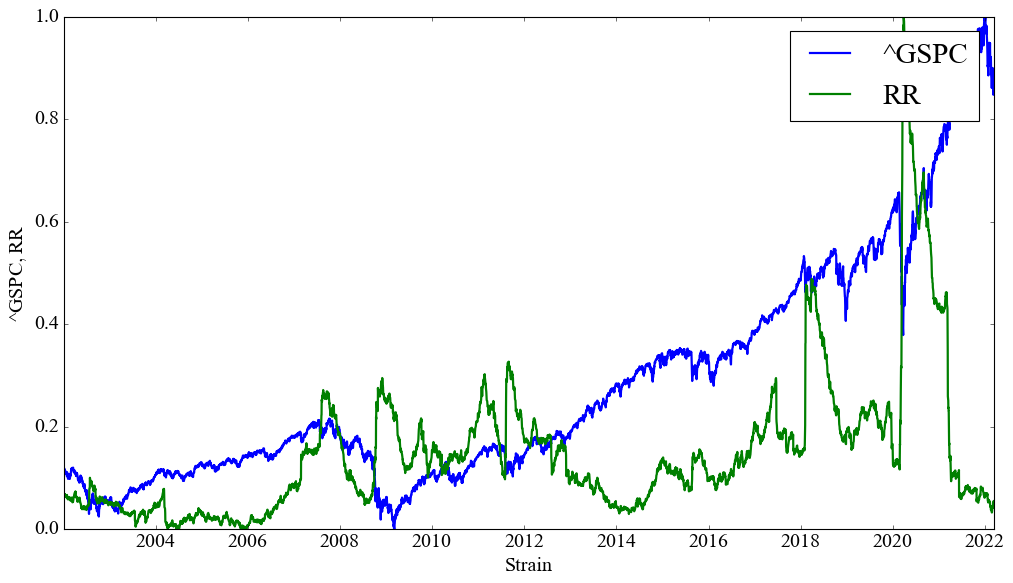

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_rr, label="RR")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "RR")

plt.savefig(path+f"CRQA_RR_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

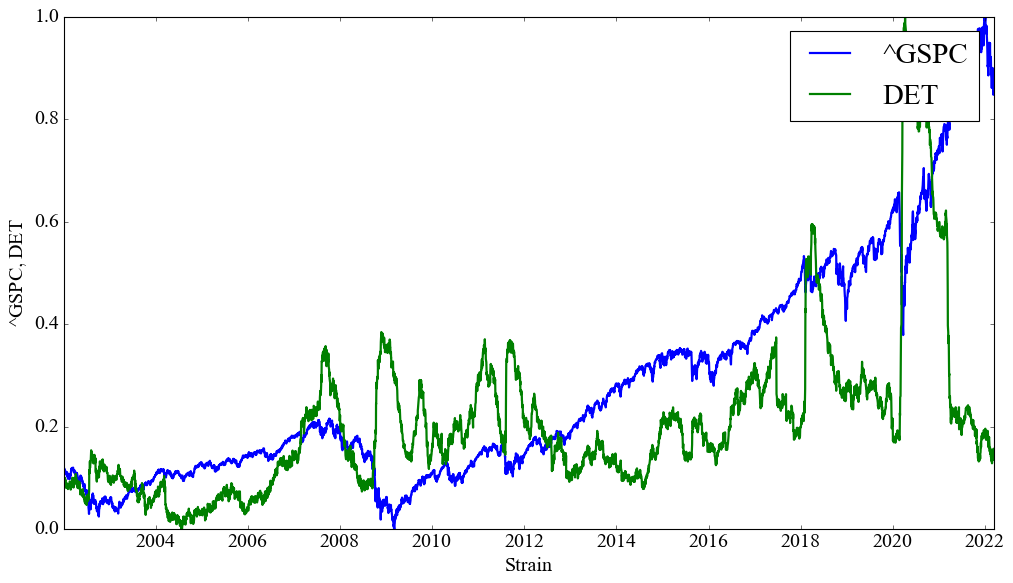

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_det, label="DET")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DET")

plt.savefig(path+f"CRQA_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

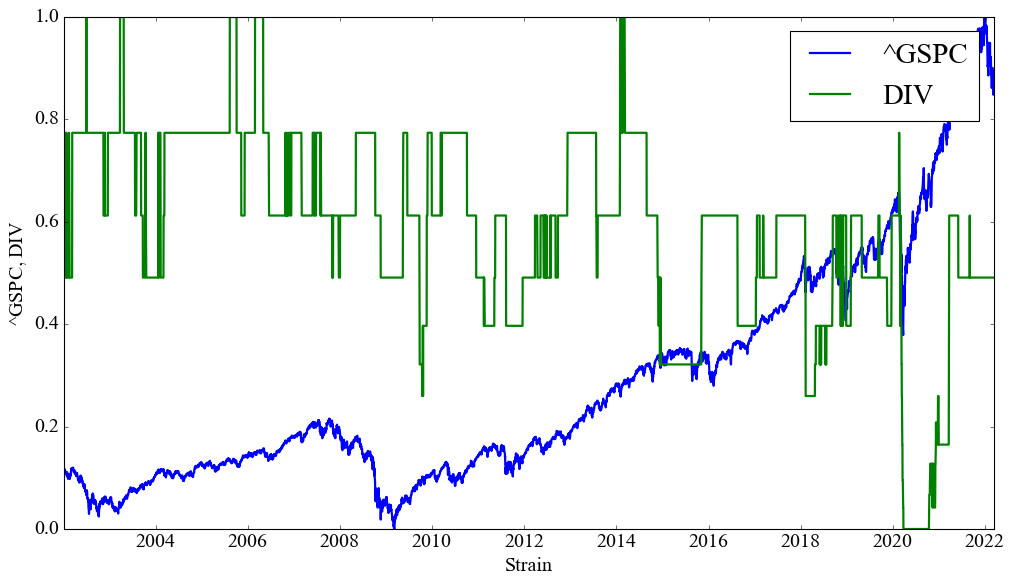

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_div, label="DIV")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DIV")

plt.savefig(path+f"CRQA_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

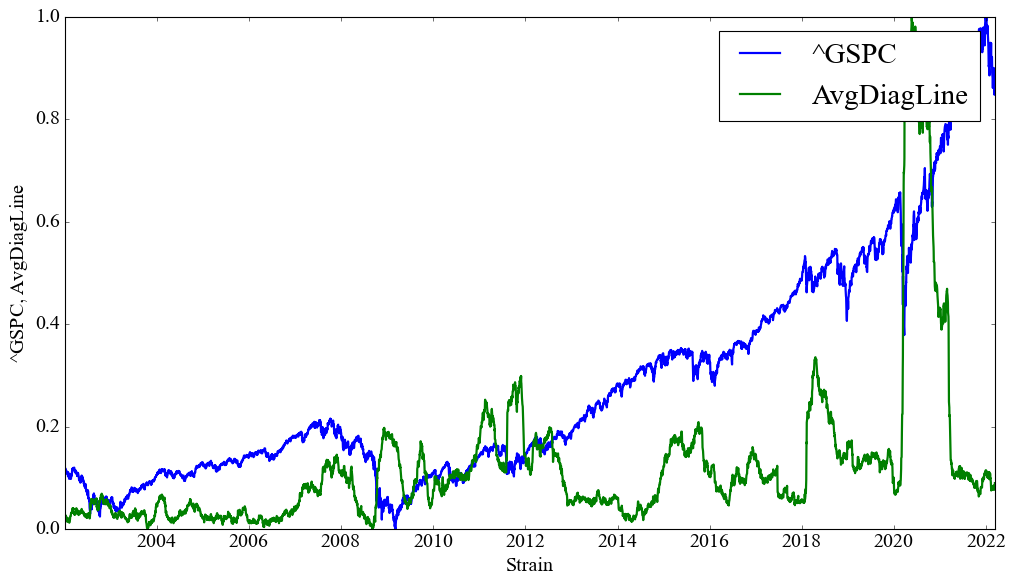

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_avg_diag_line, label="AvgDiagLine")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "AvgDiagLine")

plt.savefig(path+f"CRQA_AVG_DIAG_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

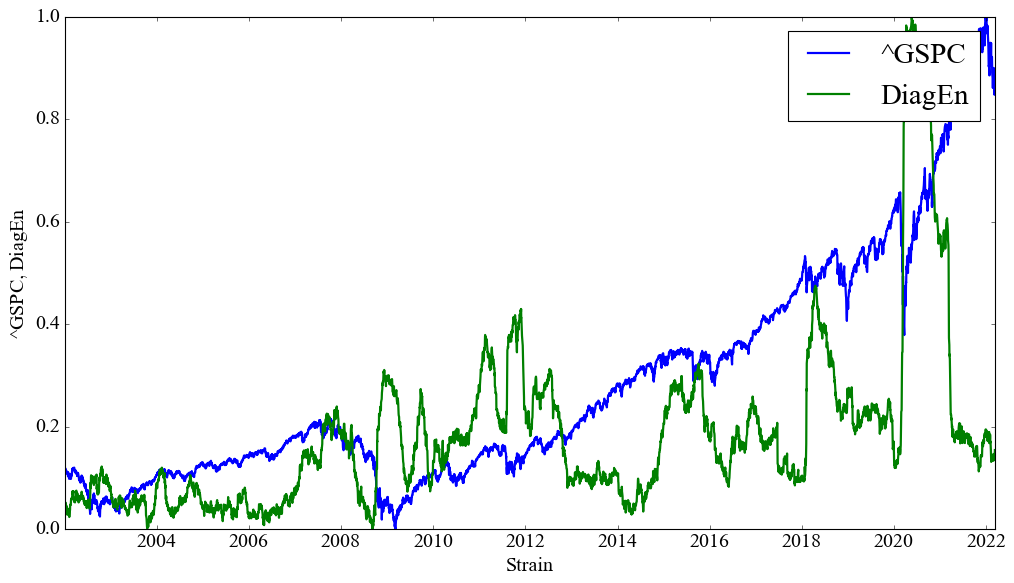

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ent_diag, label="DiagEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DiagEn")

plt.savefig(path+f"CRQA_ENT_DIAG_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

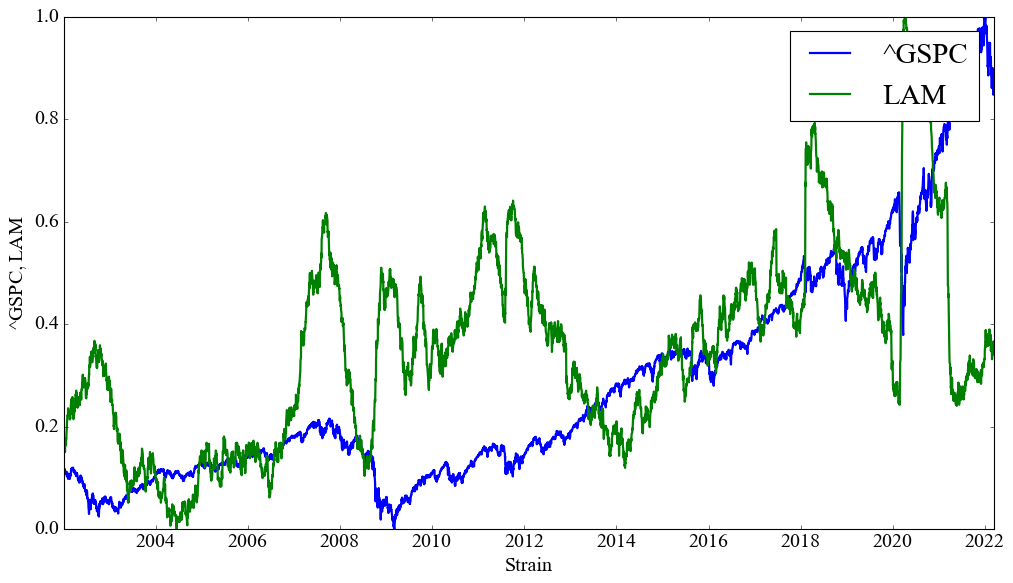

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_lam, label="LAM")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "LAM")

plt.savefig(path+f"CRQA_LAM_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

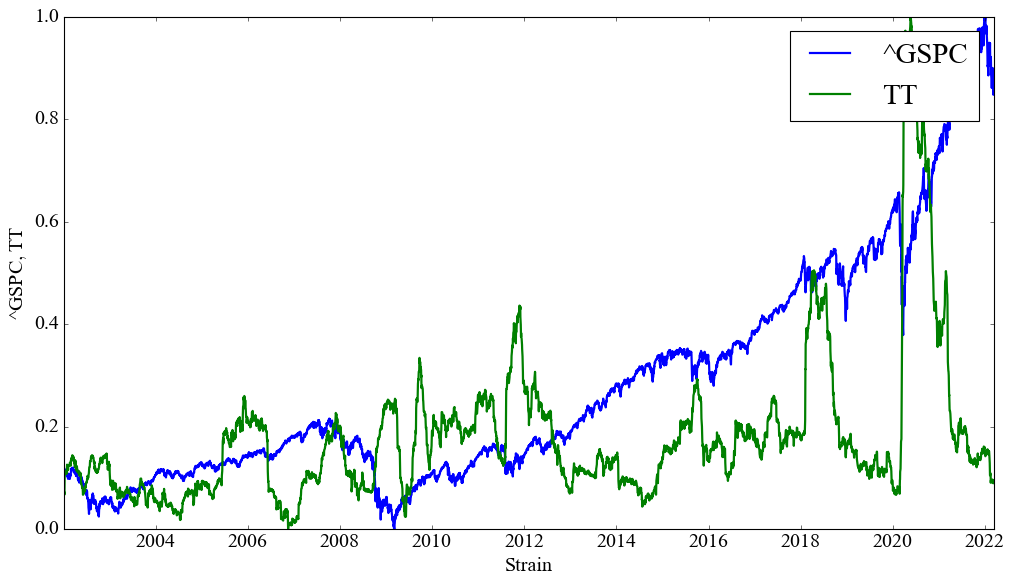

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_tt, label="TT")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "TT")

plt.savefig(path+f"CRQA_TRAPPING_TIME_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

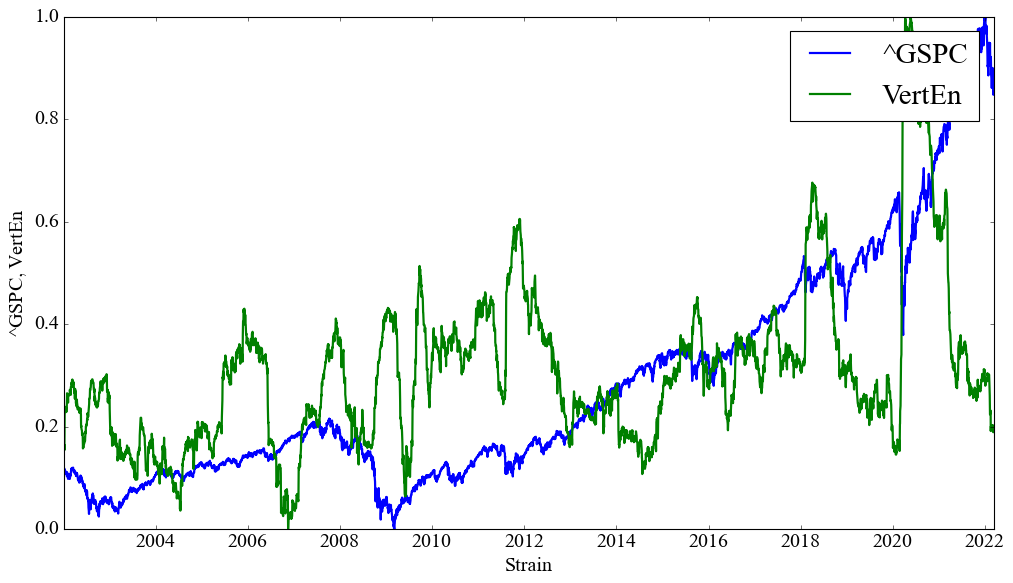

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ent_vert, label="VertEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "VertEn")

plt.savefig(path+f"CRQA_VERT_EN_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

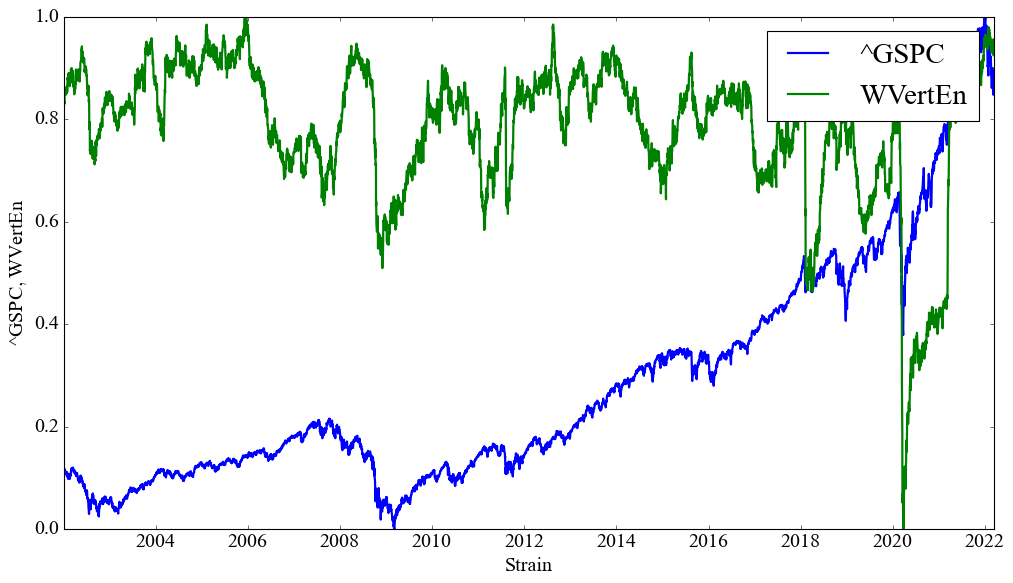

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ent_white_vert, label="WVertEn")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "WVertEn")

plt.savefig(path+f"CRQA_WHITE_VERT_LINE_ENT_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

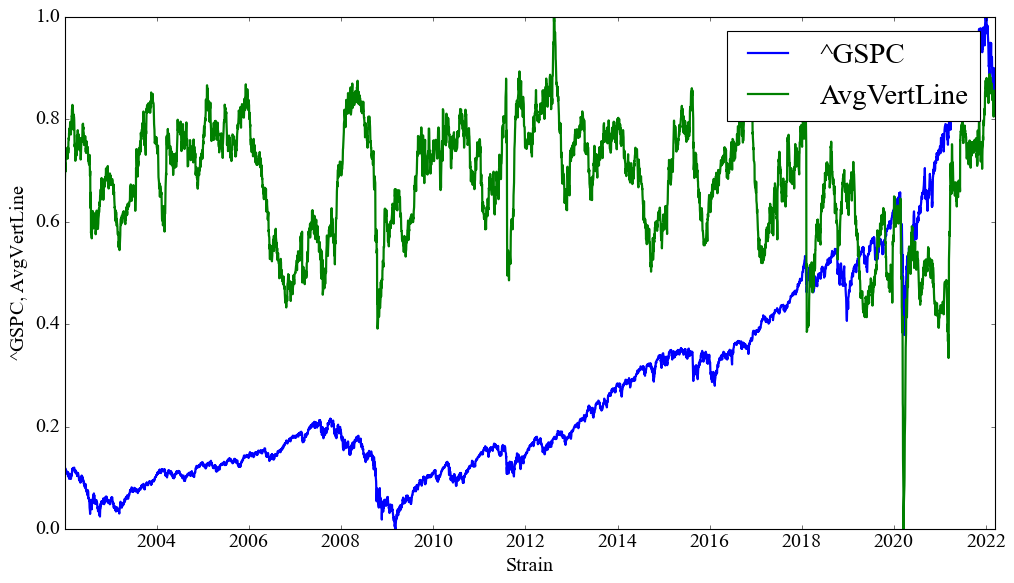

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_avg_vert_line, label="AvgVertLine")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "AvgVertLine")

plt.savefig(path+f"CRQA_AVG_VERT_LINE_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

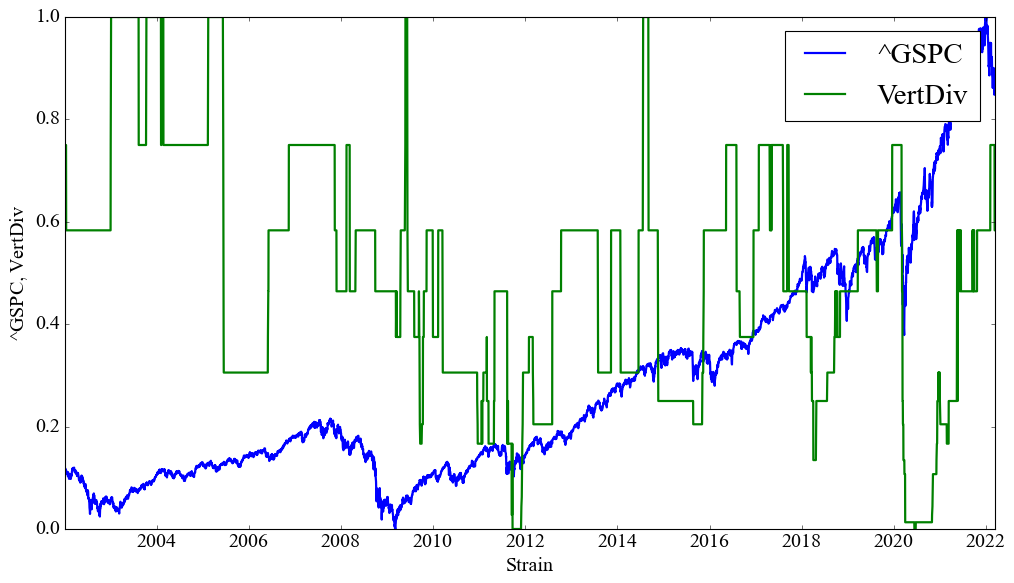

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_vert_div, label="VertDiv")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "VertDiv")

plt.savefig(path+f"CRQA_VERT_LINE_DIV_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

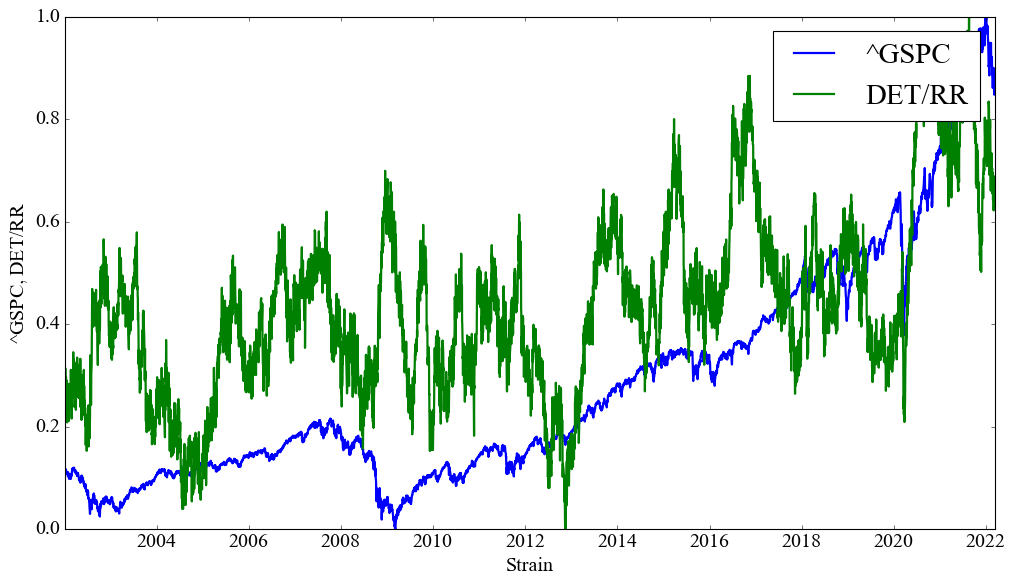

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ratio_det_rec, label="DET/RR")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "DET/RR")

plt.savefig(path+f"CRQA_RATIO_DET_RR_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()

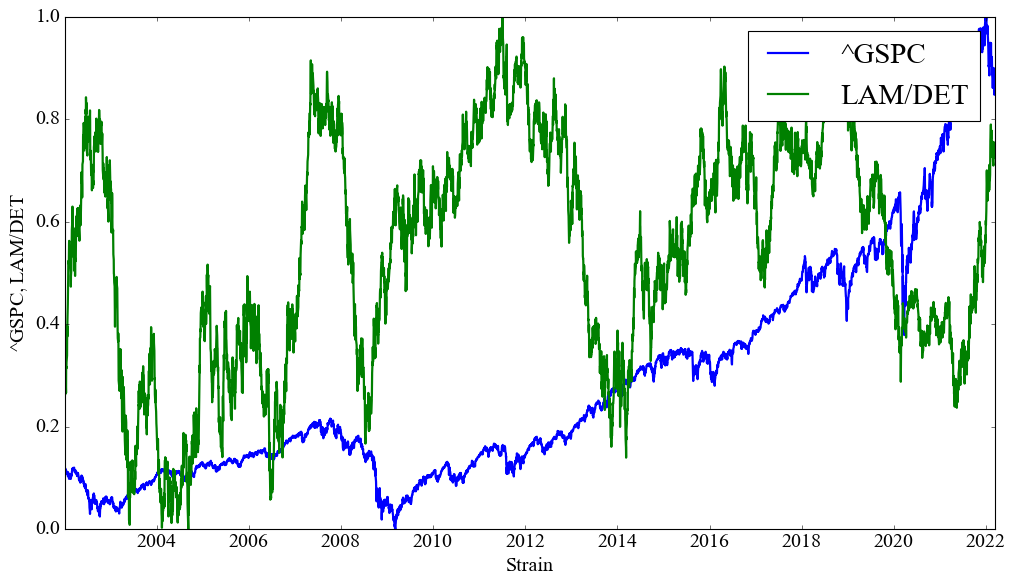

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(time_ser_1.index[window:length:tstep], scaled_time_ser[window:length:tstep], label=fr"{name_1.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_ratio_lam_det, label="LAM/DET")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_1.split('.')[0]}$,$" + "LAM/DET")

plt.savefig(path+f"CRQA_RATIO_LAM_DET_name={name_1.split('.')[0]}_name={name_2.split('.')[0]}_window={window}_step={tstep}_rettype={ret_type}_d_e1={d_e_1}_tau1={tau_1}_d_e2={d_e_2}_tau2={tau_2}_eps={eps}_theilerwind={theiler_wind}.jpg", bbox_inches="tight")
plt.show()